# Dry and Wet (Below) Settling code

# Python Libraries

In [1]:
# Kernel: python 3.10
# Import math Library

import math 
import numpy as np
import matplotlib.pyplot as plt

import numba as nb
#from numba import jit if low memory

from scipy.integrate import odeint


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


PS: Numba 

Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. <br>

The most common way to use Numba is through its collection of decorators that can be applied to your functions to instruct Numba to compile them. <br>

When a call is made to a Numba decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!

- Numba likes loops
- Numba likes NumPy functions
- Numba likes NumPy broadcasting

- > then use the decorator @jit(nopython=True) 

- Numba doesn't know about pd.DataFrame, or any linked calculation 
- > then use the decorator @jit(nopython=False) 

First compilation is normal time. Then used def yet compiled is fast

cf : https://numba.pydata.org/numba-doc/latest/user/5minguide.html for more info. 

# Dry Part
## Dry Code and definitions

In [2]:

#@nb.jit(nopython=True) 
# ---- Cunningham correction factor on particle:  -----------------------------
def cunninghamCorrectorJennings (particleDiameter, meanFreePath):
    '''
    DESCRIPTION: 
        Cunningham correction factor on particle based on Jennings reevaluation
    
    INPUT PARAMETERS: 
        particleDiameter : The particle diameter [m], float
        meanFreePath   :   The mean Free Path [m], float        

    CONSTANTS:
        LOCAL:
        A1 = 1.257
        A2 = 0.400
        A3 = 1.100

        
    LITERATURE:     
         Jennings SG (1988) The mean free path in air. Journal of Aerosol Science 19:159–166.    

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/04/2023        | Marianne Seijo | Created the function 
    '''     
    # Constant for Cunningham correction from Jennings, S, 1988
    A1 = 1.257
    A2 = 0.400
    A3 = 1.100
    
    Kn = (2.0 * meanFreePath) /  particleDiameter
    Cc = 1.0 + Kn * (A1 + A2 * np.exp(-A3 / Kn))     
    return Cc


#@nb.jit(nopython=True) 
# ---- Cunningham correction factor on particle:       -----------------------------
def cunninghamCorrector (particleDiameter, meanFreePath):
    '''
    DESCRIPTION: 
        Cunningham correction factor on particle
    
    INPUT PARAMETERS: 
        particleDiameter : The particle diameter [m], float
        meanFreePath   :   The mean Free Path [m], float        
              
    LITERATURE:     
        Zhang L, Gong S, Padro J, Barrie L (2001) 
        A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
        Atmospheric Environment 35:549–560. 
        Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
        From Air Pollution to Climate Change. John Wiley & Sons.    

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/04/2023        | Marianne Seijo | Created the function 
    '''    
    
    CC = 1.257 + 0.4 * np.exp(-0.55 *  (particleDiameter / meanFreePath))
    CC = 1.0 + 2.0 * CC * (meanFreePath / particleDiameter)
    return CC


#@nb.jit(nopython=True) 
def mu(T) :
    '''
    DESCRIPTION: 
        mu calculates the dynamic viscosity of the air at the temperature T

    INPUT PARAMETERS: 
        T :   The temperature [K], float

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 24/08/2023        | Marianne Seijo | Created the function 
    '''            
    return (1.8e-5 * math.pow((T / 298.), 0.85))


#@nb.jit(nopython=True) 
def mfp(T, P, Mu) :
    '''
    DESCRIPTION: 
        mfp calculates the mean free path at the temperature T, pressure P and viscosity Mu

    INPUT PARAMETERS: 
        T :   The temperature [K], float
        P :   The pressure [Pa = 1 kg m−1], float
       Mu :   The dynamic viscosity [Pa.s-1 = 1 kg.m−1.s−1], float
 
   CONSTANTS: 
       LOCAL:
       Mw :  molecular weight of air [kg.mol-1]
       R :   Gas constant [J.K-1.mol-1]
 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 24/08/2023        | Marianne Seijo | Created the function 
    '''      
    Mw = 28.97e-3  # [kg/mol] molecular weight of air
    R = 8.3144621 #  [J K-1 mol-1] Gas constant
    return (2.0 * Mu / P / math.sqrt(8.0 * Mw / (pi * R * T)))


#@nb.jit(nopython=True) 
def windFrictionVelocity(u_z, z, z0):
    '''
    DESCRIPTION: 
        Calculate the wind friction velocity from the Wind Speed u_z at heigth = z.
        and the roughness height of the surface z0

    INPUT PARAMETERS: 
        u_z :   The Wind Speed at heigth = z [m.s-1], float
        z   :   Height z above the Surface [m], float
        z0  :   Roughness Height of the Surface [m−], float
        
        
    CONSTANTS:
        karman: Von Kármán Constant (0.4)
        
    LITERATURE:     
        Panofsky HA (1963) Determination of stress from wind and temperature measurements. 
        Quarterly Journal of the Royal Meteorological Society 89:85–94. 
        Powell MD, Vickery PJ, Reinhold TA (2003) Reduced drag coefficient for high wind speeds in tropical cyclones.
        Nature 422:279–283.

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 24/08/2023        | Marianne Seijo | Created the function 
    '''     
    return (Karman * u_z / math.log(z/z0))


#@nb.jit(nopython=True) 
def ReynoldsNumberFromStokes(d, rho):
    '''
    DESCRIPTION: 
        Calculate the Reynolds Number based on settling velocity of Stokes

    INPUT PARAMETERS: 
        d :     The diameter of the particle [m], float
        rho :   The density p]of the particle [kg.m−3], float
        
    LITERATURE:     
        Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
        From Air Pollution to Climate Change. John Wiley & Sons.


    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 10/05/2023        | Marianne Seijo | Created the function 
    '''      
    vg = np.multiply(d,d) 
    vg = vg * g0 / (18.0 * mu_Air)
    vg = np.multiply(vg, (rho - rho_Air))
    
    Rep = np.multiply(vg, rho_Air)
    Rep = np.multiply(Rep, d)
    Rep = np.multiply(Rep, (1.0/mu_Air))
    
    return Rep


#@nb.jit(nopython=True) 
# Calculate the Drag coefficient number
def dragCoefficient (d, rho):
    '''
    DESCRIPTION: 
        Calculate rate constants of dry settling based on Newton regime
        (for big particles, generating a turbulent flow)

    INPUT PARAMETERS: 
        d :     The diameter of the particle [m], float
        rho :   The density p]of the particle [kg.m−3], float
        
    LITERATURE:     
        Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
        Atmospheric Environment.  
        Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
        From Air Pollution to Climate Change. John Wiley & Sons.


    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 10/05/2023        | Marianne Seijo | Created the function
    '''      
    Rep = ReynoldsNumberFromStokes (d, rho)
    Cd = np.zeros_like(Rep)
       
    Cd[Rep <= 1] = 24.0 / Rep[Rep <= 1]
    Cd[(1 < Rep) & (Rep <= 1000.0)] = 24.0 / Rep[(1 < Rep) & (Rep <= 1000.0)] + 5.0 / np.power(Rep[(1 < Rep) & (Rep <= 1000.0)], 0.6) + 0.44
    Cd[Rep > 1000.0] = 0.44
    Cd[Rep >= 2.0e5] = 0.10
    
    
    return Cd


#@nb.jit(nopython=True) 
def kineticCstdrySettlingNewton(d, rho, shape):
    '''
    DESCRIPTION: 
        Calculate rate constants of dry settling based on Newton regime
        (for big particles, generating a turbulent flow)

    INPUT PARAMETERS: 
        d :     The diameter of the particle [m], float
        rho :   The density p]of the particle [kg.m−3], float
        shape : The dynamic shape factor [-], float
        
    LITERATURE:     
        Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
        Atmospheric Environment.  
        Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
        From Air Pollution to Climate Change. John Wiley & Sons.


    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 10/05/2023        | Marianne Seijo | Created the function
    '''       
    d = np.array(d)
    rho = np.array(rho)
    
    # Calculate the drag coefficient Cd
    Cd = dragCoefficient (d, rho)
    
    # Calculate the settling velocity
    v = np.sqrt(4.0 * d * g0 * (rho - rho_Air) / (3.0 * Cd * rho_Air))

    elt = v / shape  # [m.s-1] / [m] The Boundary layer heigth
    return elt


#@nb.jit(nopython=True) 
def kineticCstDrySettlingStokesBrownian(particleDiameter, rhop, shape):
    '''
    DESCRIPTION: 
    Calculate the rate constant of the dry settling based on Stokes and Brownian regime
    (for small particles, generating a laminare flow)

    INPUT PARAMETERS: 
        particleDiameter :     The diameter of the particle [m], np.array
        rho :   The density p]of the particle [kg.m−3], np.array
        shape : The dynamic shape factor [-], float
        
    LITERATURE:     
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.  
    Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
    From Air Pollution to Climate Change. John Wiley & Sons.
 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/05/2023        | Marianne Seijo | Created the function
    '''        
    particleDiameter = np.array(particleDiameter)
    rhop = np.array(rhop)
    
    # Calculate the settling velocity
    v = g0 * particleDiameter * particleDiameter * (rhop - rho_Air) / (18.0 * mu_Air)

    
    # Calculate the Cunningham correction
    CC = cunninghamCorrector (particleDiameter, mfp_Air)
    elt = v * CC / shape # [m.s-1] / [m] The Boundary layer heigth
    return elt

#@nb.jit(nopython=True) 
def velocityDrySettling(d, rho, shape):
    '''
    DESCRIPTION: 
    Calculate the dry settling speed of a particle
    (for all settling regime)

    INPUT PARAMETERS: 
        d :     The diameter of the particle [m], float
        rho :   The density p]of the particle [kg.m−3], float
        shape : The dynamic shape factor [-], float
        
    LITERATURE:     
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.  
    Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
    From Air Pollution to Climate Change. John Wiley & Sons.

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 12/05/2023        | Marianne Seijo | Created the function
    '''    
    d = np.array(d)
    mask = d > 75.5e-6
    speed = np.where(mask, 
                       kineticCstdrySettlingNewton (d, rho, shape), 
                       kineticCstDrySettlingStokesBrownian(d, rho, shape))
    
    return speed

#@nb.jit(nopython=True) 
def aerodynamicResistance (LUC, Season, u_fr, L, Karman):
    '''
    DESCRIPTION: 
    Function aerodynamic_resistance calculates the aerodynamic resistance RA to dry deposition.
    Includes: stable stratification (L>0), neutral stratification (L=0), and unstable stratification (L<0)

    INPUT PARAMETERS: 
        LUC :   The land use categories defined by Zhaang 2001, SurfaceDefinition object
        Season :The season Sc of whang 2001 [-], 
        u_fr :  The friction velocity [m/s], float
        L :     The Monin-Obukhov length [m], float
        
    CONSTANTS: 
        GLOBAL:
            g0 : gravitational acceleration on earth g0 = 9.81  [m.s-2] 
        LOCAL:
            nu_Air: air kinematic viscosity  = 1.57 × 10−5 [m2 s−1]
        
    LITERATURE:     
    based on Seinfeld JH, Pandis SN (2016) Atmospheric Chemistry and Physics: 
    From Air Pollution to Climate Change. John Wiley & Sons. Equations 19.14.

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    '''

    z0, Acst, alpha, gamma = LUC.get_sc_values(Season)
    
    # Ri,  the fraction of particles stuck to a surface. 
    # Particles larger than 5e-6 m may rebound after hitting a surface.
    # No rebound on a wet surface
    if LUC.get_water():
        nu_Air = 1.57e-5
        z0 = (0.11 * nu_Air / u_fr) + (0.011 * u_fr * u_fr / g0)
       
    
    common_term = 1. / (Karman * u_fr)
    log_term = np.log(zr / z0)
    
    # neutral stratification
    if L == 0.:
        #print('neutral stratification')
        return (common_term * log_term)
    else:
        zeta = zr / L
        zeta0 = z0 / L
        
        # stable stratification
        if L > 0.:
            #print('stable stratification')
            return common_term * (log_term + 4.7 * (zeta - zeta0))
    
        # unstable stratification
        else:
            #print('unstable stratification')
            eta0 = (1.0 - 15.0 * zeta0)**0.25
            etar = (1.0 - 15.0 * zeta)**0.25
            atan_term = 2.0 * (np.arctan(etar) - np.arctan(eta0))
            log_term2 = np.log((eta0**2 + 1.0) * (eta0 + 1.0)**2.0 / ((etar ** 2 + 1.0) * (etar + 1.0)**2))
            return common_term * (log_term + log_term2 + atan_term)
    

#@nb.jit(nopython=True)     
def soilResistanceDetailled (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound):    
    '''
    DESCRIPTION: 
    Function soil_resistance calculates the soil resistance RS to dry deposition.

    INPUT PARAMETERS: 
        rhop: The density of the particle [kg/m3], float
        zr :     The top of the surface layer [m], float
        u_fr :   The friction velocity [m/s], float
        T_Air :  The temperature of Air [K], float
        P_Air :  The pressure of Air [Pa], float
        rho_Air: The density of the air [kg/m3], float
        mu_Air:  The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:  The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        Rebound: Is the rebound permitted?, boolean
        
        
    LITERATURE: 
        Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
        Atmospheric Environment.     
        Zhang L, Gong S, Padro J, Barrie L (2001) 
        A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
        Atmospheric Environment 35:549–560. 
        Petroff A, Zhang L (2010) Development and validation of a size-resolved particle dry 
        deposition scheme for application in aerosol transport models. 
        Geoscientific Model Development 3:753–769. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    | 1  | 24/08/2023        | Marianne Seijo | Introduce the Rebound as an option        
    '''

    z0, Acst, alpha, gamma = LUC.get_sc_values(Season)

    # ---- Cunningham correction factor on particle: -----------------------------
    CC = cunninghamCorrector (particleDiameters, mfp_Air)
 
        
    Ddiff = kB * T_Air * CC / (3.0 * pi * mu_Air * particleDiameters)  

    # The Schmidt number:
    Sc = mu_Air / (rho_Air * Ddiff)
    
    
    # Collection efficiencies of interception            
    Ein = 0.0    
    
    # The Stokes number:    
    if LUC.get_vegetated():
        St = vg * u_fr / (g0 * Acst)  # (vegetal surace)
        
        # Collection efficiencies of interception            
        Ein = particleDiameters / Acst
    else:
        St = vg * u_fr * u_fr * rho_Air / (g0 * mu_Air)  # (smooth surface)
   
    Ein = 0.5 * Ein * Ein
    

    # Ri,  the fraction of particles stuck to a surface. 
    # Particles larger than 5e-6 m may rebound after hitting a surface.
    # No rebound on a wet surface
    if LUC.get_water() or (not Rebound):
        Ri = 1.0
    else:
        Ri = np.exp(-St**0.5)  

 
    # Collection efficiencies of Brownian diffusion    
    Ebr = Sc**(-gamma)
    #print("Ebr=", Ebr)

   #print("Ein=", 0.5 * Ein * Ein)    
    
    # Collection efficiencies of Impaction    
    Eimp = St / (alpha + St)
    Eimp = (Eimp * Eimp)
    #print("Eimp=", (Eimp * Eimp))
        
    RS = 1.0 / (3. * u_fr * Ri * (Ebr + Ein + Eimp))
        
    return RS, Ebr, Ein, Eimp, Ri
    
    
#@nb.jit(nopython=True)     
def velocityDryDepositionDetailled (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                                    particleDiameters, LUC, Season, L, Karman, Rebound):
    '''
    DESCRIPTION: 
    Function velocityDryDeposition calculates the total velocity dry deposition.

    INPUT PARAMETERS: 
        rhop: The density of the particle [kg/m3], float
        zr :     The top of the surface layer [m], float
        u_fr :   The friction velocity [m/s], float
        T_Air :  The temperature of Air [K], float
        P_Air :  The pressure of Air [Pa], float
        rho_Air: The density of the air [kg/m3], float
        mu_Air:  The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:  The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        L:       The Monin-Obukhov length [m], float

        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        
        Rebound: Is the rebound permitted?, boolean
        
        
    LITERATURE: 
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.     
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    | 1  | 24/08/2023        | Marianne Seijo | Introduce the Rebound as an option    
    '''
    
    vg = velocityDrySettling(particleDiameters, rhop, 1.0)

    RS, Ebr, Ein, Eimp, Ri  = soilResistanceDetailled (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound)

    RA = aerodynamicResistance (LUC, Season, u_fr, L, Karman)
    
    vd = vg + (1.0 / (RA + RS))

        
    return vd, vg, RA, RS, Ebr, Ein, Eimp, Ri    
    
    
    
#@nb.jit(nopython=True)     
def soilResistance (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound):    
    '''
    DESCRIPTION: 
    Function soil_resistance calculates the soil resistance RS to dry deposition.

    INPUT PARAMETERS: 
        rhop: The density of the particle [kg/m3], float
        zr :     The top of the surface layer [m], float
        u_fr :   The friction velocity [m/s], float
        T_Air :  The temperature of Air [K], float
        P_Air :  The pressure of Air [Pa], float
        rho_Air: The density of the air [kg/m3], float
        mu_Air:  The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:  The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        Rebound: Is the rebound permitted?, boolean

        
    LITERATURE: 
        Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
        Atmospheric Environment.     
        Zhang L, Gong S, Padro J, Barrie L (2001) 
        A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
        Atmospheric Environment 35:549–560. 
        Petroff A, Zhang L (2010) Development and validation of a size-resolved particle dry 
        deposition scheme for application in aerosol transport models. 
        Geoscientific Model Development 3:753–769. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    | 1  | 24/08/2023        | Marianne Seijo | Introduce the Rebound as an option
    '''

    z0, Acst, alpha, gamma = LUC.get_sc_values(Season)

    # ---- Cunningham correction factor on particle: -----------------------------
    CC = cunninghamCorrector (particleDiameters, mfp_Air)
 
        
    Ddiff = kB * T_Air * CC / (3.0 * pi * mu_Air * particleDiameters)  

    # The Schmidt number:
    Sc = mu_Air / (rho_Air * Ddiff)


    
    # Collection efficiencies of interception            
    Ein = 0.0    
    
    # The Stokes number:    
    if LUC.get_vegetated():
        St = vg * u_fr / (g0 * Acst)  # (vegetal surace)
        
        # Collection efficiencies of interception            
        Ein = particleDiameters / Acst
    else:
        St = vg * u_fr * u_fr * rho_Air / (g0 * mu_Air)  # (smooth surface)
    
    
    Ein = 0.5 * Ein * Ein
    

    # Ri,  the fraction of particles stuck to a surface. 
    # Particles larger than 5e-6 m may rebound after hitting a surface.
    # No rebound on a wet surface
    if LUC.get_water() or (not Rebound):
        Ri = 1.0
    else:
        Ri = np.exp(-St**0.5)  

    
    # Collection efficiencies of Brownian diffusion    
    Ebr = Sc**(-gamma)

    #print("Ebr=", Ebr)

   #print("Ein=", 0.5 * Ein * Ein)    
    
    # Collection efficiencies of Impaction    
    Eimp = St / (alpha + St)
    Eimp = (Eimp * Eimp)
    #print("Eimp=", (Eimp * Eimp))
        
    RS = 1.0 / (3. * u_fr * Ri * (Ebr + Ein + Eimp))
        
    return RS
    
    

#@nb.jit(nopython=False) 
def velocityDryDeposition (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           particleDiameters, LUC, Season, L, Karman, Rebound):

    '''
    DESCRIPTION: 
    Function velocityDryDeposition calculates the total velocity dry deposition.

    INPUT PARAMETERS: 
        rhop: The density of the particle [kg/m3], float
        zr :     The top of the surface layer [m], float
        u_fr :   The friction velocity [m/s], float
        T_Air :  The temperature of Air [K], float
        P_Air :  The pressure of Air [Pa], float
        rho_Air: The density of the air [kg/m3], float
        mu_Air:  The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:  The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        L:       The Monin-Obukhov length [m], float

        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        Rebound: Is the rebound permitted?, boolean
        
    LITERATURE: 
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.     
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    | 1  | 24/08/2023        | Marianne Seijo | Introduce the Rebound as an option
    '''
    
    vg = velocityDrySettling(particleDiameters, rhop, 1.0)

    RS = soilResistance (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound)

    RA = aerodynamicResistance (LUC, Season, u_fr, L, Karman)
    
    vd = vg + (1.0 / (RA + RS))
       
    return vd


#@nb.jit(nopython=False) 
def velocityDryDepositionAggregate (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                                   particleDiameters, shape, r_agg, r_part, fd, kx,
                                    LUC, Season, L, Karman, Rebound):

    '''
    DESCRIPTION: 
    Function velocityDryDeposition calculates the total velocity dry deposition.

    INPUT PARAMETERS: 
        rhop:   The density of the particle [kg/m3], float
        zr :    The top of the surface layer [m], float
        u_fr :  The friction velocity [m/s], float
        T_Air : The temperature of Air [K], float
        P_Air : The pressure of Air [Pa], float
        rho_Air:The density of the air [kg/m3], float
        mu_Air: The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        r_agg: the radius of the aggregate used to calculate the permeability
        r_part: the radius of the particle in the aggregate
        fd: Fractal dimension
        kx: prefactor of the aggregate
        shape: the shape of the aggregate (global)
        
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        L:       The Monin-Obukhov length [m], float
        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        Rebound: Is the rebound permitted?, boolean
        
    LITERATURE: 
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.     
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 10/09/2023        | Marianne Seijo | Created the function
    '''
    
    vg = settlingVelocityPermeabilityAggregate (particleDiameters, rhop, shape, r_agg, r_part, fd, kx)

    RS = soilResistance (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound)

    RA = aerodynamicResistance (LUC, Season, u_fr, L, Karman)
    
    vd = vg + (1.0 / (RA + RS))
       
    return vd



### For Fibers:
Fibers shape, based on https://pubs.acs.org/doi/10.1021/acs.est.3c08209?goto=supporting-info and SI: https://pubs.acs.org/doi/suppl/10.1021/acs.est.3c08209/suppl_file/es3c08209_si_001.pdf

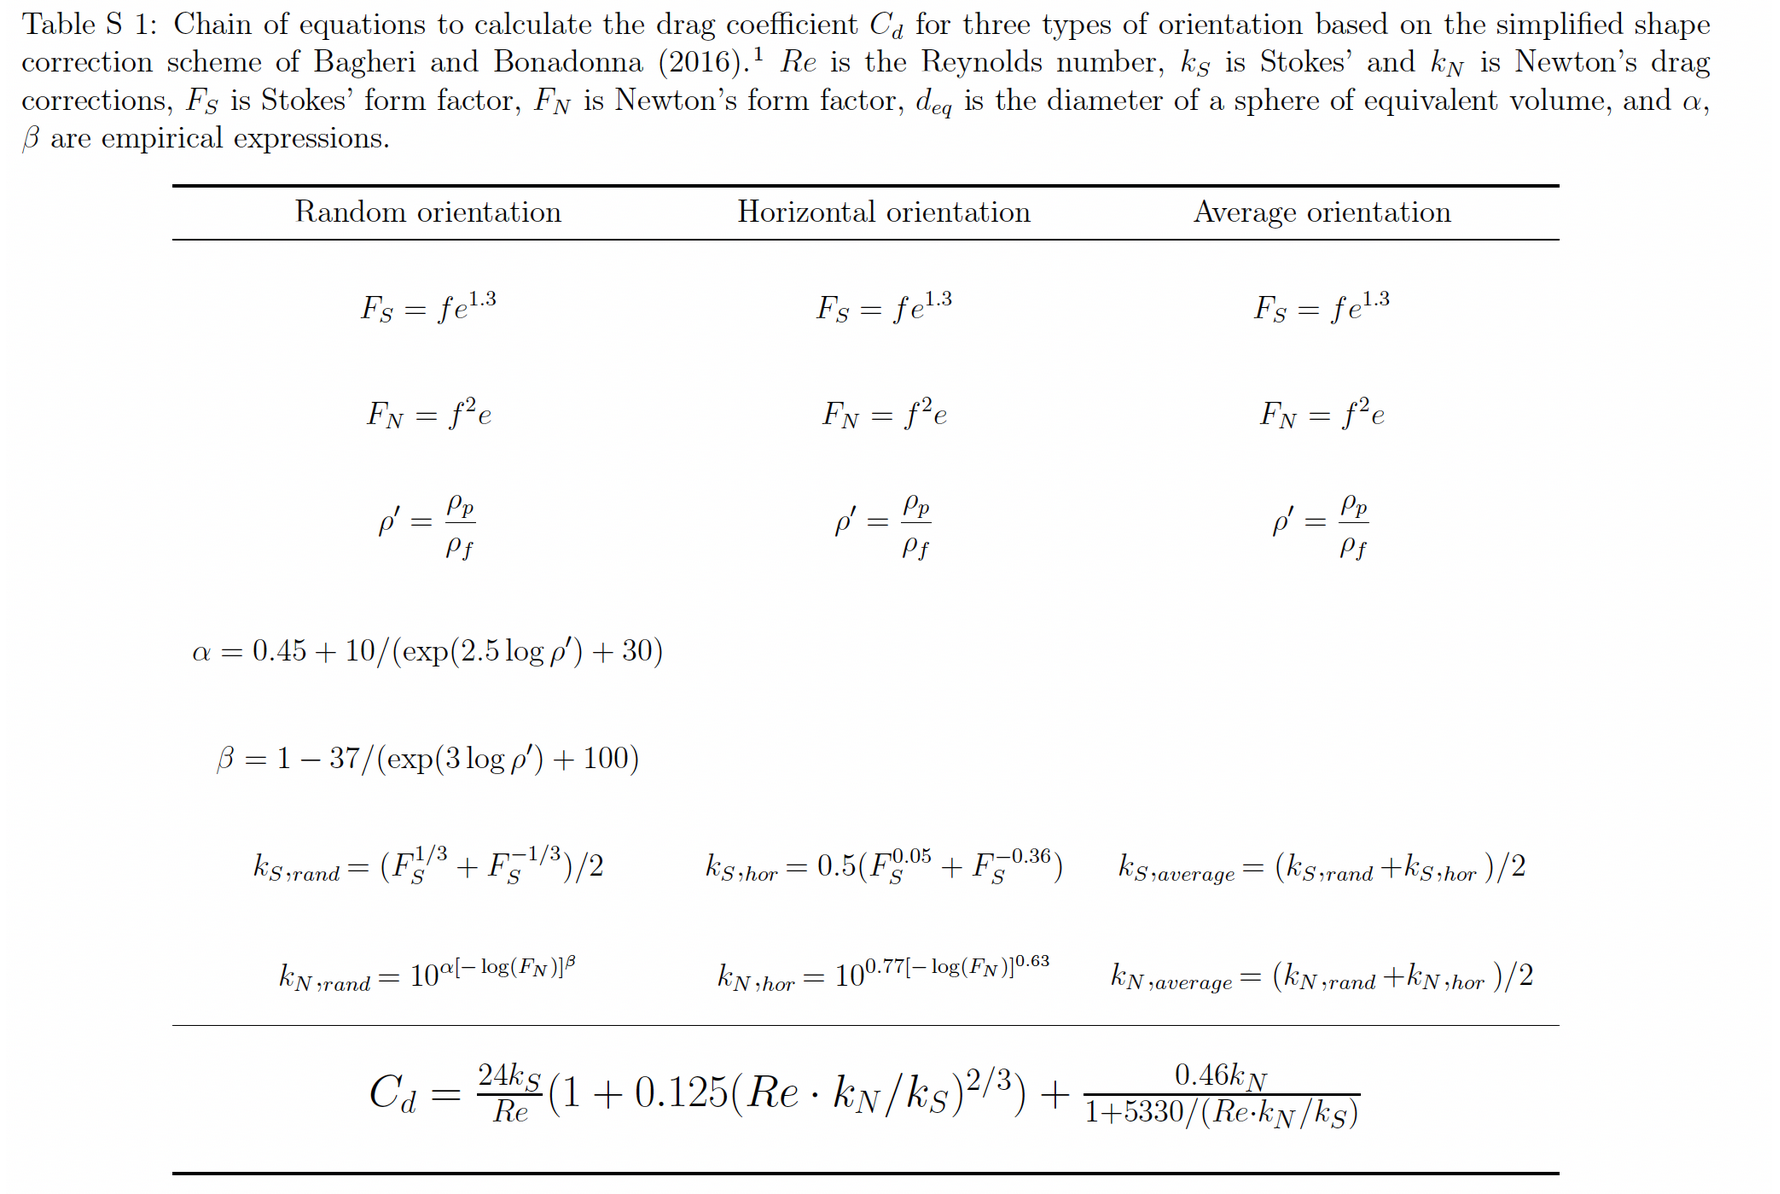
AR: aspect ratios AR (i.e., length/𝑑𝑐𝑦𝑙
)
This model is valid for a wild range of particle Reynolds numbers (up to Re = 3×105

),
and account the flatness (f = S/I)
and elongation (e = I/L),
where L is the longest, I─the intermediate, and S─the smallest dimension of the particle.

The average give the best results compared to experimental, we adopt this model

In [3]:
#@nb.jit(nopython=True) 
# Calculate the Drag coefficient number for a Fiber

def dragCoefficientFibers (Small_Dim, Intermediat_Dim, Long_Dim, rho_p, Rep):
    '''
    DESCRIPTION: 
        Calculate rate constants of dry settling based on Newton regime
        (for big particles, generating a turbulent flow)

    INPUT PARAMETERS: 
        Small_Dim : Small dimension of the fiber [m], float
        Intermediat_Dim : Intermediate dimension of the fiber [m], float
        Long_Dim : Long dimension of the fiber [m], float
        d :     The diameter of the particle [m], float
        rho :   The density p]of the particle [kg.m−3], float
        
    LITERATURE: 
        Bagheri and Bonadonna : https://doi.org/10.1016/j.powtec.2016.06.015
        Tatsii D. et al. (2024) Environ. Sci. Technol. 58, 1, 671–682:
        Shape Matters: Long-Range Transport of Microplastic Fibers in the Atmosphere 
        

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 10/05/2024        | Marianne Seijo | Created the function
    '''       

    deq = diameterEquivalentDiameterFiber (Small_Dim, Intermediat_Dim, Long_Dim)
        
    
    f = Small_Dim / Intermediat_Dim # fatness
    e = Intermediat_Dim / Long_Dim  # elongation
    
    print('f= ', f, '| e= ', e, 'Rep=', Rep)
    print()

    rho = (rho_p / rhoAir)
    #print('rho= ', rho, 'rho_p', rho_p, 'rhoAir', rhoAir)


    alpha = 0.45 + 10.0 / (np.exp(2.5 * np.log(rho)) + 30.0) 
    beta  = 1.0  - 37.0 / (np.exp(3.0 * np.log(rho)) + 100.0)
    
    
    FS = f * (e**1.3) # Stokes form factor
    FN = f * f * e    # Newton form factor
    
    
    #print('FS', FS, 'FN', FN)

    kS_rand = (FS**(1.0 / 3.0) + FS**(-1.0 / 3.0)) / 2.0  # Stokes' drag correction
    kN_rand = 10.0**(alpha * ((-np.log(FN))**beta))       # Newton's drag correction

    #print('kS_rand', kS_rand, 'kN_rand', kN_rand)
    
    k_ratio = kN_rand / kS_rand
    
    
    kS_hori = (FS**(0.05) + FS**(-0.36)) / 2.0           # Stokes' drag correction
    kN_hori = 10.0**(0.77 * ((-np.log(FN))**0.63))       # Newton's drag correction

    #print('kS_hori', kS_hori, 'kN_hori', kN_hori)

    kS_avrge = (kS_rand + kS_hori) / 2.0   # Stokes' drag correction
    kN_avrge = (kN_rand + kN_hori) / 2.0   # Newton's drag correction
    
    #print('kS_avrge', kS_avrge, 'kN_avrge', kN_avrge)
    
    
    k_ratio = kN_avrge / kS_avrge    
    Cd = 24.0 * kS_avrge / Rep
    Cd = Cd * (1.0 + 0.125 * (Rep * k_ratio)**2.0/3.0) 
    Cd = Cd + 0.46 * kN_avrge / (1.0 + 5330.0 / (Rep * k_ratio))
    
    return Cd



# Calculate the diameter of a sphere with the same volume as the particle, [m]
# https://doi.org/10.1016/j.powtec.2016.06.015 table 1
#def diameterEquivalentDiameterFiber (Small_Dim, Intermediat_Dim, Long_Dim):
#    deq = 2.0*(3.0 * (Small_Dim / 2.0) * 
#                     (Intermediat_Dim / 2.0) * 
#                      Long_Dim / 4.0)**(1.0 / 3.0)
#    return deq


def diameterEquivalentDiameterFiber(Small_Dim, Intermediat_Dim, Long_Dim):
    # Calculate the volume of the fiber
    V_fiber = (np.pi / 4.0) * Small_Dim * Intermediat_Dim * Long_Dim
    
    # Calculate the radius of a sphere with the same volume
    radius_sphere = ((3.0 * V_fiber) / (4.0 * np.pi)) ** (1.0/3.0)
    
    # Calculate the diameter of the sphere
    deq = 2.0 * radius_sphere
    
    return deq



# Calculate the round fiber dimensions based on the aspect ratio AR (=L/S) and 
# the spherical volume equivalent diameter. 
# The assumption is Intermediat_Dim = Small_Dim
def fiberRoundDimensionsFromEquivalentDiameter(deq, AR):
    # Calculate small dimension (Small_Dim) and intermediate dimension (Intermediat_Dim)
    # We assume Small_Dim = Intermediat_Dim

    Small_Dim = (2.0 * deq**3.0 / (3.0 * AR))**(1.0/3.0)

    Intermediat_Dim = Small_Dim
    
    # Calculate long dimension (Long_Dim)
    Long_Dim = AR * Small_Dim
    
    return Small_Dim, Intermediat_Dim, Long_Dim


# Calculate the flat fiber dimensions based on the aspect ratio AR (=L/S), 
# the thickness TH (=I/S) and the spherical volume equivalent diameter. 
# The assumption is Intermediat_Dim = Small_Dim
def fiberFlatDimensionsFromEquivalentDiameter(deq, AR, TH):
    # Calculate small dimension (Small_Dim) and intermediate dimension (Intermediat_Dim)
    # We assume Small_Dim = Intermediat_Dim

    Small_Dim = (2.0 * deq**3.0 / (3.0 * AR * TH))**(1.0/3.0)

    Intermediat_Dim = TH*Small_Dim
    
    # Calculate long dimension (Long_Dim)
    Long_Dim = AR * Small_Dim
    
    return Small_Dim, Intermediat_Dim, Long_Dim

# Calculate the gravitational terminal velocity of a given particle with 
# small, intermediate, long dimension and the density. 
# Used for fibers, 
# Give as output the gravitational terminal velocity and Reynolds number
#
# Bagheri and Bonadonna : https://doi.org/10.1016/j.powtec.2016.06.015
#
# Comparisons of methods: https://pubs.acs.org/doi/epdf/10.1021/acsestwater.2c00466
#
# https://github.com/e5k/CareySparks86_Matlab/blob/master/get_height_CS86.m
def velocityDrySettlingFibersAndCo(Small_Dim, Intermediat_Dim, Long_Dim, rho_p):
    rhoAir = 1.096 # Fluid density
    g0 = 9.81
    muAir = 1.8975e-5  # Fluid dynamic viscosity
    
    # Calculate the equivalent diameter for a sphere
    deq = diameterEquivalentDiameterFiber (Small_Dim, Intermediat_Dim, Long_Dim)
    
    
    mass = rho_p * np.pi * (deq**3.0) /6.0  # Mass
    
    f = Small_Dim / Intermediat_Dim  # fatness
    e = Intermediat_Dim / Long_Dim   # elongation    
    
    #Initial terminal velocity
    #vg = 1.0e-12 
    vg = 1.0e-20
    
    #Initial terminal velocity
    acceleration = 9.81
    
    # Stokes shape descriptor
    Fs = f*e**1.3
    
    # Stokes drag correction
    ks = 0.5*(Fs**(1/3) + Fs**(-1/3))  
    
    # Newton shape descriptor
    Fn = (f**2)*e
    
    # Newton drag correction
    kn = 10.0**(0.45* (-np.log10(Fn))**0.99)
    
    # Time step for falling simulation (need to be low for small particles)
    #delta_t = deq / 10.0 #100.0 #1000.0
    delta_t = deq /1000.0

    
    stopSecure = 0
    
    while np.any(acceleration > (0.01*9.81)):      
        Re = rhoAir * vg * deq / muAir     # Reynold's number
        Re_star = Re * kn / ks             # Normalized Reynold's number
        
        # Drag coefficient
        Cd = kn * (24.0 / Re_star * (1.0 + 0.125 * Re_star**(2.0 / 3.0)) + 0.46/ (1.0 + 5330.0 / Re_star))
        
        # Drag force
        F_drag  = 0.5 * rhoAir * 0.25 * np.pi * deq * deq * Cd * vg * vg 
        
        # Update acceleration
        acceleration     = (mass * 9.81 - F_drag) / mass
        
        # Update falling velocity
        vg = acceleration * delta_t + vg             
 
        stopSecure = stopSecure + 1
        
        #if (stopSecure == 100000):
        #    print ('Stop the loops')
        #    vg=0
        #    break
            
    print ('Re=', Re, 'vg fibre=', vg)
    return vg

def fiber_Shape (Small_Dim, Intermediat_Dim, Long_Dim, rho_p):
    #print()

    deq = diameterEquivalentDiameterFiber (Small_Dim, Intermediat_Dim, Long_Dim)
    
    v_sphere = drySettling_kinetics (deq, rho_p, 1.0)
    v_fiber =  kineticCstdrySettlingNewtonFibersAndCo (Small_Dim, Intermediat_Dim, Long_Dim, rho_p)
    print('v_sphere ', v_sphere)
    print('v_fiber', v_fiber)
    shape = np.array(v_sphere/v_fiber)
    return shape



#@nb.jit(nopython=False) 
def velocityDryDeposition_Fiber (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim, Intermediat_Dim, Long_Dim, LUC, Season, L, Karman, Rebound):

    '''
    DESCRIPTION: 
    Function velocityDryDeposition calculates the total velocity dry deposition.

    INPUT PARAMETERS: 
        rhop: The density of the particle [kg/m3], float
        zr :     The top of the surface layer [m], float
        u_fr :   The friction velocity [m/s], float
        T_Air :  The temperature of Air [K], float
        P_Air :  The pressure of Air [Pa], float
        rho_Air: The density of the air [kg/m3], float
        mu_Air:  The dynamic viscosity of the air kg m-1 s-1], float
        mfp_Air:  The Mean free path on dry air [m], float

        particleDiameters: The diameter of particles [m], np.array
        LUC:     The SurfaceDefinition object of the studied surface , object
        Season:  The Seasonnal integer (between 0 to 4), integer
        L:       The Monin-Obukhov length [m], float

        vg:      The settling velocity (Brownian, Stokes Newton) of each particles [m.s-1], np.array
        
        Rebound: Is the rebound permitted?, boolean
        
    LITERATURE: 
    Slinn WGN (1982) Predictions for particle deposition to vegetative canopies. 
    Atmospheric Environment.     
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the function
    | 1  | 24/08/2023        | Marianne Seijo | Introduce the Rebound as an option
    '''
    
    #vg = velocityDrySettling(particleDiameters, rhop, 1.0)
    vg = velocityDrySettlingFibersAndCo(Small_Dim, Intermediat_Dim, Long_Dim, rhop)
    
    particleDiameters = diameterEquivalentDiameterFiber(Small_Dim, Intermediat_Dim, Long_Dim)

    RS = soilResistance (rhop, zr, u_fr, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC, Season, vg, Rebound)

    RA = aerodynamicResistance (LUC, Season, u_fr, L, Karman)
    
    vd = vg + (1.0 / (RA + RS))
       
    return vd

## Dry Data Data

6. Resistance to deposition

https://www.annualreviews.org/doi/pdf/10.1146/annurev-physchem-090519-034936 https://gmd.copernicus.org/articles/3/753/2010/gmd-3-753-2010.pdf https://www.sciencedirect.com/science/article/pii/S1352231000003265?casa_token=Ne0Br-qhyYkAAAAA:Tmr3A38gw3PuDPr1IpEYDSrTmrSAH16NJkrscWrqqCawrmFxS5HXPBCdLym63XQ1urnh_vit#FIG1

A challenge in the dry deposition particles is to predict deposition trends across diverse land type accurately (Farmer et al. 2021): The pioneering approach taking into account the size of particles and the canopy was developed by Slinn (Slinn 1982) on the vegetative canopy, followed the works of Peter and Eiden ((Peters and Eiden 1992)) for a spruce forest (Peters and Eiden 1992) and by by Giorgi (Giorgi 1986) who developed the model for four types of surfaces: smooth surfaces, surfaces with bluff roughness elements, ocean surfaces, and vegetative canopies. Later, because earlier models predict much lower deposition velocities for sub-micron aerosols compared to recent observations and because a need in the scientific community appears for different land types descriptions compared to previous models, Zhang et al. (Zhang et al. 2001) developed a framework based on Slinn, Peter and Eiden, and Giorgi models, with 15 land use categories (LUC) and 5 seasonal categories. This model has become a reference on particle dry depositions, adopted by large-scale models (Andersson et al., 2007; Ghan and Easter, 2006; Gong et al., 2006; Heald et al., 2006; Wang et al., 2006; Zakey et al., 2006).

An improvement on the domain was made by Petroff & Zhang (Petroff and Zhang 2010) to increase the land use categories (LUC) with specific cultures (26 LUC) and by incorporating the phoretic effects on the settling velocity of over water, ice, and snow surfaces, giving an accurate capture of the minimum in the deposition trend compared to observed deposition measurements for water surfaces. At the state of the art, the ERA5-Land, the land surface reanalysis from the European Centre for Medium-Range Weather Forecasts (ECMWF), uses 13 land use categories.

In Eq. 1, based on Zhang et al. framework (Zhang et al. 2001), RA, the aerodynamic resistance, is calculated as: R_A=(ln(z_R/z_0 )-ψH)/(κu* ) Eq. 21

With zR is the height of the canopy (m), zo is the roughness length (m), ψH is the stability function (-), κ is the von Karman constant (-), and u* is the friction velocity (m.s−1).

RS, the surface resistance, depends on the collection efficiency of the surface.

R_S=1/(ε_0 u_* (E_Br+E_In+E_Imp ) R_i )    Eq.  22

With ε0 an empirical constant that was taken to equal a value of 3 for all land use types by Zhang et al.(Zhang et al. 2001), u* the friction velocity (m.s−1). R_i represents the fraction of particles stuck to a surface. Particles larger than 5 m may rebound after hitting a surface. This process may be included by modifying the total collection efficiency by the factor of R_i, which represents the fraction of particles sticking to the surfaces. For wet surfaces, there is no rebound, else: R_i=exp(〖-St〗^(1/2) ) Eq. 22

With St the Stokes number, St=vgu/gA for vegetated surfaces (Slinn, 1982), A is the characteristic radius of collectors. For smooth surfaces or with bluff roughness surfaces, St=vgu2/ (Giorgi, 1988). `.

EBr, EIn and EImp are the collection efficiencies of Brownian diffusion, interception, and impaction, respectively, defined as:

E_Br=〖Sc〗^(-γ)    Eq.  23

With Sc is the Schmidt number, given as the ratio of the kinematic viscosity of air, , to the particle Brownian diffusivity, D: Sc=/D.  usually lies between 1/2 for smooth surfaces, as surface water, to 2/3 for rougher surfaces as vegetated surfaces.

E_In=0.5(d_p/A)^2    Eq.  24

The characteristic radius A is given for different land use and seasonal categories (Zhang et al. 2001). E_Imp=(St/(α+St))^β Eq. 25

With  and  are constants. Using 0.8 for a and 2 for b, respectively, (Peters and Eiden 1992) get the best fit for the data collected by (Belot and Gauthier 1974).

Both upper and lower tables Extract from (Zhang et al. 2001), I let it for you coauthor, will quote it only in the final version

From Zhang et al 2001 https://www.sciencedirect.com/science/article/pii/S1352231000003265?casa_token=Ne0Br-qhyYkAAAAA:Tmr3A38gw3PuDPr1IpEYDSrTmrSAH16NJkrscWrqqCawrmFxS5HXPBCdLym63XQ1urnh_vit#FIG1

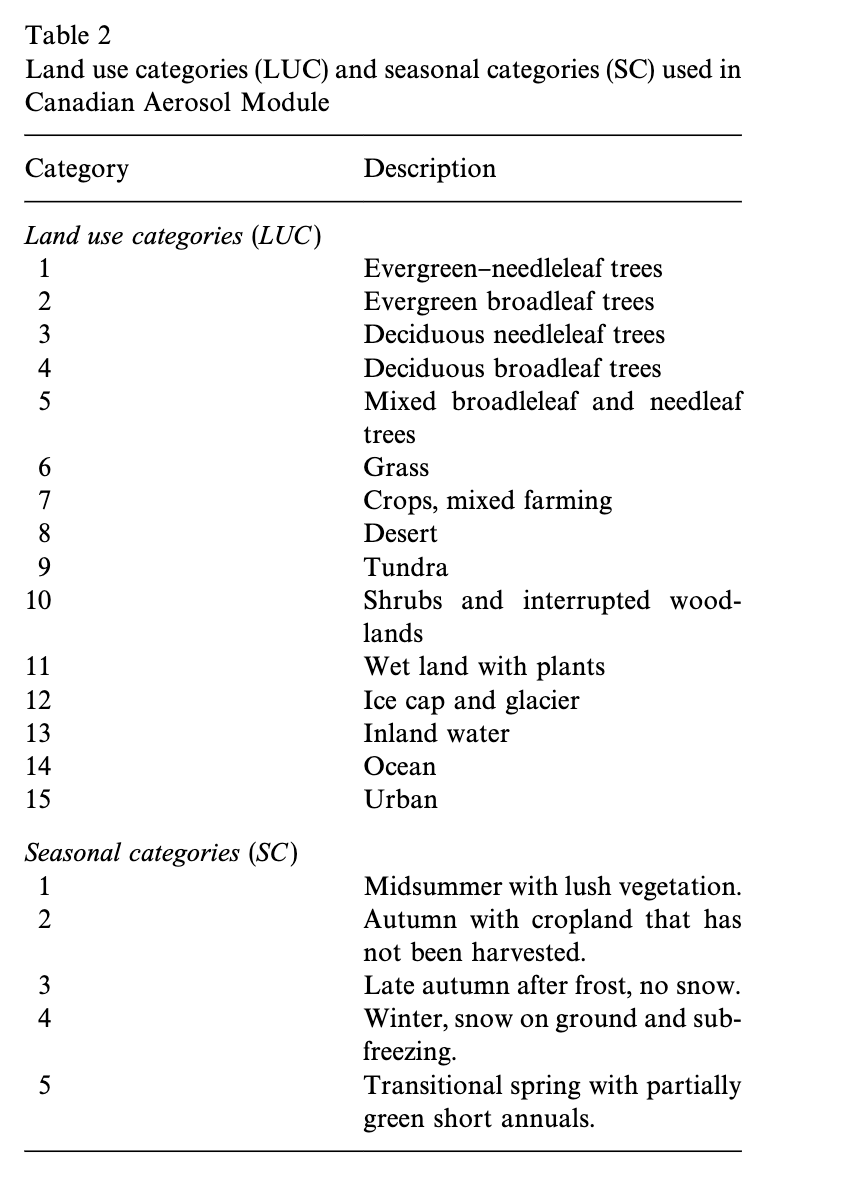



https://www.aiche.org/ccps/resources/glossary/process-safety-glossary/friction-velocity-u The variable u* can also be estimated from wind observations. A rough rule of thumb is that the ratio u/u is about 0.05 to 0.1, where u is the wind speed at a height of about 10 m, which is the standard measurement height at airports around the world. u has typical values ranging from about 0.05 m/s in light winds to about 1 m/s in strong winds.


In [4]:
'''
DESCRIPTION: 
    Classes describing the seasonal and land surface specific parameters to calculate the soil resistances

        
LITERATURE:     
    The parameter values of z0, Acst, alpha, gamma are from: 
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

REVISIONS:
| Nb | Date (dd/mm/year) | Author         |  What
-------------------------------------------------------------------------------------------------
| 0  | 15/08/2023        | Marianne Seijo | Created the classes Seasonnal and Surface Definition, 
|    |                   |                | Added the values of LUC and Season from Zhang et al. 2001
'''


class Seasonnal:
    '''
    DESCRIPTION: 
        Classes describing the seasonal surface specific parameters to calculate the soil resistances

    LITERATURE:     
        The parameter values of z0 [m], Acst[m], alpha[-], gamma[-] are from: 
        Zhang L, Gong S, Padro J, Barrie L (2001) 
        A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
        Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -------------------------------------------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the classes Seasonnal Definition, 
    '''    
    
    def __init__(self):
        self._attributes = [0.0, 0.0, 0.0, 0.0]

    def set_values(self, z0, Acst, alpha, gamma):
        self._attributes = [z0, Acst, alpha, gamma]

    def get_values(self):
        return tuple(self._attributes)
    
    def set_z0(self, z0):
        self._attributes[0] = z0

    def get_z0(self):
        return self._attributes[0]   

    def print_values(self):
        attributes_names = ["z0", "Acst", "alpha", "gamma"]
        for name, value in zip(attributes_names, self._attributes):
            print(f"{name}: {value}")


class SurfaceDefinition:
    '''
    DESCRIPTION: 
        Classes describing the land surface specific parameters to calculate the soil resistances


    LITERATURE:     
        The parameter values of z0, Acst, alpha, gamma are from: 
        Zhang L, Gong S, Padro J, Barrie L (2001) 
        A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
        Atmospheric Environment 35:549–560. 

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -------------------------------------------------------------------------------------------------
    | 0  | 15/08/2023        | Marianne Seijo | Created the classes Surface Definition, 
    '''    
    def __init__(self, name):
        self.name = name
        self.vegetated = True # the surface is or smooth or rough vegetated surface (by default)
        self.water = False # the surface is a surface water? (False by default)
        self.Sc = [Seasonnal() for _ in range(5)]

    def set_sc_values(self, index, z0, Acst, alpha, gamma):
        self.Sc[index].set_values(z0, Acst, alpha, gamma)

    def get_sc_values(self, ScNumber):
        return self.Sc[ScNumber-1].get_values()
    
    def set_z0(self, index, z0):
        self.Sc[index].set_z0(z0)

    def get_z0(self, ScNumber):
        return self.Sc[ScNumber-1].get_z0()   
    
    def set_vegetated(self, booleanValue):
        self.vegetated = booleanValue

    def get_vegetated(self):
        return self.vegetated

    def set_water(self, booleanValue):
        self.water = booleanValue

    def get_water(self):
        return self.water    

    def print_sc_values(self, index):
        if (self.vegetated):
            print(f"Seasonnal {index+1} attributes for {self.name}, rough vegetated surface")
        else:
            print(f"Seasonnal {index+1} attributes for {self.name}, smooth surface")
        self.Sc[index].print_values()
        
    def calculate_water_z0 (self, index, u_fr, rho_Air, mu_Air):
        if(self.water):
             z0 = (0.11 * mu_Air / (rho_Air * u_fr) + (0.011 * u_fr * u_fr / g0))        
             return z0
        else:
            return f'{self.name} is not a water surface, z0 can not be calculated by function: calculate_water_z0 '

   
'''
DESCRIPTION: 
    Register the parameters from Zhang et al. 2001 to calculate the soil resistances

        
LITERATURE:     
    Zhang L, Gong S, Padro J, Barrie L (2001) 
    A size-segregated particle dry deposition scheme for an atmospheric aerosol module. 
    Atmospheric Environment 35:549–560. 

REVISIONS:
| Nb | Date (dd/mm/year) | Author         |  What
-------------------------------------------------------------------------------------------------
| 0  | 15/08/2023        | Marianne Seijo | Added the values of LUC and Season from Zhang et al. 2001
'''        

LUC1 = SurfaceDefinition('LUC 1: Evergreen needleleaf trees')
attributes_list = [(0.8, 2.0e-3, 1.0, 0.56), 
                   (0.9, 2.0e-3, 1.0, 0.56),
                   (0.9, 2.0e-3, 1.0, 0.56), 
                   (0.9, 2.0e-3, 1.0, 0.56),
                   (0.8, 2.0e-3, 1.0, 0.56)]

for i, attributes in enumerate(attributes_list):
    LUC1.set_sc_values(i, *attributes)

LUC1.print_sc_values(1)
LUC1.print_sc_values(4)


LUC2 = SurfaceDefinition('LUC 2: Evergreen broadleaf trees')
attributes_list = [(2.65, 5.0e-3, 0.6, 0.58), 
                   (2.65, 5.0e-3, 0.6, 0.58),
                   (2.65, 5.0e-3, 0.6, 0.58), 
                   (2.65, 5.0e-3, 0.6, 0.58),
                   (2.65, 5.0e-3, 0.6, 0.58)]

for i, attributes in enumerate(attributes_list):
    LUC2.set_sc_values(i, *attributes)

LUC2.print_sc_values(1)
LUC2.print_sc_values(4)


LUC3 = SurfaceDefinition('LUC 3: Deciduous needleleaf trees')
attributes_list = [(0.85, 2.0e-3, 1.1, 0.56), 
                   (0.85, 2.0e-3, 1.1, 0.56),
                   (0.80, 5.0e-3, 1.1, 0.56), 
                   (0.55, 5.0e-3, 1.1, 0.56),
                   (0.60, 2.0e-3, 1.1, 0.56)]

for i, attributes in enumerate(attributes_list):
    LUC3.set_sc_values(i, *attributes)

LUC3.print_sc_values(1)
LUC3.print_sc_values(4)


LUC4 = SurfaceDefinition('LUC 4: Deciduous broadleaf trees')
attributes_list = [(1.05, 5.0e-3, 0.8, 0.56), 
                   (1.05, 5.0e-3, 0.8, 0.56),
                   (0.95, 10.0e-3, 0.8, 0.56), 
                   (0.55, 10.0e-3, 0.8, 0.56),
                   (0.75, 5.0e-3, 0.8, 0.56)]

for i, attributes in enumerate(attributes_list):
    LUC4.set_sc_values(i, *attributes)

LUC4.print_sc_values(1)
LUC4.print_sc_values(4)


LUC5 = SurfaceDefinition('LUC 5: Mixed broadleleaf and needleaf trees')
attributes_list = [(1.15, 5.0e-3, 0.8, 0.56), 
                   (1.15, 5.0e-3, 0.8, 0.56),
                   (1.15, 5.0e-3, 0.8, 0.56), 
                   (1.15, 5.0e-3, 0.8, 0.56),
                   (1.15, 5.0e-3, 0.8, 0.56)]

for i, attributes in enumerate(attributes_list):
    LUC5.set_sc_values(i, *attributes)

LUC5.print_sc_values(1)
LUC5.print_sc_values(4)


LUC6 = SurfaceDefinition('LUC 6: Grass')
attributes_list = [(0.1, 2.0e-3, 1.2, 0.54), 
                   (0.1, 2.0e-3, 1.2, 0.54),
                   (0.05, 5.0e-3, 1.2, 0.54), 
                   (0.02, 5.0e-3, 1.2, 0.54),
                   (0.05, 2.0e-3, 1.2, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC6.set_sc_values(i, *attributes)

LUC6.print_sc_values(1)
LUC6.print_sc_values(4)


LUC7 = SurfaceDefinition('LUC 7: Crops, mixed farming')
attributes_list = [(0.1, 2.0e-3, 1.2, 0.54), 
                   (0.1, 2.0e-3, 1.2, 0.54),
                   (0.02, 5.0e-3, 1.2, 0.54), 
                   (0.02, 5.0e-3, 1.2, 0.54),
                   (0.05, 2.0e-3, 1.2, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC7.set_sc_values(i, *attributes)

LUC7.print_sc_values(1)
LUC7.print_sc_values(4)


LUC8 = SurfaceDefinition('LUC 8: Desert')
LUC8.set_vegetated(False)

attributes_list = [(0.04, 0, 50.0, 0.54), 
                   (0.04, 0, 50.0, 0.54),
                   (0.04, 0, 50.0, 0.54), 
                   (0.04, 0, 50.0, 0.54),
                   (0.04, 0, 50.0, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC8.set_sc_values(i, *attributes)

LUC8.print_sc_values(1)
LUC8.print_sc_values(4)


LUC9 = SurfaceDefinition('LUC 9: Tundra')
LUC9.set_vegetated(False)

attributes_list = [(0.03, 0, 50.0, 0.54), 
                   (0.03, 0, 50.0, 0.54),
                   (0.03, 0, 50.0, 0.54), 
                   (0.03, 0, 50.0, 0.54),
                   (0.03, 0, 50.0, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC9.set_sc_values(i, *attributes)

LUC9.print_sc_values(1)
LUC9.print_sc_values(4)

LUC10 = SurfaceDefinition('LUC 10: Shrubs and interrupted wood lands')
attributes_list = [(0.1, 10.0e-3, 1.3, 0.54), 
                   (0.1, 10.0e-3, 1.3, 0.54),
                   (0.1, 10.0e-3, 1.3, 0.54), 
                   (0.1, 10.0e-3, 1.3, 0.54),
                   (0.1, 10.0e-3, 1.3, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC10.set_sc_values(i, *attributes)

LUC10.print_sc_values(1)
LUC10.print_sc_values(4)


LUC11 = SurfaceDefinition('LUC 11: Wet land with plants')
attributes_list = [(0.03, 10.0e-3, 1.0, 0.54), 
                   (0.03, 10.0e-3, 1.0, 0.54),
                   (0.02, 10.0e-3, 1.0, 0.54), 
                   (0.02, 10.0e-3, 1.0, 0.54),
                   (0.03, 10.0e-3, 1.0, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC11.set_sc_values(i, *attributes)

LUC11.print_sc_values(1)
LUC11.print_sc_values(4)

LUC12 = SurfaceDefinition('LUC 12: Ice cap and glacier')
LUC12.set_vegetated(False)
attributes_list = [(0.01, 0, 50.0, 0.54), 
                   (0.01, 0, 50.0, 0.54),
                   (0.01, 0, 50.0, 0.54), 
                   (0.01, 0, 50.0, 0.54),
                   (0.01, 0, 50.0, 0.54)]

for i, attributes in enumerate(attributes_list):
    LUC12.set_sc_values(i, *attributes)

LUC12.print_sc_values(1)
LUC12.print_sc_values(4)


LUC13 = SurfaceDefinition('LUC 13: Inland water')
LUC13.set_vegetated(False)
LUC13.set_water(True)
attributes_list = [(0, 0, 100.0, 0.50), 
                   (0, 0, 100.0, 0.50),
                   (0, 0, 100.0, 0.50), 
                   (0, 0, 100.0, 0.50),
                   (0, 0, 100.0, 0.50),]

for i, attributes in enumerate(attributes_list):
    LUC13.set_sc_values(i, *attributes)

LUC13.print_sc_values(1)
LUC13.print_sc_values(4)


LUC14 = SurfaceDefinition('LUC 14: Ocean')
LUC14.set_vegetated(False)
LUC14.set_water(True)
attributes_list = [(0, 0, 100.0, 0.50), 
                   (0, 0, 100.0, 0.50),
                   (0, 0, 100.0, 0.50), 
                   (0, 0, 100.0, 0.50),
                   (0, 0, 100.0, 0.50)]

for i, attributes in enumerate(attributes_list):
    LUC14.set_sc_values(i, *attributes)

LUC14.print_sc_values(1)
LUC14.print_sc_values(4)

LUC15 = SurfaceDefinition('LUC 15: Urban')
attributes_list = [(1.0, 10.0e-3, 1.5, 0.56), 
                   (1.0, 10.0e-3, 1.5, 0.56),
                   (1.0, 10.0e-3, 1.5, 0.56), 
                   (1.0, 10.0e-3, 1.5, 0.56),
                   (1.0, 10.0e-3, 1.5, 0.56)]

for i, attributes in enumerate(attributes_list):
    LUC15.set_sc_values(i, *attributes)

LUC15.print_sc_values(1)
LUC15.print_sc_values(4)




Seasonnal 2 attributes for LUC 1: Evergreen needleleaf trees, rough vegetated surface
z0: 0.9
Acst: 0.002
alpha: 1.0
gamma: 0.56
Seasonnal 5 attributes for LUC 1: Evergreen needleleaf trees, rough vegetated surface
z0: 0.8
Acst: 0.002
alpha: 1.0
gamma: 0.56
Seasonnal 2 attributes for LUC 2: Evergreen broadleaf trees, rough vegetated surface
z0: 2.65
Acst: 0.005
alpha: 0.6
gamma: 0.58
Seasonnal 5 attributes for LUC 2: Evergreen broadleaf trees, rough vegetated surface
z0: 2.65
Acst: 0.005
alpha: 0.6
gamma: 0.58
Seasonnal 2 attributes for LUC 3: Deciduous needleleaf trees, rough vegetated surface
z0: 0.85
Acst: 0.002
alpha: 1.1
gamma: 0.56
Seasonnal 5 attributes for LUC 3: Deciduous needleleaf trees, rough vegetated surface
z0: 0.6
Acst: 0.002
alpha: 1.1
gamma: 0.56
Seasonnal 2 attributes for LUC 4: Deciduous broadleaf trees, rough vegetated surface
z0: 1.05
Acst: 0.005
alpha: 0.8
gamma: 0.56
Seasonnal 5 attributes for LUC 4: Deciduous broadleaf trees, rough vegetated surface
z0: 0.75
Ac

# Wet Part

# Below Cloud
## Below Cloud Code and definitions

In [5]:
# Calculate and store the scavenging coefficient in pur Slinn model


### Needed Functions ---------------------------------------------------

@nb.jit(nopython=True)
### Raindrop terminal velocity ----------------------------------------
def raindropVelocity (D_d, mfp_Air, rho_Air, mu_Air, rho_W, T_Air, g0):
    Vrt = 0.0
    T_Air_C = T_Air - 273.15 # [C] Air temperature

    ## --For raindrop diameter 0.5μm < 𝐷𝑑 < 19μm -------------------------
    if (D_d <= 19.0e-6):
        # 1-Calculate the Cunningham correction   ------------------------
        Cc = 1.0 + (2.0 * mfp_Air / D_d) * (1.257 + 0.4 * math.exp(-1.1 * D_d / (2.0 * mfp_Air)))

        # 2-Calculate the Raindrop terminal velocity ------------------------
        Vrt = D_d * D_d * (rho_W - rho_Air) * g0 * Cc / (18.0 * mu_Air)
 
    ## --For raindrop diameter 19μm < 𝐷𝑑 < 1.07mm ------------------------
    elif (D_d <= 1.07e-3):
        # 1-Calculate the Cunningham correction   ------------------------
        Cc = 1.0 + (2.0 * mfp_Air / D_d) * (1.257 + 0.4 * math.exp(-1.1 * D_d / (2.0 * mfp_Air)))

        # 2-Calculate the Reynold’s number   ------------------------
        X = math.log(4.0 * D_d * D_d * D_d * rho_Air * (rho_W - rho_Air) * g0 / (3.0 * mu_Air * mu_Air))

        Y = - 3.18657 \
            + 0.992696 * X \
            - 0.153193e-2 * X * X \
            - 0.987059e-3 * X * X * X \
            - 0.578878e-3 * X * X * X * X \
            + 0.855176e-4 * X * X * X * X * X \
            - 0.327815e-5 * X * X * X * X * X * X   

        Re = Cc * math.exp(Y)

        # 3-Calculate the Raindrop terminal velocity ------------------------
        Vrt = mu_Air * Re / (rho_Air * D_d)

    ## --For raindrop diameter 1.07mm < 𝐷𝑑 < 7mm ------------------------
    elif (D_d <= 7.0e-3):  

        # 1-Calculate the surface tension sigma; the bond number B0; and the ratio of the Davies number to the Bond number N0  ------------------------        
        sigma = 0.0
        if (T_Air_C < 0.0):
            sigma = 75.93 + 0.115  * T_Air_C \
                    + 6.818e-2 * T_Air_C * T_Air_C \
                    + 6.511e-3 * T_Air_C * T_Air_C * T_Air_C \
                    + 2.933e-4 * T_Air_C * T_Air_C * T_Air_C * T_Air_C \
                    + 6.283e-6 * T_Air_C * T_Air_C * T_Air_C * T_Air_C * T_Air_C \
                    + 5.285e-8 * T_Air_C * T_Air_C * T_Air_C * T_Air_C * T_Air_C * T_Air_C
            sigma = 0.001 * sigma
        else:
            rT = (374.0 - T_Air_C) / 647.15
            sigma = 0.2358 * (rT**1.256)
            sigma = sigma * (1 - (0.625 * rT))
            
        B0 = 4.0 * D_d * D_d * (rho_W - rho_Air) * g0  
        B0 = B0 / (3.0 * sigma)
        
        Np = sigma * sigma * sigma * rho_Air * rho_Air 
        Np = Np / (mu_Air * mu_Air * mu_Air * mu_Air * (rho_W - rho_Air) * g0 )

        # 2-Calculate the Reynold’s number   ------------------------
        X = math.log (B0 * Np**(1.0/6.0))
        
        Y = - 5.00015 \
            + 5.23778 * X \
            - 2.04914 * X * X \
            + 0.475294  * X * X * X \
            - 0.542819e-1 * X * X * X * X \
            + 0.238449e-2 * X * X * X * X * X   
        
        Re = math.exp(Y) * (Np**(1.0/6.0))
        
        # 3-Calculate the Raindrop terminal velocity ------------------------
        Vrt = mu_Air * Re / (rho_Air * D_d)
   
    return Vrt

@nb.jit(nopython=True)
# ---- Cunningham correction factor on particle:       -----------------------------
def cunninghamCorrector (particleDiameter, meanFreePath):
    CC = 1.257 + 0.4 * np.exp(-0.55 *  (particleDiameter / meanFreePath))
    CC = 1.0 + 2.0 * CC * (meanFreePath / particleDiameter)
    return CC

@nb.jit(nopython=True)
# ---- Raindrop Reynolds number:       -----------------------------
def raindropReynoldsNumber (raindropDiameter, meanFreePath, rho_Air, mu_Air, rho_W, T_Air, g0):
    Vtr = raindropVelocity (raindropDiameter, meanFreePath, rho_Air, mu_Air, rho_W, T_Air, g0)   
    Re = raindropDiameter * Vtr * rho_Air /(2.0 * mu_Air)
    return Re

@nb.jit(nopython=True)
# ---- Collection Efficiency from Brownian Diffusion ------------------
def collectionEfficiencyBrownian (particleDiameter, raindropDiameter, CC, Re, mu_Air, rho_Air):
    Ddiff = kB * T_Air * CC / (3.0 * pi * mu_Air * particleDiameter)
    Sc = mu_Air / (rho_Air * Ddiff)
    sqrtRe = Re**0.5
    Ebrow = 1.0 + 0.4 * sqrtRe * (Sc**(1.0/3.0)) + 0.16* sqrtRe * (Sc**0.5)
    Ebrow = 4.0 * Ebrow / (Re * Sc)
    return Ebrow
    
@nb.jit(nopython=True)
# ---- Collection Efficiency from Interception ------------------
def collectionEfficiencyInterception (particleDiameter, raindropDiameter, Re, mu_Air, mu_W):
    EInt = 1.0 + 2.0 * Re**0.5
    EInt = (mu_Air / mu_W) + (EInt * particleDiameter / raindropDiameter) 
    EInt = 4.0 * EInt * particleDiameter / raindropDiameter
    return EInt

@nb.jit(nopython=True)
# ---- Collection Efficiency from Interception ------------------
# rho_p is the density of the particle
def collectionEfficiencyImpaction (rho_p, particleDiameter, raindropDiameter, CC,  Re, Vtr, Vtp, mu_Air, rho_Air):
    lnRe = math.log(1.0 + Re)

    St2 = 1.2 + (1.0/12.0) * lnRe 
    St2 = St2 / lnRe
    
    tau = 0.0
    tau = (rho_p - rho_Air) * particleDiameter * particleDiameter * CC
    tau = tau / (18.0 * mu_Air)

    St = 0.0
    St = 2.0 * tau * (Vtr - Vtp) / raindropDiameter

    EImp = 0.0   
    if (St > St2):
        EImp = ((St - St2) / (St - St2 + (2.0/3.0)))**(3.0/2.0)  
    
    #print('------------ \n ',EImp, St, St2)
    return EImp

@nb.jit(nopython=True)
# ---- Collection Efficiency from Diffusiophoresis ------------------
def collectionEfficiencyDiffusiophoresis (P_Air, T_Air, RH, Re, raindropDiameter, Vtr, mu_Air, rho_Air):
    T0 = 273.15 # [K]
    P0 = 101325.0 # [Pa]   
    
    T_Air_C = T_Air - 273.15
    # Surface temperature of raindrops Ts, assumption from Wang et al. (2010)
    Ts = T_Air_C - 3.0    
    
    ka = 418.4e-5 * (1.04645 + (0.017 * T_Air)) # Air thermal conductivity from Pruppacher and Klett (2010)   
    
    Ddiffwater = 0.211e-4 * (P0 / P_Air) * (T_Air / T0)**1.94  # from Pruppacher and Klett (2010)

    beta_dph = (T_Air * Ddiffwater / P_Air) * (Mw / Ma)**0.5
    
    Scw = mu_Air / (rho_Air * Ddiffwater)
    
    # We use the saturation vapour pressure formula from Seinfeld and Pandis (1998)
    # Caution: temperature is in Celsius degrees. p0 are in Pa   
    a0 = 6.107799961
    a1 = 4.436518521e-1
    a2 = 1.428945805e-2
    a3 = 2.650648471e-4
    a4 = 3.031240396e-6
    a5 = 2.034080948e-8
    a6 = 6.136820929e-11
    
    T = Ts #(T must be in Celsius here)
    p0s = 100.0 * (a0 + a1 * T + \
                   a2 * T * T + \
                   a3 * T * T * T + \
                   a4 * T * T * T * T + \
                   a5 * T * T * T * T * T + \
                   a6 * T * T * T * T * T * T )
    
    T = T_Air_C #(T must be in Celsius here)
    p0_Air = 100.0 * (a0 + a1 * T + \
                      a2 * T * T + \
                      a3 * T * T * T + \
                      a4 * T * T * T * T + \
                      a5 * T * T * T * T * T + \
                      a6 * T * T * T * T * T * T )


    EDiff = 4.0 * beta_dph * \
            (2.0 + 0.6 * (Re**0.5) * (Scw**(1.0/3.0))) * \
            ((p0s / (Ts+273.15)) - (p0_Air * RH / (T_Air ))) / \
            (raindropDiameter * Vtr) 

    return EDiff

@nb.jit(nopython=True)
# ---- Collection Efficiency from Thermophoresis ------------------
def collectionEfficiencyThermophoresis (T_Air, P_Air, kp, particleDiameter, raindropDiameter, CC, Re, Vtr, mu_Air, mfp_Air):
    Cp_Air = 1003.5 #Specific heat capacity of air  (J kg-1 K-1) 
    
    T_Air_C = T_Air - 273.15
    # Surface temperature of raindrops Ts, assumption from Wang et al. (2010)
    Ts = T_Air_C - 3.0    
    
    ka = 418.4e-5 * (1.04645 + (0.017 * T_Air)) # Air thermal conductivity from Pruppacher and Klett (2010)   
    
    Pr = Cp_Air * mu_Air / ka
    
    ld = mfp_Air / raindropDiameter
    
    alpha_th = 2.0 * ka * CC * (ka + (5.0 * ld / kp)) / \
               (5.0 * P_Air * (1.0 + (6.0 * ld)) * ((2.0 * ka) + kp + (10.0 * ld / kp)))
       
    ETh = 4.0 * alpha_th * \
          (2.0 + 0.6 * (Re**0.5) * (Pr**(1.0/3.0)))*(T_Air_C - Ts)/ \
          (raindropDiameter * Vtr)   
    return ETh

@nb.jit(nopython=True)
# ---- Collection Efficiency from Charge ------------------
def collectionEfficiencyCharge (alpha, particleDiameter, raindropDiameter, CC, Vtr, mu_Air):
    K = 9.0e9     # N.m2.C-2
    a = 0.83e-6 
    
    Qd = a * alpha * raindropDiameter * raindropDiameter
    
    qp = a * alpha * particleDiameter * particleDiameter
    
    ECh = 16.0 * K * Qd * qp * CC / \
          (3.0 * pi * mu_Air * Vtr * raindropDiameter * raindropDiameter * particleDiameter)   
    return ECh



@nb.jit(nopython=True)
# ---- Total Collection Efficiency SlinnPhiCharge ------------------
# P_Air [Pa] Air pressure
# T_Air [K] Air temperature
def collectionEfficiency_SlinnPhiCharge (raindropDiameter, RH, 
                                         particleDiameter, rhoParticle, kpParticle,
                                         alpha,
                                         P_Air, T_Air):

    # Constants input (need in def for numba)
    Ra = 287.05 # [J kg-1 K-1] specific gas constant.
    T_Air_C = T_Air - 273.15 # [C] Air temperature   
    Cp_Air = 1003.5 #Specific heat capacity of air  (J kg-1 K-1) 

    # Constante for air viscosity calculation
    S_Air = 120 # [K]
    T0_Air = 296.16 # [K]
    mu0_Air = 1.83e-5 #[kg.m-1.s-1]
    
    
    # ---- Constants dependants of Temperature, Pressure, altitud. Have to be adapted to specific regions ------------
    # Density of air [kg.m-3],
    rho_Air = P_Air / (Ra * T_Air) # [kg.m-3], density of air 
    
    # Dynamic viscosity of the air [kg.m-1.s−1]=[Pa.s]
    mu_Air = mu0_Air * ((T0_Air + S_Air) / (T_Air + S_Air)) * pow((T_Air / T0_Air), (3.0 / 2.0))
    
    # Dynamic viscosity of the water [kg.m-1.s−1]=[Pa.s]
    mu_W = A_W * 10.0 ** (B_W/(T_Air - C_W))
    
    # Mean speed of air molecules [m.s-1]
    v_Air = pow(((8.0 * kB * T_Air) / (m_Air * math.pi)), 0.5)
    
    # Mean free path of air molecules, on dry air [m]
    mfp_Air = (2.0 * mu_Air) / (rho_Air * v_Air)    
    
    
    CC = cunninghamCorrector (particleDiameter, mfp_Air)
    
    allTot = np.zeros((len(particleDiameter), len(raindropDiameter)))

    #alltestBr = np.zeros((len(particleDiameter), len(raindropDiameter)))
    #alltestInt = np.zeros((len(particleDiameter), len(raindropDiameter)))
    #alltestIm = np.zeros((len(particleDiameter), len(raindropDiameter)))

    
    allEBr = np.zeros(len(particleDiameter))
    allInt = np.zeros(len(particleDiameter))
    
    for i in range(0, len(raindropDiameter)):
        Re = raindropReynoldsNumber (raindropDiameter[i], mfp_Air, rho_Air, mu_Air, rho_W, T_Air, g0)
        print(Re, raindropDiameter[i])
        Vr = raindropVelocity (raindropDiameter[i], mfp_Air, rho_Air, mu_Air, rho_W, T_Air, g0)  
        
        allEBr = collectionEfficiencyBrownian (particleDiameter, raindropDiameter[i], CC, Re, mu_Air, rho_Air)
        allInt = collectionEfficiencyInterception (particleDiameter, raindropDiameter[i], Re, mu_Air, mu_W)
        
        allImp = np.zeros(len(particleDiameter))
        allDiff = np.zeros(len(particleDiameter))

        for j in range(0, len(particleDiameter)):
            Vp = raindropVelocity (particleDiameter[j], mfp_Air, rho_Air, mu_Air, rho_W, T_Air, g0)

            allImp[j] = collectionEfficiencyImpaction (rhoParticle, particleDiameter[j], raindropDiameter[i], CC[j], Re, Vr, Vp, mu_Air, rho_Air)
            allDiff[j] = collectionEfficiencyDiffusiophoresis (P_Air, T_Air, RH, Re, raindropDiameter[i], Vr, mu_Air, rho_Air)    
        
        allTh = collectionEfficiencyThermophoresis(T_Air, P_Air, kpParticle, particleDiameter, raindropDiameter[i], CC, Re, Vr, mu_Air, mfp_Air)
        allCh = collectionEfficiencyCharge(alpha, particleDiameter, raindropDiameter[i], CC, Vr, mu_Air)
        
        allTot[:,i] = (allEBr + allInt + allImp + allDiff + allTh + allCh)  
       # alltestBr[:,i] = allEBr
       # alltestInt[:,i] = allInt   
       # alltestIm[:,i] = allImp

    return allTot

   # return [allTot,alltestBr, alltestInt, alltestIm]
    




@nb.jit(nopython=True)
def rainDropSize (Rain_Int):  
    '''
    DESCRIPTION: 
        Uniform diameter of raindrop calculated, in meter, with Rain_Int in m.s−1
          
    INPUT PARAMETERS: 
        Rain_Int : rain intensity [m.s−1], np.array
        
    LITERATURE:     
         XXXXX (Jennings SG (1988) The mean free path in air. Journal of Aerosol Science 19:159–166. ?)           

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/04/2021        | Marianne Seijo | Created the function 
    '''         
    Rain_Int_mm_by_h = Rain_Int *3600.0 /1.0e-3
    return (0.97e-3 * (Rain_Int_mm_by_h**0.158) )


    
@nb.jit(nopython=True)
def scavenging_Calculation (Eeff, Rain_Int, Dp):  
    '''
    DESCRIPTION: 
        Calculate the below cloud scavenging  
        
    
    INPUT PARAMETERS: 
        Eeff : the collection efficiency, np.array
        Rain_Int  :   rain intensity [m.s−1], np.array
        Dp : Diameter of the particles [m], np.array

        
    LITERATURE:     
         Jennings SG (1988) The mean free path in air. Journal of Aerosol Science 19:159–166.    

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/04/2022        | Marianne Seijo | Created the function 
    '''         
    Scavenging = (3.0 / 2.0) * Eeff * Rain_Int / Dp
    return np.transpose(Scavenging)  




@nb.jit(nopython=True)
#first order reaction
def WetSettling_ODE (C, t, Scavenging):
    dCdt = -Scavenging * C 
    return dCdt

    

# Wet and Dry ODE

In [6]:
'''@nb.jit(nopython=True)
#first order reaction
def WetAndDrySettling (C, t, Scavenging, vdDry):
    WetBellowDisapear = - Scavenging * C
    DryDisapear = -vdDry * (C - WetBellowDisapear)
    
    dCdt = (WetBellowDisapear + DryDisapear)  
    return dCdt'''


'@nb.jit(nopython=True)\n#first order reaction\ndef WetAndDrySettling (C, t, Scavenging, vdDry):\n    WetBellowDisapear = - Scavenging * C\n    DryDisapear = -vdDry * (C - WetBellowDisapear)\n    \n    dCdt = (WetBellowDisapear + DryDisapear)  \n    return dCdt'

## Usefull definitions

In [7]:
#from https://en.wikipedia.org/wiki/Pressure_altitude

@nb.jit(nopython=True)
# Convert a air pressure (hPa) to altitude (meter)
def airPressure_hPa_ToAltitude(pressure_hPa):
    altitude_m = 44307.694 * (1.0 - (pressure_hPa / 1013.25)**(1.0/5.25530))
    return altitude_m


@nb.jit(nopython=True)
# Convert an altitude (meter) to air pressure (hPa)
def altitudeToAirPressure_hPa(altitude_m):
    pressure_hPa = 1013.25 * (1.0 - (altitude_m / 44307.694))**5.25530
    return pressure_hPa

@nb.jit(nopython=True)
# Convert an altitude (meter) to air pressure (Pa)
def altitudeToAirPressure_Pa(altitude_m):
    pressure_Pa = 100.0 * 1013.25 * (1.0 - (altitude_m / 44307.694))**5.25530
    return pressure_Pa


@nb.jit(nopython=True)
def rainIntensity_mm_by_h_To_m_by_s (Rain_Int):  
    '''
    DESCRIPTION: 
        Convert the rain intensity from mm.h-1 to m.s-1 
          
    INPUT PARAMETERS: 
        Rain_Int : rain intensity [mm.h−1], np.array

    REVISIONS:
    | Nb | Date (dd/mm/year) | Author         |  What
    -----------------------------------------------------------------
    | 0  | 11/04/2021        | Marianne Seijo | Created the function 
    '''         
    
    return (Rain_Int *(1.0e-3)/3600.0) #m s−1



@nb.jit(nopython=True)
def halfLife (speed_deposition, z_heigth): 
    rates_deposition = speed_deposition/z_heigth
    residenceTime = 1.0/rates_deposition
    HalfLifeLDPE_deposition = 0.693*residenceTime
    return HalfLifeLDPE_deposition #, residenceTime, rates_deposition



## Test Def

In [8]:
print(altitudeToAirPressure_hPa(1000.0), 'hPa') #[Pa] 1000 m heigth, 898.7 hPa
print(altitudeToAirPressure_hPa(10.0), 'hPa')   #[Pa]     10 m heigth, 1012.0 hPa
print(altitudeToAirPressure_hPa(954.6), 'hPa')  #[Pa]  500 m heigth, 954.6 hPa
print(altitudeToAirPressure_hPa(1001.3), 'hPa') #[Pa]  100 m heigth, 1001.3 hPa

898.7007513012068 hPa
1012.0487692780821 hPa
903.6629265839888 hPa
898.5589882104584 hPa


# Constants and Data used 

In [9]:
#---- Plastics properties ------------------------------------------

## Density
#https://omnexus.specialchem.com/polymer-properties/properties/density
rhoPVC = 1580.0 # [kg.m-3], density of PolyVinyl Chloride  (PVC) 
rhoPA  = 1000.0 # [kg.m-3], density of PA
rhoLDPE = 920.0 # [kg.m-3], density of Low Density PolyEthylene (LDPE)
rhoHDPE = 980.0 # [kg.m-3], density of High Density PolyEthylene (HDPE)

## Thermal Conductivity
#From https://cdn.intechopen.com/pdfs/35438/intech-thermal_conductivity_of_nanoparticles_filled_polymers.pdf
kpPVC = 0.19 #(W/m K), Thermal Conductivity at 25°C of PolyVinyl Chloride  (PVC)
kpPA = 0.25 #(W/m K), Thermal Conductivity at 25°C of PA
kpLDPE = 0.30 #(W/m K), Thermal Conductivity at 25°C of Low Density PolyEthylene (LDPE)
kpHDPE = 0.44 #(W/m K), Thermal Conductivity at 25°C of High Density PolyEthylene (HDPE)




# Constants Needed---------------------------------------------------
Ra = 287.05 # [J kg-1 K-1] specific gas constant.
kB = 1.380649e-23   # [J.K-1] Boltzmann Constante
g0 = 9.81 # [m.s-2] gravitational acceleration on earth (Heigth dependent)
pi = math.pi

# Constante for air viscosity calculation
S_Air = 120 # [K]
T0_Air = 296.16 # [K]
mu0_Air = 1.83e-5 #[kg.m-1.s-1]

# Constante for water viscosity calculation
A_W = 2.414e-5 # [Pa·s] 
B_W = 247.8 # [K]
C_W = 140.0 # [K]

m_Air = 4.78e-26 #[kg] Molecular mass of air

Ma = 0.02896 #[kg mol-1] molar mass of dry air 

Mw = 0.01802 #[kg.mol-1] molar mass of water
rho_W = 997.0 #[kg.m-3], density of Water



#----- Atmosphere properties ---------------------------------------

# Choose of parameters: 
P_Air =  898.7 * 100.0 #[Pa] 1000 m heigth, 898.7 hPa
height = 1000.0

#P_Air =  954.6 * 100.0 #[Pa]  500 m heigth, 954.6 hPa
#height = 500

#P_Air = 1001.3 * 100.0 #[Pa]  100 m heigth, 1001.3 hPa
#height = 100

#P_Air = 1012.0 * 100.0 #[Pa]    10 m heigth, 1012.0 hPa
#height = 10


***

# Calculations

# Spherical particle

In [10]:
#particleDiameters=np.array([1.0e-9, 1.0e-7, 1.0e-6, 10.0e-6, 50.0e-6, 100.0e-6])

#particleDiameters=np.array([0.1e-6, 1.0e-6, 10.0e-6, 20.0e-6, 50.0e-6, 70.0e-6, 100.0e-6, 500.0e-6, 1000.0e-6])
particleDiameters=np.array([0.001e-6, 0.01e-6, 0.1e-6, 1.0e-6, 2.5e-6, 10.0e-6, 25.0e-6, 50.0e-6, 100.0e-6, 1000.0e-6])


heigth = 1000.0 #[m] the height at which the dry deposition velocity Vd is evaluated

pi = math.pi

# ___ Particles constants. Some parameters depend on Temperature and pressure
rhoPVC = 1580.0 # [kg.m-3], density of PVC
rhoPA  = 1130.0 # [kg.m-3], density of PA
rhoPE  =  980.0 # [kg.m-3], density of PE


T_Air = 298.     # [K]
P_Air = 101325.  # [Pa]
rho_Air = 1.177    # [kg/m3]
mu_Air = 1.85e-5* math.pow(T_Air/298., 0.85) # dynamic viscosity of air [kg m-1 s-1]
g0 = 9.81 # [m.s-2] gravitational acceleration on earth (Heigth dependent)

mfp_Air = 6.609e-8 # [m] Mean free path on dry air, here at 23 C, 1 atm, from Jennings, S, 1988
Karman = 0.4
E0 = 3.0
beta = 2.0
kB     = 1.3806488e-23 # Boltzmann constant [m2 kg s-2 K-1]

Rebounds = True

season = 1

## Dry calculation

In [11]:
# Luc5:  Mixed broadleaf and neadleaf trees
# Luc8:  Desert
# Luc13: InlandWater
# Luc14: Ocean
# Luc15: Urban

rho = rhoLDPE
zr = heigth
water = 0.0
zfr = 10.0
season = 1


#Rugous surface:
u_fr_2_5 = windFrictionVelocity(2.0, zfr, LUC5.get_z0(season))
u_fr_15_5 = windFrictionVelocity(15.0, zfr, LUC5.get_z0(season))

u_fr_2_8 = windFrictionVelocity(2.0, zfr, LUC8.get_z0(season))
u_fr_15_8 = windFrictionVelocity(15.0, zfr, LUC8.get_z0(season))

u_fr_2_15 = windFrictionVelocity(2.0, zfr, LUC15.get_z0(season))
u_fr_15_15 = windFrictionVelocity(15.0, zfr, LUC15.get_z0(season))


#smooth surface
nu_Air = 1.57e-5
u_fr = 2.0
g0 = 9.81 # [m.s-2] gravitational acceleration on earth (Heigth dependent)
z0_2 = (0.11 * nu_Air / u_fr) + (0.011 * u_fr * u_fr / g0)
u_fr = 15.0
z0_15 = (0.11 * nu_Air / u_fr) + (0.011 * u_fr * u_fr / g0)

print(z0_2)
u_fr_2_13 = windFrictionVelocity(2.0, zfr, z0_2)
u_fr_15_13 = windFrictionVelocity(2.0, zfr, z0_15)

u_fr_2_14 = windFrictionVelocity(2.0, zfr, z0_2)
u_fr_15_14 = windFrictionVelocity(2.0, zfr, z0_15)

print(u_fr_2_14, u_fr_15_14)

# Extremly stable L=0.0--------------------------------------------------------------
L=25.0




print(u_fr_2_5, u_fr_15_5)
print(u_fr_2_8, u_fr_15_8)
print("InLand:",u_fr_2_13, u_fr_15_13)
print(u_fr_2_15, u_fr_15_15)

u_fr = 2.0

vdDry_ufr2_LUC5_XTStable_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC8_XTStable_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC13_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC14_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC15_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


u_fr = 15.0

vdDry_ufr15_LUC5_XTStable_LDPE =  velocityDryDeposition (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC8_XTStable_LDPE =  velocityDryDeposition (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC13_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC14_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC15_XTStable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)




# Neutral L=600.0 --------------------------------------------------------------
L=600.0

u_fr = 2.0

vdDry_ufr2_LUC5_Neutral_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC8_Neutral_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC13_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC14_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_2_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC15_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


u_fr = 15.0

vdDry_ufr15_LUC5_Neutral_LDPE =  velocityDryDeposition (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC8_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC13_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC14_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_15_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC15_Neutral_LDPE = velocityDryDeposition (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


# Extremly unstable L=-30.0--------------------------------------------------------------
L = -5.0

u_fr = 2.0

vdDry_ufr2_LUC5_XTUnstable_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC8_XTUnstable_LDPE =  velocityDryDeposition (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC13_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC14_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC15_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


u_fr = 15.0

vdDry_ufr15_LUC5_XTUnstable_LDPE =  velocityDryDeposition (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC8_XTUnstable_LDPE =  velocityDryDeposition (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC13_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC14_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC15_XTUnstable_LDPE = velocityDryDeposition (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)



rho = rhoPVC

# Neutral L=600.0 --------------------------------------------------------------
L=600.0

u_fr = 2.0

vdDry_ufr2_LUC5_Neutral_PVC =  velocityDryDeposition (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC8_Neutral_PVC =  velocityDryDeposition (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC13_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC14_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_2_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr2_LUC15_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


u_fr = 15.0

vdDry_ufr15_LUC5_Neutral_PVC =  velocityDryDeposition (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC5, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC8_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC8, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC13_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC13, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC14_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_15_14, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC14, 0, L, Karman, Rebounds)
vdDry_ufr15_LUC15_Neutral_PVC = velocityDryDeposition (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, particleDiameters, LUC15, 0, L, Karman, Rebounds)


0.004486082664118246
0.10376995589645699 0.2174062797293072
0.3698869229188165 2.7741519218911233
0.14488918999896452 1.0866689249922339
InLand: 0.10376995589645699 0.2174062797293072
0.34743558552260145 2.6057668914195107


## Fibers

In [12]:
# Calculate the size of differente rode like fibers with Aspect Ratio and sphere equivalent given as input
Small_Dim_100, Intermediat_Dim_100, Long_Dim_100 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=100)
Small_Dim_50, Intermediat_Dim_50, Long_Dim_50 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=50)


print(Small_Dim_100)
#---LDPE-----
rho = rhoLDPE

# Urban
vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC15, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC15, 0, L, Karman, Rebounds)


vdDry_Fiber50_ufr2_LUC15_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC15, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC15_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC15, 0, L, Karman, Rebounds)


# Desert
vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr2_LUC8_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC8_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC8, 0, L, Karman, Rebounds)


# InlandWater
vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr2_LUC13_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC13_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC13, 0, L, Karman, Rebounds)


# Forest
vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC5, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC5, 0, L, Karman, Rebounds)


vdDry_Fiber50_ufr2_LUC5_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC5, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC5_Neutral_LDPE = velocityDryDeposition_Fiber (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC5, 0, L, Karman, Rebounds)

#---PVC-----
rho = rhoPVC

# Urban
vdDry_Fiber100_ufr2_LUC15_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC15, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC15_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC15, 0, L, Karman, Rebounds)


vdDry_Fiber50_ufr2_LUC15_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC15, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC15_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_15, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC15, 0, L, Karman, Rebounds)

# Desert
vdDry_Fiber100_ufr2_LUC8_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC8_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr2_LUC8_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC8, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC8_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_8, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC8, 0, L, Karman, Rebounds)


# InlandWater
vdDry_Fiber100_ufr2_LUC13_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC13_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr2_LUC13_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC13, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC13_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_13, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC13, 0, L, Karman, Rebounds)


# Forest
vdDry_Fiber100_ufr2_LUC5_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC5, 0, L, Karman, Rebounds)

vdDry_Fiber100_ufr15_LUC5_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, LUC5, 0, L, Karman, Rebounds)


vdDry_Fiber50_ufr2_LUC5_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_2_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC5, 0, L, Karman, Rebounds)

vdDry_Fiber50_ufr15_LUC5_Neutral_PVC = velocityDryDeposition_Fiber (rho, zr, u_fr_15_5, T_Air, P_Air, rho_Air, mu_Air, mfp_Air, 
                           Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, LUC5, 0, L, Karman, Rebounds)


[1.88207206e-10 1.88207206e-09 1.88207206e-08 1.88207206e-07
 4.70518014e-07 1.88207206e-06 4.70518014e-06 9.41036029e-06
 1.88207206e-05 1.88207206e-04]
Re= [4.07420408e-16 4.07420407e-13 4.07420362e-10 4.07415832e-07
 6.36549709e-06 4.06963706e-04 6.32177614e-03 4.95610360e-02
 3.68583588e-01 8.15699006e+01] vg fibre= [7.05365167e-12 7.05365167e-10 7.05365088e-08 7.05357246e-06
 4.40822289e-05 7.04574482e-04 4.37794534e-03 1.71609609e-02
 6.38127155e-02 1.41221621e+00]
Re= [4.07420408e-16 4.07420407e-13 4.07420362e-10 4.07415832e-07
 6.36549709e-06 4.06963706e-04 6.32177614e-03 4.95610360e-02
 3.68583588e-01 8.15699006e+01] vg fibre= [7.05365167e-12 7.05365167e-10 7.05365088e-08 7.05357246e-06
 4.40822289e-05 7.04574482e-04 4.37794534e-03 1.71609609e-02
 6.38127155e-02 1.41221621e+00]
Re= [5.42061746e-16 5.42061745e-13 5.42061673e-10 5.42054486e-07
 8.46900590e-06 5.41337368e-04 8.39978979e-03 6.56075907e-02
 4.82062554e-01 9.86219658e+01] vg fibre= [9.38469126e-12 9.38469125e-10 9.3

Re= [6.99700265e-16 6.99700264e-13 6.99700153e-10 6.99688996e-07
 1.09317163e-05 6.98576360e-04 1.08245758e-02 8.41592695e-02
 6.09479715e-01 1.14906877e+02] vg fibre= [1.21138800e-11 1.21138800e-09 1.21138781e-07 1.21136850e-05
 7.57041304e-05 1.20944219e-03 7.49621624e-03 2.91409150e-02
 1.05518957e-01 1.98937783e+00]
Re= [9.30932128e-16 9.30932127e-13 9.30931950e-10 9.30914248e-07
 1.45440687e-05 9.29149772e-04 1.43746113e-02 1.11185246e-01
 7.92618451e-01 1.38336785e+02] vg fibre= [1.61171872e-11 1.61171871e-09 1.61171841e-07 1.61168776e-05
 1.00720330e-04 1.60863293e-03 9.95468061e-03 3.84989059e-02
 1.37225687e-01 2.39501879e+00]
Re= [9.30932128e-16 9.30932127e-13 9.30931950e-10 9.30914248e-07
 1.45440687e-05 9.29149772e-04 1.43746113e-02 1.11185246e-01
 7.92618451e-01 1.38336785e+02] vg fibre= [1.61171872e-11 1.61171871e-09 1.61171841e-07 1.61168776e-05
 1.00720330e-04 1.60863293e-03 9.95468061e-03 3.84989059e-02
 1.37225687e-01 2.39501879e+00]
Re= [6.99700265e-16 6.99700264e-13

In [43]:
Small_Dim_100, Intermediat_Dim_100, Long_Dim_100 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=100)
Small_Dim_50, Intermediat_Dim_50, Long_Dim_50 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=50)

print(particleDiameters)
print(Small_Dim_100,Long_Dim_100)

print((4/3)*pi*(particleDiameters/2)**3)
print(pi*Long_Dim_100*(Small_Dim_100/2)**2)

print(Small_Dim_50,Long_Dim_50)


[1.e-09 1.e-07 1.e-06 1.e-05 5.e-05 1.e-04]
[1.88207206e-10 1.88207206e-08 1.88207206e-07 1.88207206e-06
 9.41036029e-06 1.88207206e-05] [1.88207206e-08 1.88207206e-06 1.88207206e-05 1.88207206e-04
 9.41036029e-04 1.88207206e-03]
[5.23598776e-28 5.23598776e-22 5.23598776e-19 5.23598776e-16
 6.54498469e-14 5.23598776e-13]
[5.23598776e-28 5.23598776e-22 5.23598776e-19 5.23598776e-16
 6.54498469e-14 5.23598776e-13]
[2.3712622e-10 2.3712622e-08 2.3712622e-07 2.3712622e-06 1.1856311e-05
 2.3712622e-05] [1.18563110e-08 1.18563110e-06 1.18563110e-05 1.18563110e-04
 5.92815551e-04 1.18563110e-03]


## Only Dry

In [13]:
# Only Gravitational Settling as test


# Luc5:  Mixed broadleaf and neadleaf trees
# Luc8:  Desert
# Luc13: InlandWater
# Luc15: Urban





#vg = velocityDrySettling(particleDiameters, rhop, 1.0)


# Calculate the size of differente rode like fibers with Aspect Ratio and sphere equivalent given as input
Small_Dim_100, Intermediat_Dim_100, Long_Dim_100 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=100)
Small_Dim_50, Intermediat_Dim_50, Long_Dim_50 = fiberRoundDimensionsFromEquivalentDiameter(particleDiameters, AR=50)

#---LDPE-----
rho = rhoLDPE


vgDry_LDPE = velocityDrySettling(particleDiameters, rho, 1.0)
vgDry_LDPE_W = velocityDrySettling(particleDiameters, rho, 1.2)

vgDry_LDPE_F50 = velocityDrySettlingFibersAndCo(Small_Dim_50, Intermediat_Dim_50, Long_Dim_50, rho)
vgDry_LDPE_F100 = velocityDrySettlingFibersAndCo(Small_Dim_100, Intermediat_Dim_100, Long_Dim_100, rho)





Re= [5.42061746e-16 5.42061745e-13 5.42061673e-10 5.42054486e-07
 8.46900590e-06 5.41337368e-04 8.39978979e-03 6.56075907e-02
 4.82062554e-01 9.86219658e+01] vg fibre= [9.38469126e-12 9.38469125e-10 9.38469001e-08 9.38456557e-06
 5.86494113e-05 9.37215015e-04 5.81700771e-03 2.27172269e-02
 8.34592794e-02 1.70743787e+00]
Re= [4.07420408e-16 4.07420407e-13 4.07420362e-10 4.07415832e-07
 6.36549709e-06 4.06963706e-04 6.32177614e-03 4.95610360e-02
 3.68583588e-01 8.15699006e+01] vg fibre= [7.05365167e-12 7.05365167e-10 7.05365088e-08 7.05357246e-06
 4.40822289e-05 7.04574482e-04 4.37794534e-03 1.71609609e-02
 6.38127155e-02 1.41221621e+00]


[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


Text(3.1, 0.3, 'Gravitational Settling\nLD-PE\n')

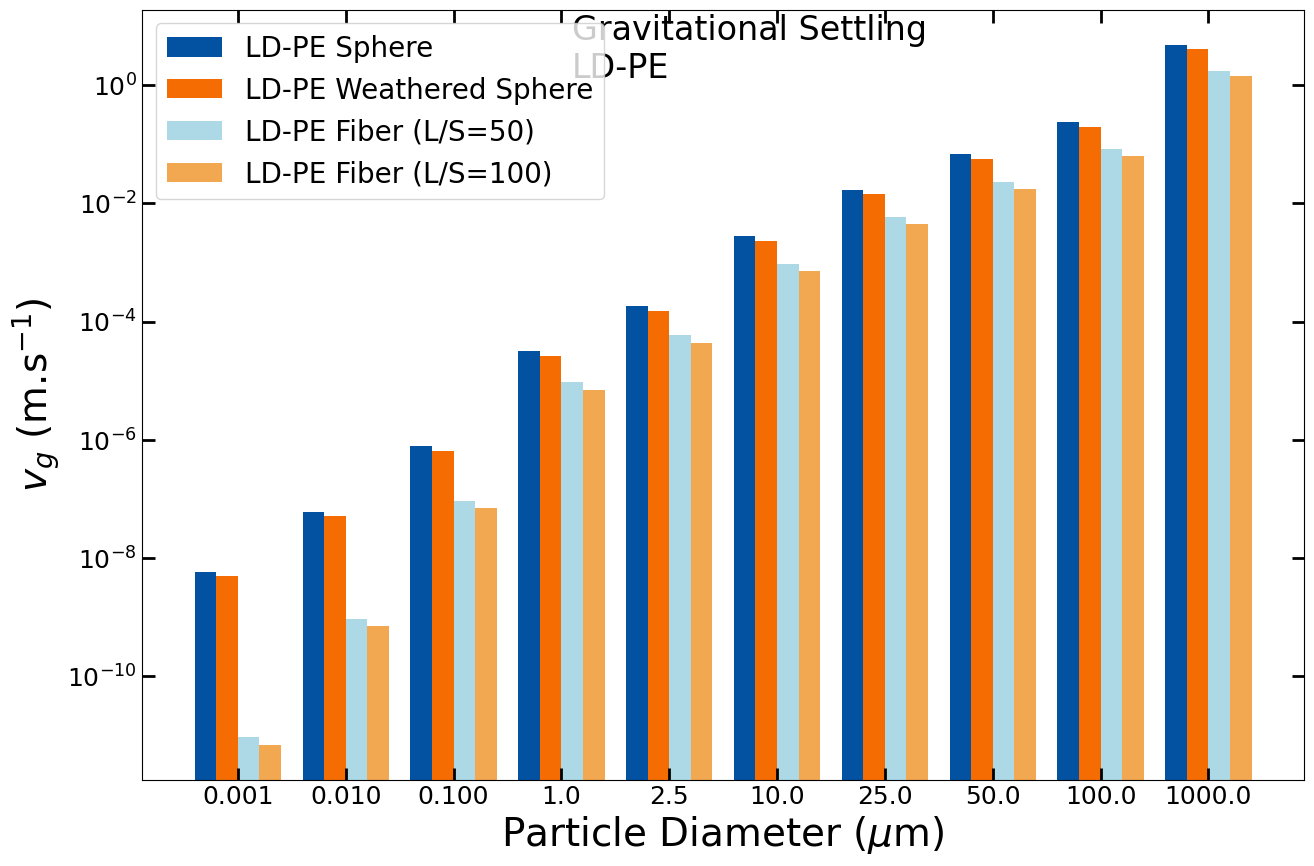

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']



fig = plt.figure(figsize=(15, 10))

d = particleDiameters

x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

#---
sorted_vgLDPE_Sphere = vgDry_LDPE[sorted_indices]
sorted_vgLDPE_Sphere_W = vgDry_LDPE_W[sorted_indices]

sorted_vgLDPE_F50 = vgDry_LDPE_F50[sorted_indices]
sorted_vgLDPE_F100 = vgDry_LDPE_F100[sorted_indices]

#---

# Calculate the bar positions
x = np.arange(len(d))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.2


# Create the bar plot


plt.bar(x- 0.3, sorted_vgLDPE_Sphere, width=bar_width, label='LD-PE Sphere', color=blue_colors[2])
plt.bar(x- 0.1, sorted_vgLDPE_Sphere_W, width=bar_width, label='LD-PE Weathered Sphere', color=orange_colors[2])
plt.bar(x+ 0.1, sorted_vgLDPE_F50, width=bar_width, label='LD-PE Fiber (L/S=50)', color=blue_colors[0])
plt.bar(x+ 0.3, sorted_vgLDPE_F100, width=bar_width, label='LD-PE Fiber (L/S=100)', color=orange_colors[0])

# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])

# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel(r'$\mathbf{\mathit{v_g}}$ (m.s$^{-1}$)', fontsize=28)
#plt.title("Residence Time at 1000 m \n for Spheric MNPs in PVC and LD-PE \n", fontsize=28)


plt.yscale('log')


#plt.ylim([7e1,4.5e9])


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Enable minor ticks and set their locations for the y-axis
ax = plt.gca()
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)


# Add legend
plt.legend(fontsize=20)

plt.text(3.1, 0.3, 'Gravitational Settling\nLD-PE\n', rotation='horizontal', fontsize=24)  # Position: (0.04, 0.5)

#plt.savefig('DryOnlyDeposition_Fiber_HalfeLife_'+ str(zfr)+'m.png', dpi=150, bbox_inches='tight')


In [15]:
# Luc5:  Mixed broadleaf and neadleaf trees
# Luc8:  Desert
# Luc13: InlandWater
# Luc15: Urban

## -------Sphere------------------------------------------------

# Urban

halfLife_urban_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_ufr2_LUC15_Neutral_LDPE / 3600.0
halfLife_urban_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_ufr15_LUC15_Neutral_LDPE / 3600.0

halfLife_urban_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_ufr2_LUC15_Neutral_PVC / 3600.0
halfLife_urban_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_ufr15_LUC15_Neutral_PVC / 3600.0

print('halfLife_urban_Neutral_ufr2_LDPE',halfLife_urban_Neutral_ufr2_LDPE)
print('halfLife_urban_Neutral_ufr15_LDPE',halfLife_urban_Neutral_ufr15_LDPE)
print('halfLife_urban_Neutral_ufr2_PVC',halfLife_urban_Neutral_ufr2_PVC)
print('halfLife_urban_Neutral_ufr15_PVC',halfLife_urban_Neutral_ufr15_PVC)

# Desert

halfLife_Desert_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_ufr2_LUC8_Neutral_LDPE / 3600.0
halfLife_Desert_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_ufr15_LUC8_Neutral_LDPE / 3600.0

halfLife_Desert_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_ufr2_LUC8_Neutral_PVC / 3600.0
halfLife_Desert_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_ufr15_LUC8_Neutral_PVC / 3600.0

# InlandWater

halfLife_inlandWater_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_ufr2_LUC13_Neutral_LDPE / 3600.0
halfLife_inlandWater_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_ufr15_LUC13_Neutral_LDPE / 3600.0

halfLife_inlandWater_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_ufr2_LUC13_Neutral_PVC / 3600.0
halfLife_inlandWater_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_ufr15_LUC13_Neutral_PVC / 3600.0

# Forest

halfLife_Forest_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_ufr2_LUC5_Neutral_LDPE / 3600.0
halfLife_Forest_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_ufr15_LUC5_Neutral_LDPE / 3600.0

halfLife_Forest_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_ufr2_LUC5_Neutral_PVC / 3600.0
halfLife_Forest_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_ufr15_LUC5_Neutral_PVC / 3600.0




## ------ Fiber -----------------------------------------------

# Urban

halfLife_Fiber100_urban_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE / 3600.0
halfLife_Fiber100_urban_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE / 3600.0

halfLife_Fiber100_urban_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC15_Neutral_PVC / 3600.0
halfLife_Fiber100_urban_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC15_Neutral_PVC / 3600.0


halfLife_Fiber50_urban_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC15_Neutral_LDPE / 3600.0
halfLife_Fiber50_urban_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC15_Neutral_LDPE / 3600.0

halfLife_Fiber50_urban_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC15_Neutral_PVC / 3600.0
halfLife_Fiber50_urban_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC15_Neutral_PVC / 3600.0

print('halfLife_Fiber100_urban_Neutral_ufr2_LDPE',halfLife_Fiber100_urban_Neutral_ufr2_LDPE)
print('halfLife_Fiber100_urban_Neutral_ufr15_LDPE',halfLife_Fiber100_urban_Neutral_ufr15_LDPE)
print('halfLife_Fiber100_urban_Neutral_ufr2_PVC',halfLife_Fiber100_urban_Neutral_ufr2_PVC)
print('halfLife_Fiber100_urban_Neutral_ufr15_PVC',halfLife_Fiber100_urban_Neutral_ufr15_PVC)

# Desert

halfLife_Fiber100_Desert_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE / 3600.0
halfLife_Fiber100_Desert_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE / 3600.0

halfLife_Fiber100_Desert_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC8_Neutral_PVC / 3600.0
halfLife_Fiber100_Desert_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC8_Neutral_PVC / 3600.0


halfLife_Fiber50_Desert_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC8_Neutral_LDPE / 3600.0
halfLife_Fiber50_Desert_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC8_Neutral_LDPE / 3600.0

halfLife_Fiber50_Desert_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC8_Neutral_PVC / 3600.0
halfLife_Fiber50_Desert_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC8_Neutral_PVC / 3600.0

# InlandWater
halfLife_Fiber100_inlandWater_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE / 3600.0
halfLife_Fiber100_inlandWater_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE / 3600.0

halfLife_Fiber100_inlandWater_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC13_Neutral_PVC / 3600.0
halfLife_Fiber100_inlandWater_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC13_Neutral_PVC / 3600.0


halfLife_Fiber50_inlandWater_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC13_Neutral_LDPE / 3600.0
halfLife_Fiber50_inlandWater_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC13_Neutral_LDPE / 3600.0

halfLife_Fiber50_inlandWater_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC13_Neutral_PVC / 3600.0
halfLife_Fiber50_inlandWater_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC13_Neutral_PVC / 3600.0

print('halfLife_Fiber100_inlandWater_Neutral_ufr2_LDPE',halfLife_Fiber100_inlandWater_Neutral_ufr2_LDPE)
print('halfLife_Fiber100_inlandWater_Neutral_ufr15_LDPE',halfLife_Fiber100_inlandWater_Neutral_ufr15_LDPE)
print('halfLife_Fiber100_inlandWater_Neutral_ufr2_PVC',halfLife_Fiber100_inlandWater_Neutral_ufr2_PVC)
print('halfLife_Fiber100_inlandWater_Neutral_ufr15_PVC',halfLife_Fiber100_inlandWater_Neutral_ufr15_PVC)

# Forest

halfLife_Fiber100_Forest_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE / 3600.0
halfLife_Fiber100_Forest_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE / 3600.0

halfLife_Fiber100_Forest_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr2_LUC5_Neutral_PVC / 3600.0
halfLife_Fiber100_Forest_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber100_ufr15_LUC5_Neutral_PVC / 3600.0


halfLife_Fiber50_Forest_Neutral_ufr2_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC5_Neutral_LDPE / 3600.0
halfLife_Fiber50_Forest_Neutral_ufr15_LDPE = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC5_Neutral_LDPE / 3600.0

halfLife_Fiber50_Forest_Neutral_ufr2_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr2_LUC5_Neutral_PVC / 3600.0
halfLife_Fiber50_Forest_Neutral_ufr15_PVC = 0.693 * 1000.0 / vdDry_Fiber50_ufr15_LUC5_Neutral_PVC / 3600.0

'''shape = 1.70

# Urban

halfLife_Fiber_urban_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC15_Neutral_LDPE / 3600.0
halfLife_Fiber_urban_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC15_Neutral_LDPE / 3600.0

halfLife_Fiber_urban_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC15_Neutral_PVC / 3600.0
halfLife_Fiber_urban_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC15_Neutral_PVC / 3600.0


# Desert

halfLife_Fiber_Desert_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC8_Neutral_LDPE / 3600.0
halfLife_Fiber_Desert_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC8_Neutral_LDPE / 3600.0

halfLife_Fiber_Desert_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC8_Neutral_PVC / 3600.0
halfLife_Fiber_Desert_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC8_Neutral_PVC / 3600.0

# InlandWater

halfLife_Fiber_inlandWater_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC13_Neutral_LDPE / 3600.0
halfLife_Fiber_inlandWater_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC13_Neutral_LDPE / 3600.0

halfLife_Fiber_inlandWater_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC13_Neutral_PVC / 3600.0
halfLife_Fiber_inlandWater_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC13_Neutral_PVC / 3600.0

# Forest

halfLife_Fiber_Forest_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC5_Neutral_LDPE / 3600.0
halfLife_Fiber_Forest_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC5_Neutral_LDPE / 3600.0

halfLife_Fiber_Forest_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC5_Neutral_PVC / 3600.0
halfLife_Fiber_Forest_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC5_Neutral_PVC / 3600.0
'''



halfLife_urban_Neutral_ufr2_LDPE [2.07515996e+01 2.48827522e+01 7.16856469e+01 3.15653101e+02
 3.74475206e+02 6.56558937e+01 1.05952847e+01 2.62904417e+00
 7.81556634e-01 3.99129904e-02]
halfLife_urban_Neutral_ufr15_LDPE [2.76689305e+00 3.31820470e+00 9.58032712e+00 4.48040263e+01
 7.27380377e+01 1.34681308e+01 2.74086364e+00 1.46643114e+00
 6.44523776e-01 3.99592246e-02]
halfLife_urban_Neutral_ufr2_PVC [2.07516055e+01 2.48832574e+01 7.16971707e+01 3.05192716e+02
 3.00095868e+02 3.87053038e+01 6.07896206e+00 1.55797639e+00
 4.75414625e-01 3.04631247e-02]
halfLife_urban_Neutral_ufr15_PVC [2.76689854e+00 3.31843824e+00 9.58978630e+00 4.49002521e+01
 6.73994291e+01 7.00025210e+00 2.16679675e+00 1.06906699e+00
 4.26996980e-01 3.04841051e-02]
halfLife_Fiber100_urban_Neutral_ufr2_LDPE [2.07515647e+01 2.48810922e+01 7.16449320e+01 3.27178697e+02
 5.04333630e+02 2.24784847e+02 4.22413739e+01 1.05191552e+01
 2.79283313e+00 1.35517902e-01]
halfLife_Fiber100_urban_Neutral_ufr15_LDPE [ 2.76687569 

'shape = 1.70\n\n# Urban\n\nhalfLife_Fiber_urban_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC15_Neutral_LDPE / 3600.0\nhalfLife_Fiber_urban_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC15_Neutral_LDPE / 3600.0\n\nhalfLife_Fiber_urban_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC15_Neutral_PVC / 3600.0\nhalfLife_Fiber_urban_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC15_Neutral_PVC / 3600.0\n\n\n# Desert\n\nhalfLife_Fiber_Desert_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC8_Neutral_LDPE / 3600.0\nhalfLife_Fiber_Desert_Neutral_ufr15_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC8_Neutral_LDPE / 3600.0\n\nhalfLife_Fiber_Desert_Neutral_ufr2_PVC = 0.693 * 1000.0 * shape / vdDry_ufr2_LUC8_Neutral_PVC / 3600.0\nhalfLife_Fiber_Desert_Neutral_ufr15_PVC = 0.693 * 1000.0 * shape / vdDry_ufr15_LUC8_Neutral_PVC / 3600.0\n\n# InlandWater\n\nhalfLife_Fiber_inlandWater_Neutral_ufr2_LDPE = 0.693 * 1000.0 * shape / vdDry_ufr2_LU

[2.07515996e+01 2.48827522e+01 7.16856469e+01 3.15653101e+02
 3.74475206e+02 6.56558937e+01 1.05952847e+01 2.62904417e+00
 7.81556634e-01 3.99129904e-02]
[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


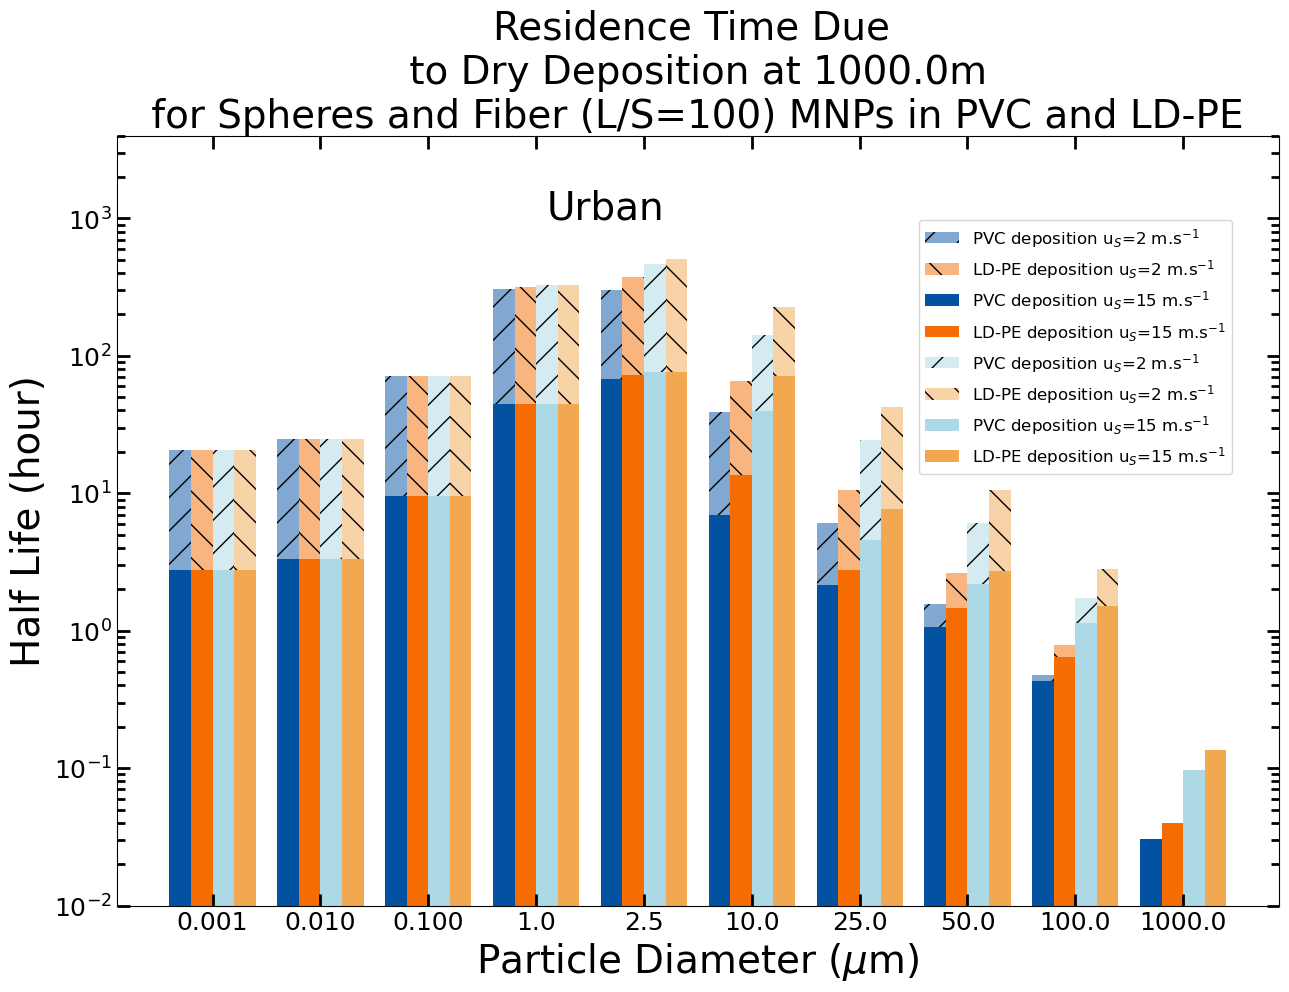

In [16]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']

# Spring Pastel: Orange, Blue, Green, Violet, orange light, Lavand,pink,  
Spring_Pastels = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"] 

colorsChoice = Spring_Pastels


d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

print(halfLife_urban_Neutral_ufr2_LDPE)
sorted_HalfLifeLDPE_us_2_Urban = halfLife_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Urban = halfLife_urban_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_Urban = halfLife_urban_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Urban = halfLife_urban_Neutral_ufr15_PVC[sorted_indices]


sorted_Fiber_HalfLifePVC_us_2_Urban = halfLife_Fiber100_urban_Neutral_ufr2_PVC[sorted_indices]
sorted_Fiber_HalfLifePVC_us_15_Urban = halfLife_Fiber100_urban_Neutral_ufr15_PVC[sorted_indices]

sorted_Fiber_HalfLifeLDPE_us_2_Urban = halfLife_Fiber100_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_Fiber_HalfLifeLDPE_us_15_Urban = halfLife_Fiber100_urban_Neutral_ufr15_LDPE[sorted_indices]



# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.2

# Create the bar plot

plt.bar(x- 0.3, sorted_HalfLifePVC_us_2_Urban, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_2_Urban, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x- 0.3, sorted_HalfLifePVC_us_15_Urban, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_15_Urban, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])

plt.bar(x+ 0.1, sorted_Fiber_HalfLifePVC_us_2_Urban, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber_HalfLifeLDPE_us_2_Urban, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x+ 0.1, sorted_Fiber_HalfLifePVC_us_15_Urban, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber_HalfLifeLDPE_us_15_Urban, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])



plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])

# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])


# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel('Half Life (hour)', fontsize=28)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Spheres and Fiber (L/S=100) MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Enable minor ticks and set their locations for the y-axis
ax = plt.gca()
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)

# Add legend at specific coordinates
legend_x = 0.69 # x-coordinate of the legend
legend_y = 0.56 # y-coordinate of the legend
plt.legend(fontsize=12, loc=(legend_x, legend_y))

plt.text(3.1e0, 1.0e3, 'Urban', rotation='horizontal', fontsize=28)  # Position: (0.04, 0.5)

plt.savefig('DryOnlyDeposition_Fiber_HalfeLife_Urban_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


[1.17941931e+02 1.27508945e+02 2.10688738e+02 5.63483933e+02
 6.59008885e+02 1.45514595e+02 2.54057313e+01 6.56964038e+00
 1.81082242e+00 9.66850996e-02]
[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


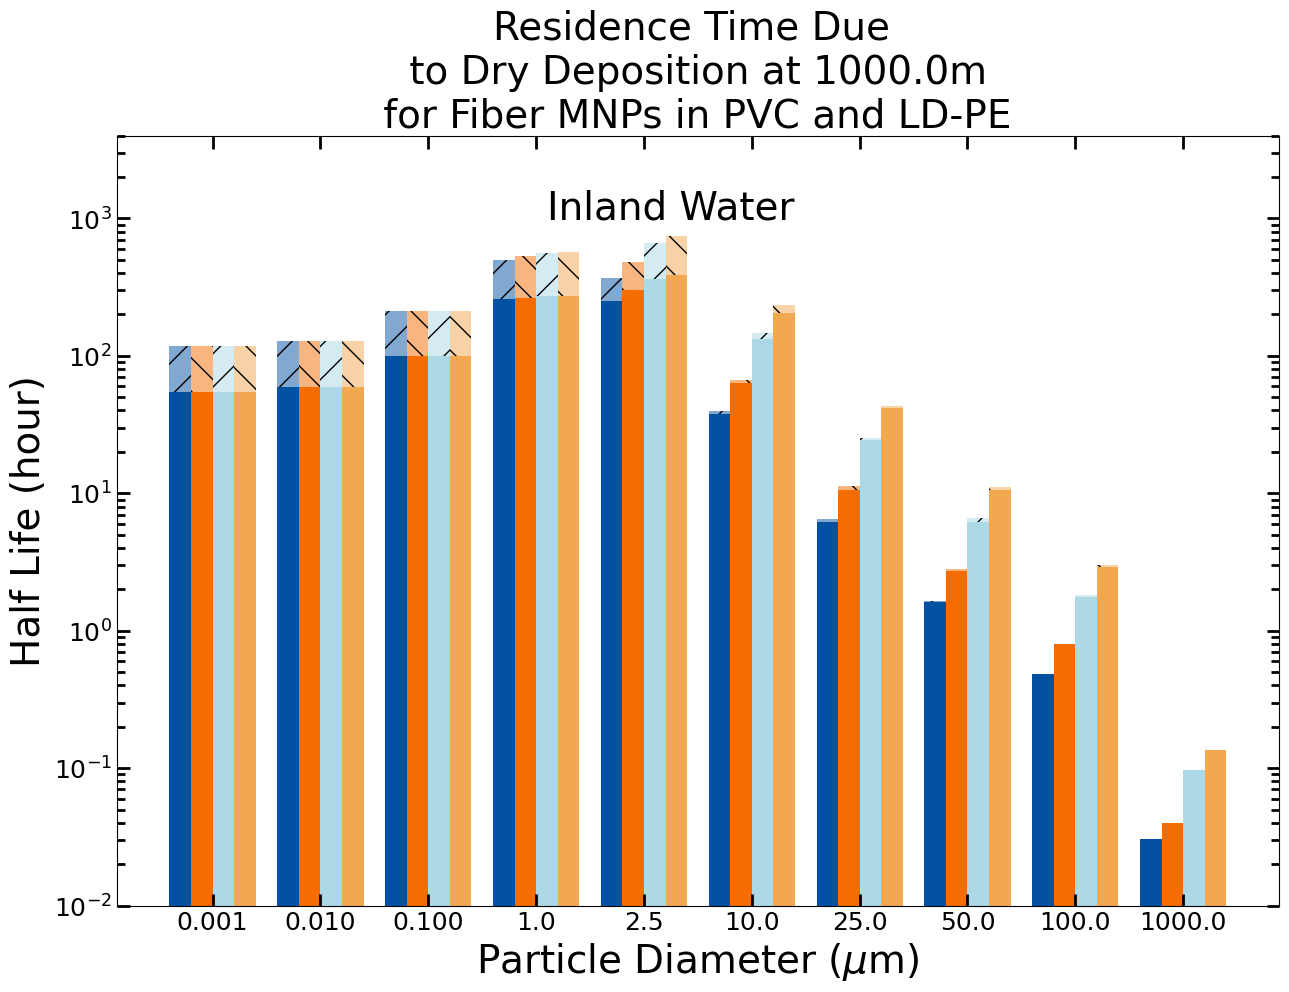

In [17]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']


d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

print(halfLife_Fiber100_inlandWater_Neutral_ufr2_PVC)
sorted_Fiber100_HalfLifePVC_us_2_InLandWater = halfLife_Fiber100_inlandWater_Neutral_ufr2_PVC[sorted_indices]
sorted_Fiber100_HalfLifePVC_us_15_InLandWater = halfLife_Fiber100_inlandWater_Neutral_ufr15_PVC[sorted_indices]

sorted_Fiber100_HalfLifeLDPE_us_2_InLandWater = halfLife_Fiber100_inlandWater_Neutral_ufr2_LDPE[sorted_indices]
sorted_Fiber100_HalfLifeLDPE_us_15_InLandWater = halfLife_Fiber100_inlandWater_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_InLandWater = halfLife_inlandWater_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_InLandWater = halfLife_inlandWater_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_InLandWater = halfLife_inlandWater_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_InLandWater = halfLife_inlandWater_Neutral_ufr15_LDPE[sorted_indices]

# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.2

# Create the bar plot

plt.bar(x- 0.3, sorted_HalfLifePVC_us_2_InLandWater, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_2_InLandWater, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x- 0.3, sorted_HalfLifePVC_us_15_InLandWater, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_15_InLandWater, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])

plt.bar(x+ 0.1, sorted_Fiber100_HalfLifePVC_us_2_InLandWater, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber100_HalfLifeLDPE_us_2_InLandWater, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x+ 0.1, sorted_Fiber100_HalfLifePVC_us_15_InLandWater, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber100_HalfLifeLDPE_us_15_InLandWater, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])


'''plt.bar(x- 0.075, sorted_HalfLifePVC_us_2_InLandWater, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_2_InLandWater, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[1])

plt.bar(x- 0.075, sorted_HalfLifePVC_us_15_InLandWater, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_15_InLandWater, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[1])


plt.bar(x+ 0.225, sorted_HalfLifePVC_us_2_Heavy, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_2_Heavy, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x+ 0.225, sorted_HalfLifePVC_us_15_Heavy, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_15_Heavy, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])
'''


plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])

# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])

# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel('Half Life (hour)', fontsize=28)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Fiber MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Enable minor ticks and set their locations for the y-axis
ax = plt.gca()
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1.0e3, 'Inland Water', rotation='horizontal', fontsize=28)  # Position: (0.04, 0.5)

plt.savefig('DryOnlyDeposition_Fiber_HalfeLife_InlandWater_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


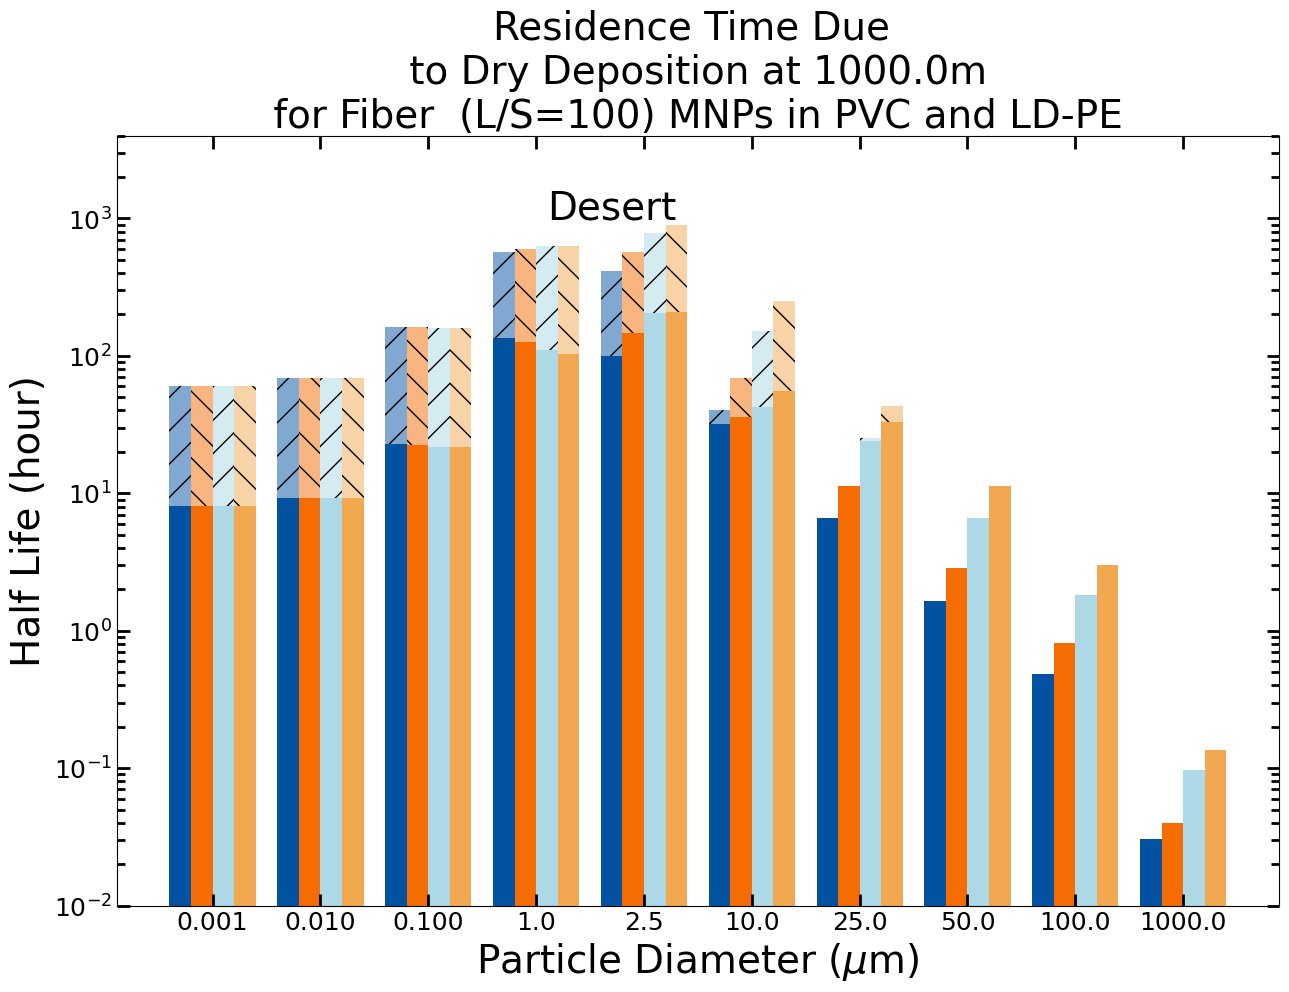

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']


d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_Fiber100_HalfLifePVC_us_2_Desert = halfLife_Fiber100_Desert_Neutral_ufr2_PVC[sorted_indices]
sorted_Fiber100_HalfLifePVC_us_15_Desert = halfLife_Fiber100_Desert_Neutral_ufr15_PVC[sorted_indices]

sorted_Fiber100_HalfLifeLDPE_us_2_Desert = halfLife_Fiber100_Desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_Fiber100_HalfLifeLDPE_us_15_Desert = halfLife_Fiber100_Desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_Desert = halfLife_Desert_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Desert = halfLife_Desert_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Desert = halfLife_Desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Desert = halfLife_Desert_Neutral_ufr15_LDPE[sorted_indices]

# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.2

# Create the bar plot

plt.bar(x- 0.3, sorted_HalfLifePVC_us_2_Desert, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_2_Desert, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x- 0.3, sorted_HalfLifePVC_us_15_Desert, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_15_Desert, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])

plt.bar(x+ 0.1, sorted_Fiber100_HalfLifePVC_us_2_Desert, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber100_HalfLifeLDPE_us_2_Desert, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x+ 0.1, sorted_Fiber100_HalfLifePVC_us_15_Desert, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber100_HalfLifeLDPE_us_15_Desert, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])


plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])


# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel('Half Life (hour)', fontsize=28)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Fiber  (L/S=100) MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Enable minor ticks and set their locations for the y-axis
ax = plt.gca()
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)
# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1.0e3, 'Desert', rotation='horizontal', fontsize=28)  # Position: (0.04, 0.5)

plt.savefig('DryOnlyDeposition_Fiber_HalfeLife_Desert_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


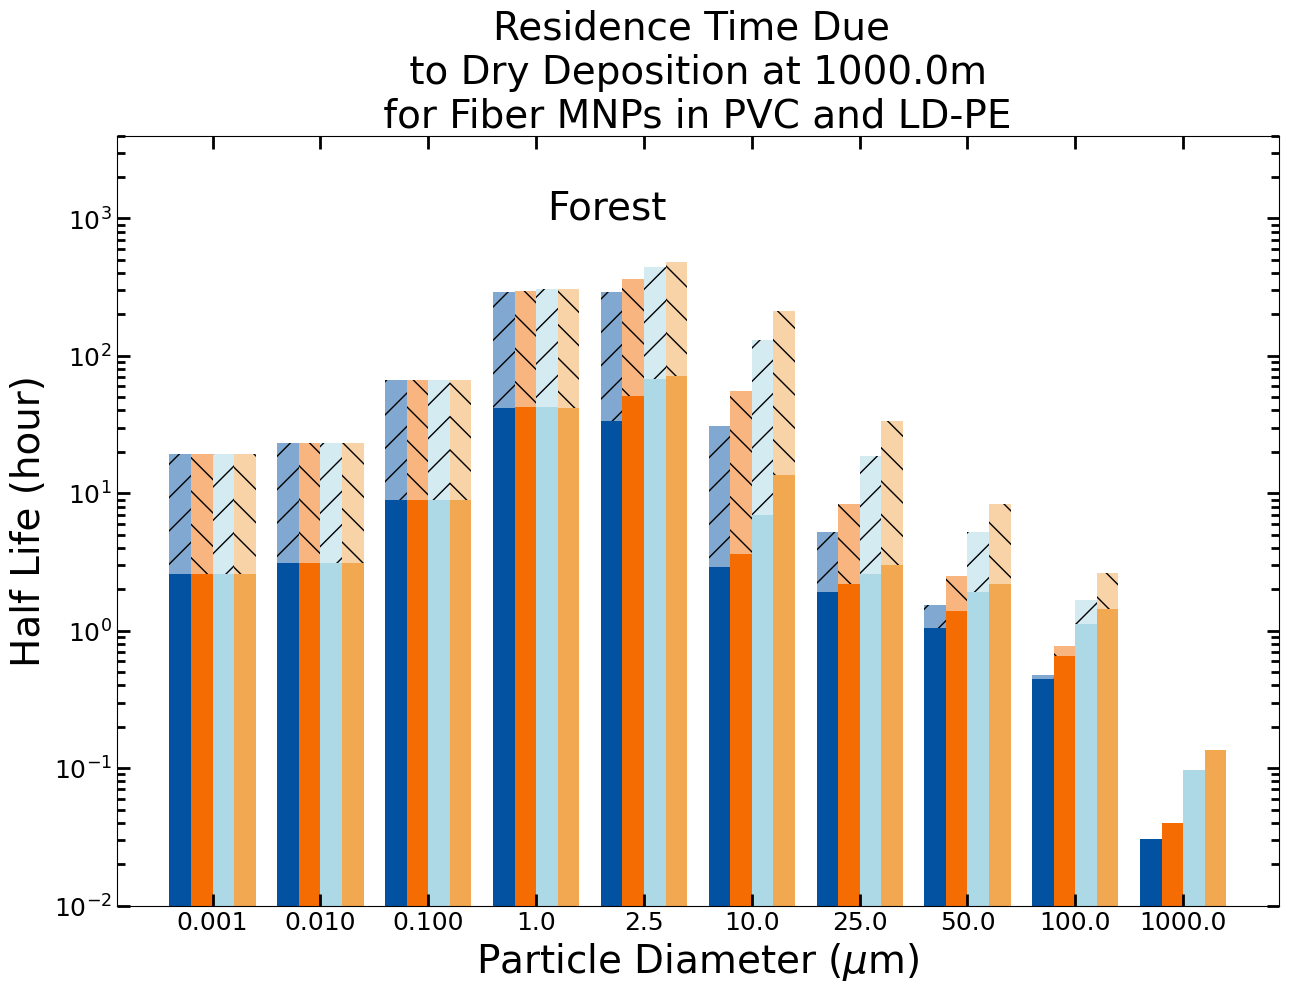

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']


d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_Fiber_HalfLifePVC_us_2_Forest = halfLife_Fiber100_Forest_Neutral_ufr2_PVC[sorted_indices]
sorted_Fiber_HalfLifePVC_us_15_Forest = halfLife_Fiber100_Forest_Neutral_ufr15_PVC[sorted_indices]

sorted_Fiber_HalfLifeLDPE_us_2_Forest = halfLife_Fiber100_Forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_Fiber_HalfLifeLDPE_us_15_Forest = halfLife_Fiber100_Forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_Forest = halfLife_Forest_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Forest = halfLife_Forest_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Forest = halfLife_Forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Forest = halfLife_Forest_Neutral_ufr15_LDPE[sorted_indices]

# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.2

# Create the bar plot

plt.bar(x- 0.3, sorted_HalfLifePVC_us_2_Forest, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_2_Forest, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x- 0.3, sorted_HalfLifePVC_us_15_Forest, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x- 0.1, sorted_HalfLifeLDPE_us_15_Forest, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])

plt.bar(x+ 0.1, sorted_Fiber_HalfLifePVC_us_2_Forest, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber_HalfLifeLDPE_us_2_Forest, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x+ 0.1, sorted_Fiber_HalfLifePVC_us_15_Forest, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x+ 0.3, sorted_Fiber_HalfLifeLDPE_us_15_Forest, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])


plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])


# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel('Half Life (hour)', fontsize=28)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Fiber MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Enable minor ticks and set their locations for the y-axis
ax = plt.gca()
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1.0e3, 'Forest', rotation='horizontal', fontsize=28)  # Position: (0.04, 0.5)

plt.savefig('DryOnlyDeposition_Fiber_HalfeLife_Forest_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


## Dry + Wet Bellow clouds

### Validation of half-life computation-> ln2/(kdry+kwet) is better as no curve aproximations

In [20]:
# 1
#  0.50 mm.h-1: drizzle
#  2.50 mm.h-1: moderate
# 10.00 mm.h-1: very heavy

Rain_Int_mmh = np.array([0.5, 2.5, 10.0]) #mm h−1

#particleDiameters=np.array([0.1e-6, 1.0e-6, 10.0e-6, 20.0e-6, 50.0e-6, 70.0e-6, 100.0e-6, 500.0e-6, 1000.0e-6])
particleDiameters=np.array([0.001e-6, 0.01e-6, 0.1e-6, 1.0e-6, 2.5e-6, 10.0e-6, 25.0e-6, 50.0e-6, 100.0e-6, 1000.0e-6])



#Conversion of rain intensity from mm.h-1 to m.s-1
Rain_Int = rainIntensity_mm_by_h_To_m_by_s (Rain_Int_mmh)

#Calculate the size of the rain droplet
Dp = rainDropSize (Rain_Int)
print("Dp: ")
print(Dp)


RH = 0.8 

Cini = 15.0
# Create C0 array with same size as particleDiameter and initialize all values to Cini
C0 = np.full_like(particleDiameters, Cini)

P_Air =  898.7 * 100.0 #[Pa] 1000 m heigth, 898.7 hPa
height = 1000.0

#P_Air =  954.6 * 100.0 #[Pa]  500 m heigth, 954.6 hPa
#height = 500

#P_Air = 1001.3 * 100.0 #[Pa]  100 m heigth, 1001.3 hPa
#height = 100

#P_Air = 1012.0 * 100.0 #[Pa]    10 m heigth, 1012.0 hPa
#height = 10

T_Air = 25.0 + 273.15 #[K]
RH = 0.8 
particleName = 'HDPE'
rhoParticle = rhoHDPE
kpParticle = kpHDPE
alpha = 2.0
shape = 1.0 # Shape 1.0 for sphere and fibers, as fibers are calculated specifically.

t = np.arange(0.0, 500.0*3600.0, 3600.0*0.025) # [s] arrange for values of delta t, linspace for a number linspace ;) 
th = t/3600
Eeff = collectionEfficiency_SlinnPhiCharge(Dp, RH, 
                                         particleDiameters, rhoParticle, kpParticle,
                                         alpha,
                                         P_Air, T_Air)


print ('Eeff')
print (Eeff)


# Scavenging coefficient
Scavenging = (3.0 / 2.0) * Eeff * Rain_Int / Dp

Scavenging = np.transpose(Scavenging)
print("scavenging")
print(Scavenging)
print("VDry",vdDry_ufr2_LUC15_Neutral_LDPE)



def WetAndDrySettling (C, t, Scavenging, vdDry, heigth, shape):
    #Tested in different way
    
    # Rate of change of concentration of C due to bellow wet settling
    #dCdt_wet = -Scavenging * C
    
    # Rate of change of concentration of C due to dry settling, modified by wet reaction
    #dCdt_dry = -(vdDry /(heigth * shape)) * (C)

    # Total rate of change of concentration of C
    #dCdt = dCdt_wet + dCdt_dry
    
    dCdt = -(Scavenging + vdDry /(heigth * shape)) * C
    
    return dCdt




# Drizzle calculation LDPE
Cd_d0_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[0],heigth,shape))
Cd_d1_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[1],heigth,shape))
Cd_d2_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[2],heigth,shape))
Cd_d3_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[3],heigth,shape))
Cd_d4_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[4],heigth,shape))
Cd_d5_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[5],heigth,shape))
Cd_d6_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[6],heigth,shape))
Cd_d7_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[7],heigth,shape))
Cd_d8_RI_drizzle_urban_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE[8],heigth,shape))


limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_urban_Neutral_ufr2_LDPE <= limit)])


halfLife_RI_drizzle_urban_Neutral_ufr2_LDPE = halfLife

print()
print(np.log(2.0))
ln2 = np.log(2.0)

kdry = vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kwet = Scavenging[0,:]


print('---------------------------------')
print(' --> halfLife_CalculatewithODE', halfLife_RI_drizzle_urban_Neutral_ufr2_LDPE)

print('--> Half Life calculate with ln2/(kdry+kwet)', ln2/(kdry+kwet)/3600)




Dp: 
[0.00086938 0.0011211  0.00139563]
91.3660280788266 0.0008693786985823227
147.5582738435722 0.0011211049126418119
215.33482961488474 0.0013956346209081701
Eeff
[[1.75875812e-01 1.33773846e-01 1.08312537e-01]
 [1.25042873e-02 9.58390522e-03 7.80169118e-03]
 [1.66368299e-03 1.26961204e-03 1.03285951e-03]
 [1.53331543e-03 1.18639491e-03 9.78073414e-04]
 [3.10332957e-03 2.41476732e-03 1.98886902e-03]
 [6.90817296e-01 6.81427515e-01 6.64032259e-01]
 [1.02323501e+00 1.00158245e+00 9.84272524e-01]
 [1.28647371e+00 1.21368426e+00 1.16281949e+00]
 [2.13262008e+00 1.85810378e+00 1.66728503e+00]
 [1.07182341e+02 8.20701880e+01 6.38066359e+01]]
scavenging
[[4.21459534e-05 2.99646155e-06 3.98676231e-07 3.67435635e-07
  7.43665556e-07 1.65543819e-04 2.45202648e-04 3.08283786e-04
  5.11049846e-04 2.56846118e-02]
 [1.24295019e-04 8.90481747e-06 1.17965101e-06 1.10233041e-06
  2.24366391e-06 6.33143536e-04 9.30613215e-04 1.12768611e-03
  1.72644393e-03 7.62549322e-02]
 [3.23367042e-04 2.32919463e-

### Computation of half lifes in dry+wet conditions

In [21]:
# Rain Intensity
#  0.50 mm.h-1: drizzle
#  2.50 mm.h-1: moderate
# 10.00 mm.h-1: very heavy

Rain_Int_mmh = np.array([0.5, 2.5, 10.0]) #mm h−1

#particleDiameters=np.array([0.1e-6, 1.0e-6, 10.0e-6, 20.0e-6, 50.0e-6, 70.0e-6, 100.0e-6, 500.0e-6, 1000.0e-6])
particleDiameters=np.array([0.001e-6, 0.01e-6, 0.1e-6, 1.0e-6, 2.5e-6, 10.0e-6, 25.0e-6, 50.0e-6, 100.0e-6, 1000.0e-6])


#Conversion of rain intensity from mm.h-1 to m.s-1
Rain_Int = rainIntensity_mm_by_h_To_m_by_s (Rain_Int_mmh)

#Calculate the size of the rain droplet
Dp = rainDropSize (Rain_Int)
#print("Dp: ")
#print(Dp)


RH = 0.8 

Cini = 15.0
# Create C0 array with same size as particleDiameter and initialize all values to Cini
C0 = np.full_like(particleDiameters, Cini)

P_Air =  898.7 * 100.0 #[Pa] 1000 m heigth, 898.7 hPa
height = 1000.0

#P_Air =  954.6 * 100.0 #[Pa]  500 m heigth, 954.6 hPa
#height = 500

#P_Air = 1001.3 * 100.0 #[Pa]  100 m heigth, 1001.3 hPa
#height = 100

#P_Air = 1012.0 * 100.0 #[Pa]    10 m heigth, 1012.0 hPa
#height = 10

T_Air = 25.0 + 273.15 #[K]
RH = 0.8 
particleName = 'HDPE'
rhoParticle = rhoHDPE
kpParticle = kpHDPE
alpha = 2.0
shape = 1.0 # Shape 1.0 for sphere and fibers, as fibers are calculated specifically.

t = np.arange(0.0, 500.0*3600.0, 3600.0*0.025) # [s] arrange for values of delta t, linspace for a number linspace ;) 
th = t/3600
Eeff = collectionEfficiency_SlinnPhiCharge(Dp, RH, 
                                         particleDiameters, rhoParticle, kpParticle,
                                         alpha,
                                         P_Air, T_Air)


#print ('Eeff')
#print (Eeff)


# Scavenging coefficient
Scavenging = (3.0 / 2.0) * Eeff * Rain_Int / Dp

Scavenging = np.transpose(Scavenging)
#print("scavenging")
#print(Scavenging)
#print("VDry",vdDry_ufr2_LUC15_Neutral_LDPE)







91.3660280788266 0.0008693786985823227
147.5582738435722 0.0011211049126418119
215.33482961488474 0.0013956346209081701


## No rain in Desert vs Forest vs Urban vs In Land

In [22]:
# A) ------- No Rain Intensity (0.0 mm.h-1): ----------------------------------------------


#------------------------------------------

## B) ---- Forest (LUC5) ----

### C1) -- LD_PE --

# Smooth Spheres
shape = 1.0
kdry2 = vdDry_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_Zero_forest_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_forest_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

# Fibers (A/R=100)

kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE /heigth
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE /heigth

halfLife_Fiber_RI_Zero_forest_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_forest_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_PVC /(heigth * shape)


halfLife_Sphere_RI_Zero_forest_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_forest_Neutral_ufr15_PVC = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_Zero_forest_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_forest_Neutral_ufr15_PVC = ln2/(kdry15)/3600

#------------------------------------------

## B) ---- desert (LUC8) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_Zero_desert_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_desert_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_Zero_desert_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_desert_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_Zero_desert_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_desert_Neutral_ufr15_PVC = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_Zero_desert_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_desert_Neutral_ufr15_PVC = ln2/(kdry15)/3600

#------------------------------------------

## B) ---- Urban (LUC15) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_Zero_urban_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_urban_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_Zero_urban_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_urban_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_Zero_urban_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_urban_Neutral_ufr15_PVC = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_Zero_urban_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_urban_Neutral_ufr15_PVC = ln2/(kdry15)/3600

#------------------------------------------

## B) ---- Inland Water(LUC13) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_Zero_inland_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_inland_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_Zero_inland_Neutral_ufr2_LDPE = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_inland_Neutral_ufr15_LDPE = ln2/(kdry15)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_Zero_inland_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Sphere_RI_Zero_inland_Neutral_ufr15_PVC = ln2/(kdry15)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_Zero_inland_Neutral_ufr2_PVC = ln2/(kdry2)/3600
halfLife_Fiber_RI_Zero_inland_Neutral_ufr15_PVC = ln2/(kdry15)/3600

## Drizzle in Desert vs Forest vs Urban vs In Land

In [23]:
print(heigth)

1000.0


In [24]:
# A) ------- Drizzle Rain Intensity (0.50 mm.h-1): ----------------------------------------------

kwet = Scavenging[0,:]

#------------------------------------------

## B) ---- Forest (LUC5) ----

### C1) -- LD_PE --

# Smooth Spheres
shape = 1.0
kdry2 = vdDry_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_drizzle_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)

kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE /heigth
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE /heigth

halfLife_Fiber_RI_drizzle_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_PVC /(heigth * shape)



halfLife_Sphere_RI_drizzle_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_drizzle_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- desert (LUC8) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_drizzle_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_drizzle_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_drizzle_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_drizzle_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- Urban (LUC15) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_drizzle_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_drizzle_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_drizzle_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_drizzle_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- Inland Water(LUC13) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_drizzle_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_drizzle_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_drizzle_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_drizzle_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_drizzle_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_drizzle_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

## Moderate Rain in Desert vs Forest

In [25]:
# A) ------- Moderate Rain Intensity (2.50 mm.h-1): ----------------------------------------------

kwet = Scavenging[1,:]

#------------------------------------------

## B) ---- Forest (LUC5) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_moderate_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_moderate_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_moderate_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_moderate_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- desert (LUC8) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_moderate_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE /(heigth * shape)


halfLife_Fiber_RI_moderate_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_moderate_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_moderate_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- urban (LUC15) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_moderate_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE /(heigth * shape)


halfLife_Fiber_RI_moderate_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_moderate_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_moderate_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600


#------------------------------------------

## B) ---- inland (LUC13) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_moderate_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE /(heigth * shape)


halfLife_Fiber_RI_moderate_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_moderate_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_moderate_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_moderate_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_moderate_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

## Very Heavy Rain in Desert vs Forest

In [26]:
# A) ------- Very Heavy Rain Intensity (10.0 mm.h-1): ----------------------------------------------

kwet = Scavenging[2,:]

#------------------------------------------

## B) ---- Forest (LUC5) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC5_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC5_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- desert (LUC8) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC8_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC8_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- urban (LUC15) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC15_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC15_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

#------------------------------------------

## B) ---- inland (LUC13) ----

### C1) -- LD_PE --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr2_LDPE = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr15_LDPE = ln2/(kdry15+kwet)/3600

### C2) -- PVC --

# Smooth Spheres
kdry2 = vdDry_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

# Fibers (A/R=100)
kdry2 = vdDry_Fiber100_ufr2_LUC13_Neutral_PVC /(heigth * shape)
kdry15 = vdDry_Fiber100_ufr15_LUC13_Neutral_PVC /(heigth * shape)

halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr2_PVC = ln2/(kdry2+kwet)/3600
halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr15_PVC = ln2/(kdry15+kwet)/3600

## Figures Desert vs Forest vs Urban vs Inland Water

[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


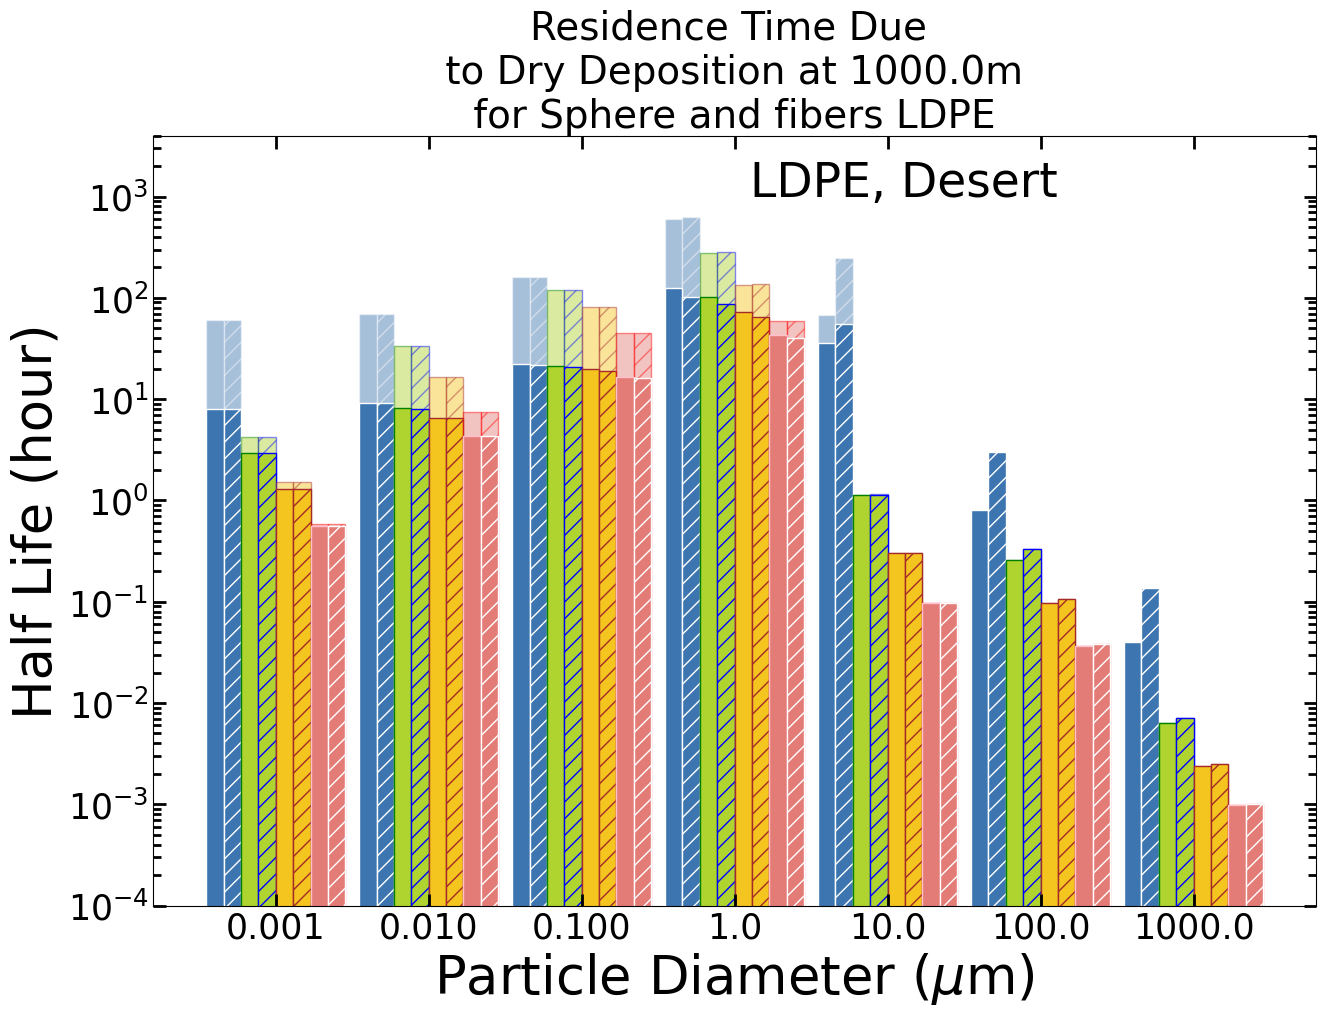

In [27]:
#Desert:

import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']

tri_colors = [ '#3c75af','#afd42f','#f4c41f', '#e37c77']

d = particleDiameters

fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_HalfLifeLDPE_us_2_Zero = halfLife_Sphere_RI_Zero_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Zero = halfLife_Sphere_RI_Zero_desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = halfLife_Fiber_RI_Zero_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = halfLife_Fiber_RI_Zero_desert_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_Sphere_RI_drizzle_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_Sphere_RI_drizzle_desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = halfLife_Fiber_RI_drizzle_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = halfLife_Fiber_RI_drizzle_desert_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Moderate = halfLife_Sphere_RI_moderate_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_Sphere_RI_moderate_desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = halfLife_Fiber_RI_moderate_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = halfLife_Fiber_RI_moderate_desert_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Heavy = halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy =halfLife_Sphere_RI_veryHeavy_desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = halfLife_Fiber_RI_veryHeavy_desert_Neutral_ufr15_LDPE[sorted_indices]





# Select just some particle size for a better visibility
indices = [0, 1, 2, 3, 5, 8, 9]

sorted_d = np.array(sorted_d)[indices]

sorted_HalfLifeLDPE_us_2_Zero = np.array(sorted_HalfLifeLDPE_us_2_Zero)[indices]
sorted_HalfLifeLDPE_us_15_Zero = np.array(sorted_HalfLifeLDPE_us_15_Zero)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Zero)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Zero)[indices]


sorted_HalfLifeLDPE_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_us_15_Drizzle)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Drizzle)[indices]


sorted_HalfLifeLDPE_us_2_Moderate = np.array(sorted_HalfLifeLDPE_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_us_15_Moderate = np.array(sorted_HalfLifeLDPE_us_15_Moderate)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Moderate)[indices]


sorted_HalfLifeLDPE_us_2_Heavy = np.array(sorted_HalfLifeLDPE_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_us_15_Heavy =np.array(sorted_HalfLifeLDPE_us_15_Heavy)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Heavy)[indices]








# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)



# Set the new bar width
num_bars = 8  # Total number of bars per group
bar_width = 1 / (num_bars + 0.8)  # Adjusted bar width

# Calculate positions for each bar
# Calculate positions for each bar
positions = [
    x - 3.5 * bar_width,  # 1st bar
    x - 2.5 * bar_width,  # 2nd bar
    x - 1.5 * bar_width,  # 3rd bar
    x - 0.5 * bar_width,  # 4th bar
    x + 0.5 * bar_width,  # 5th bar
    x + 1.5 * bar_width,  # 6th bar
    x + 2.5 * bar_width,  # 7th bar
    x + 3.5 * bar_width,  # 8th bar
]


# Create the bar plot
plt.bar(positions[0], sorted_HalfLifeLDPE_us_2_Zero,  edgecolor='white', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_2_Zero, edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[0])

plt.bar(positions[0], sorted_HalfLifeLDPE_us_15_Zero,  edgecolor='white', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_15_Zero, edgecolor='white',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[0])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_2_Drizzle,  edgecolor='green', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_2_Drizzle, edgecolor='blue', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[1])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_15_Drizzle,  edgecolor='green', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_15_Drizzle, edgecolor='blue',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[1])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_2_Moderate, edgecolor='brown',width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_2_Moderate, edgecolor='brown', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[2])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_15_Moderate, edgecolor='brown', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_15_Moderate, edgecolor='brown', hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_2_Heavy, edgecolor='red', width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_2_Heavy, edgecolor='red', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[3])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_15_Heavy,  edgecolor='pink', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_15_Heavy,  edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])


plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-4,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])





# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Sphere and fibers LDPE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'LDPE, Desert', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_LDPE_Sphere_Fiber_HalfeLife_desert_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')



[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


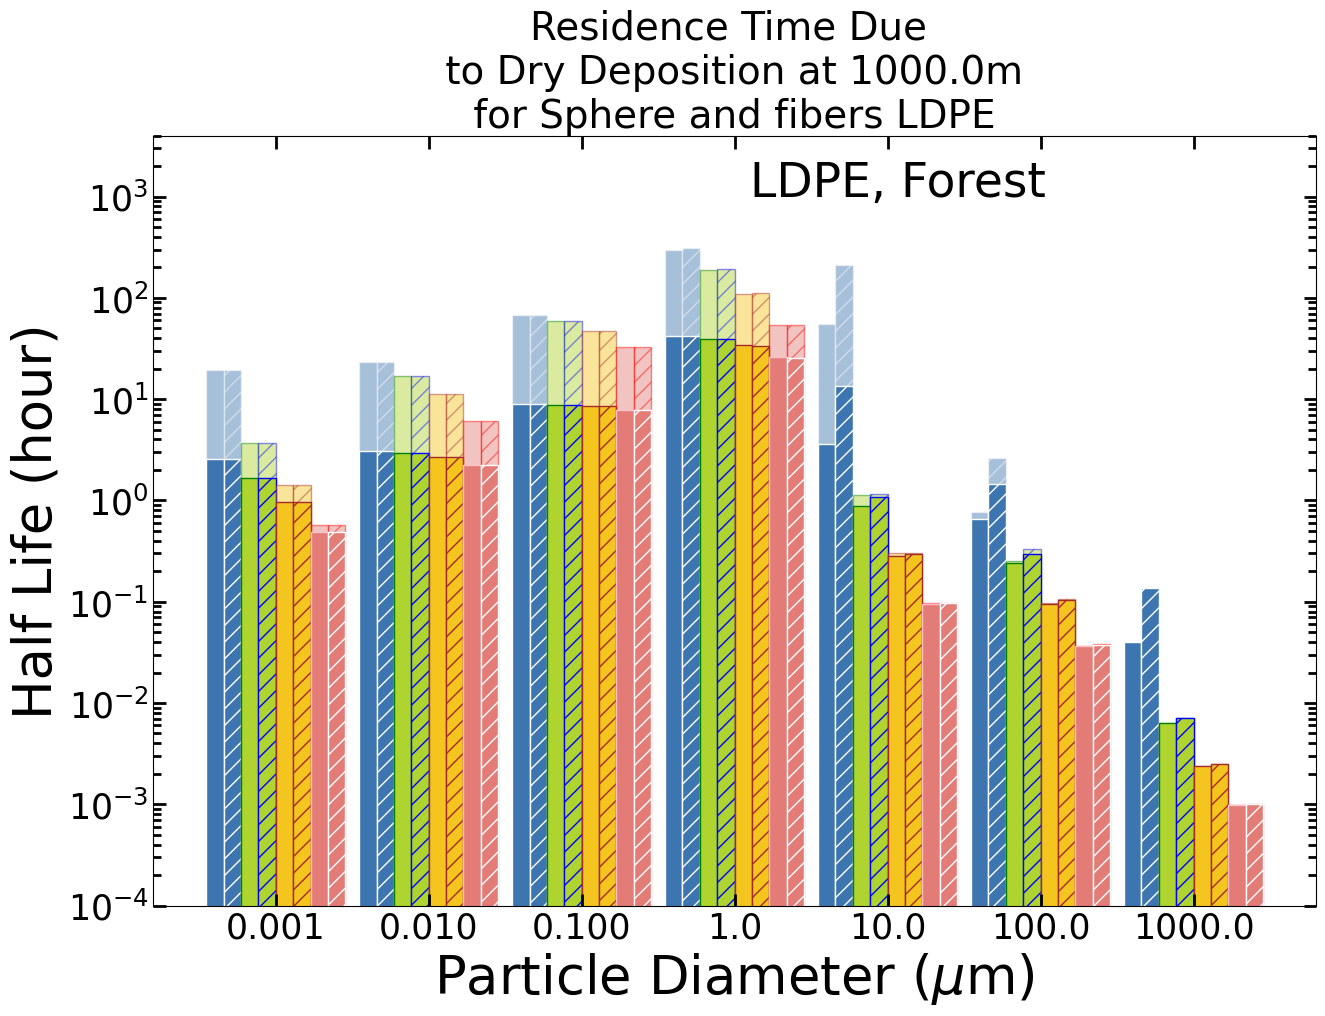

In [28]:
#Forest:

import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']

tri_colors = ['#3c75af', '#afd42f','#f4c41f', '#e37c77']

d = particleDiameters

fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_HalfLifeLDPE_us_2_Zero = halfLife_Sphere_RI_Zero_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Zero = halfLife_Sphere_RI_Zero_forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = halfLife_Fiber_RI_Zero_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = halfLife_Fiber_RI_Zero_forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_Sphere_RI_drizzle_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_Sphere_RI_drizzle_forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = halfLife_Fiber_RI_drizzle_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = halfLife_Fiber_RI_drizzle_forest_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Moderate = halfLife_Sphere_RI_moderate_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_Sphere_RI_moderate_forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = halfLife_Fiber_RI_moderate_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = halfLife_Fiber_RI_moderate_forest_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Heavy = halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy =halfLife_Sphere_RI_veryHeavy_forest_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = halfLife_Fiber_RI_veryHeavy_forest_Neutral_ufr15_LDPE[sorted_indices]

# Select just some particle size for a better visibility
indices = [0, 1, 2, 3, 5, 8, 9]

sorted_d = np.array(sorted_d)[indices]

sorted_HalfLifeLDPE_us_2_Zero = np.array(sorted_HalfLifeLDPE_us_2_Zero)[indices]
sorted_HalfLifeLDPE_us_15_Zero = np.array(sorted_HalfLifeLDPE_us_15_Zero)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Zero)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Zero)[indices]


sorted_HalfLifeLDPE_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_us_15_Drizzle)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Drizzle)[indices]


sorted_HalfLifeLDPE_us_2_Moderate = np.array(sorted_HalfLifeLDPE_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_us_15_Moderate = np.array(sorted_HalfLifeLDPE_us_15_Moderate)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Moderate)[indices]


sorted_HalfLifeLDPE_us_2_Heavy = np.array(sorted_HalfLifeLDPE_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_us_15_Heavy =np.array(sorted_HalfLifeLDPE_us_15_Heavy)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Heavy)[indices]



# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)


# Set the new bar width
num_bars = 8  # Total number of bars per group
bar_width = 1 / (num_bars + 0.8)  # Adjusted bar width

# Calculate positions for each bar
# Calculate positions for each bar
positions = [
    x - 3.5 * bar_width,  # 1st bar
    x - 2.5 * bar_width,  # 2nd bar
    x - 1.5 * bar_width,  # 3rd bar
    x - 0.5 * bar_width,  # 4th bar
    x + 0.5 * bar_width,  # 5th bar
    x + 1.5 * bar_width,  # 6th bar
    x + 2.5 * bar_width,  # 7th bar
    x + 3.5 * bar_width,  # 8th bar
]


# Create the bar plot
plt.bar(positions[0], sorted_HalfLifeLDPE_us_2_Zero,  edgecolor='white', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_2_Zero, edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[0])

plt.bar(positions[0], sorted_HalfLifeLDPE_us_15_Zero,  edgecolor='white', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_15_Zero, edgecolor='white',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[0])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_2_Drizzle,  edgecolor='green', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_2_Drizzle, edgecolor='blue', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[1])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_15_Drizzle,  edgecolor='green', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_15_Drizzle, edgecolor='blue',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[1])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_2_Moderate, edgecolor='brown',width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_2_Moderate, edgecolor='brown', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[2])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_15_Moderate, edgecolor='brown', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_15_Moderate, edgecolor='brown', hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_2_Heavy, edgecolor='red', width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_2_Heavy, edgecolor='red', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[3])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_15_Heavy,  edgecolor='pink', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_15_Heavy,  edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])




plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-4,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])





# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Sphere and fibers LDPE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=9)
plt.tick_params(which='minor', length=6)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'LDPE, Forest', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_LDPE_Sphere_Fiber_HalfeLife_forest_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


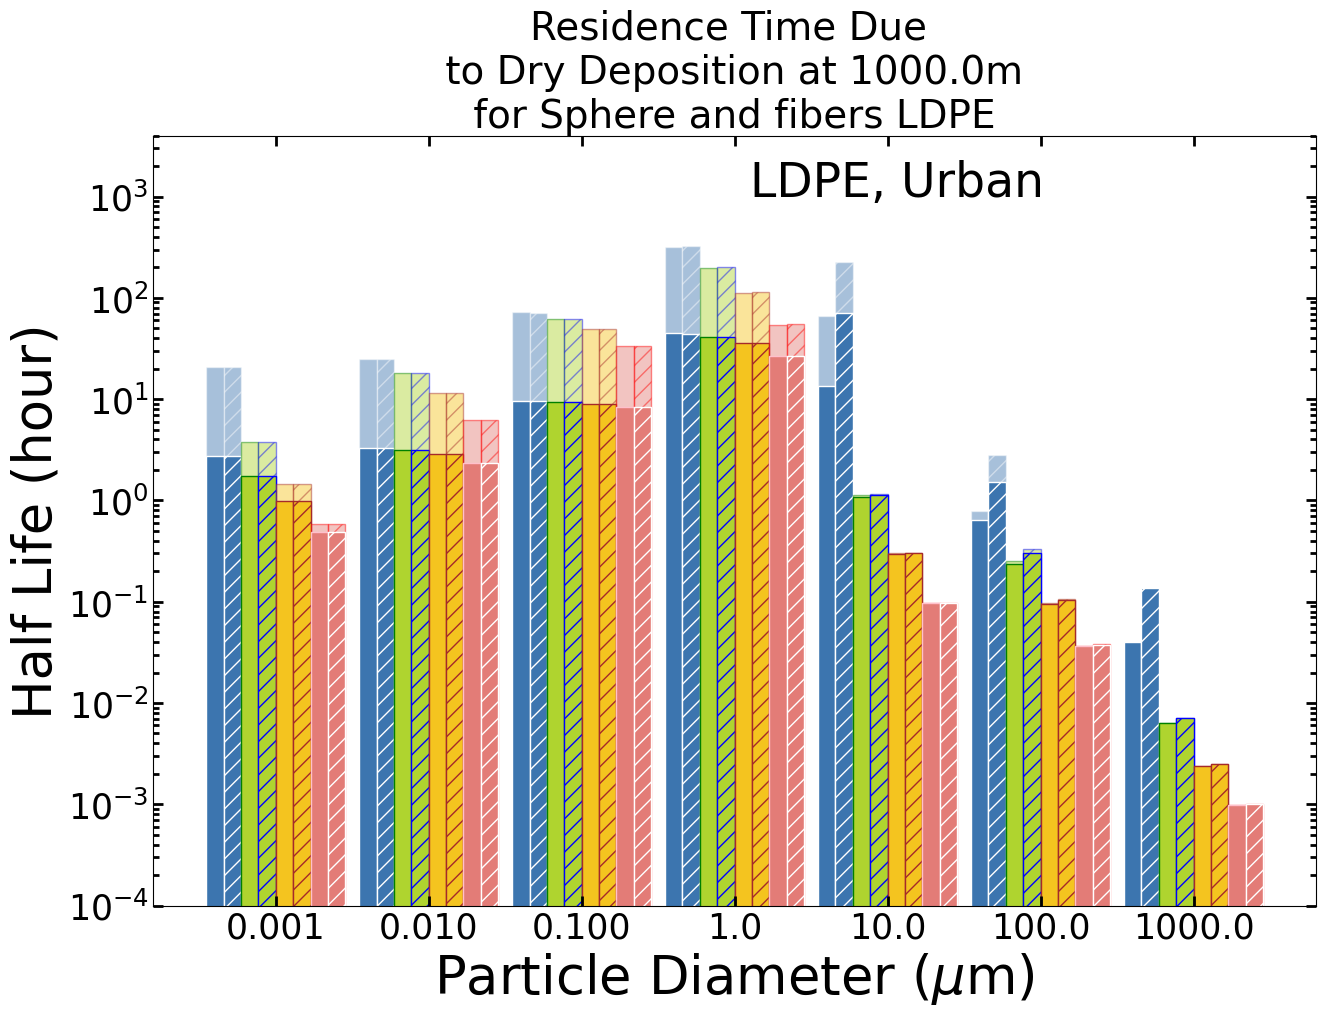

In [29]:
#Urban:

import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']

tri_colors = ['#3c75af','#afd42f','#f4c41f', '#e37c77']


d = particleDiameters

fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_HalfLifeLDPE_us_2_Zero = halfLife_Sphere_RI_Zero_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Zero = halfLife_Sphere_RI_Zero_urban_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = halfLife_Fiber_RI_Zero_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = halfLife_Fiber_RI_Zero_urban_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_Sphere_RI_drizzle_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_Sphere_RI_drizzle_urban_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = halfLife_Fiber_RI_drizzle_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = halfLife_Fiber_RI_drizzle_urban_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Moderate = halfLife_Sphere_RI_moderate_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_Sphere_RI_moderate_urban_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = halfLife_Fiber_RI_moderate_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = halfLife_Fiber_RI_moderate_urban_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Heavy = halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy =halfLife_Sphere_RI_veryHeavy_urban_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = halfLife_Fiber_RI_veryHeavy_urban_Neutral_ufr15_LDPE[sorted_indices]



# Select just some particle size for a better visibility
indices = [0, 1, 2, 3, 5, 8, 9]

sorted_d = np.array(sorted_d)[indices]

sorted_HalfLifeLDPE_us_2_Zero = np.array(sorted_HalfLifeLDPE_us_2_Zero)[indices]
sorted_HalfLifeLDPE_us_15_Zero = np.array(sorted_HalfLifeLDPE_us_15_Zero)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Zero)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Zero)[indices]


sorted_HalfLifeLDPE_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_us_15_Drizzle)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Drizzle)[indices]


sorted_HalfLifeLDPE_us_2_Moderate = np.array(sorted_HalfLifeLDPE_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_us_15_Moderate = np.array(sorted_HalfLifeLDPE_us_15_Moderate)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Moderate)[indices]


sorted_HalfLifeLDPE_us_2_Heavy = np.array(sorted_HalfLifeLDPE_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_us_15_Heavy =np.array(sorted_HalfLifeLDPE_us_15_Heavy)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Heavy)[indices]





# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)


# Set the new bar width
num_bars = 8  # Total number of bars per group
bar_width = 1 / (num_bars + 0.8)  # Adjusted bar width

# Calculate positions for each bar
# Calculate positions for each bar
positions = [
    x - 3.5 * bar_width,  # 1st bar
    x - 2.5 * bar_width,  # 2nd bar
    x - 1.5 * bar_width,  # 3rd bar
    x - 0.5 * bar_width,  # 4th bar
    x + 0.5 * bar_width,  # 5th bar
    x + 1.5 * bar_width,  # 6th bar
    x + 2.5 * bar_width,  # 7th bar
    x + 3.5 * bar_width,  # 8th bar
]


# Create the bar plot
plt.bar(positions[0], sorted_HalfLifeLDPE_us_2_Zero,  edgecolor='white', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_2_Zero, edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[0])

plt.bar(positions[0], sorted_HalfLifeLDPE_us_15_Zero,  edgecolor='white', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_15_Zero, edgecolor='white',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[0])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_2_Drizzle,  edgecolor='green', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_2_Drizzle, edgecolor='blue', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[1])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_15_Drizzle,  edgecolor='green', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_15_Drizzle, edgecolor='blue',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[1])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_2_Moderate, edgecolor='brown',width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_2_Moderate, edgecolor='brown', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[2])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_15_Moderate, edgecolor='brown', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_15_Moderate, edgecolor='brown', hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_2_Heavy, edgecolor='red', width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_2_Heavy, edgecolor='red', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[3])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_15_Heavy,  edgecolor='pink', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_15_Heavy,  edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])



plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-4,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])





# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Sphere and fibers LDPE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'LDPE, Urban', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_LDPE_Sphere_Fiber_HalfeLife_urban_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


[1.0e-09 1.0e-08 1.0e-07 1.0e-06 2.5e-06 1.0e-05 2.5e-05 5.0e-05 1.0e-04
 1.0e-03] [1.0e-03 1.0e-02 1.0e-01 1.0e+00 2.5e+00 1.0e+01 2.5e+01 5.0e+01 1.0e+02
 1.0e+03]


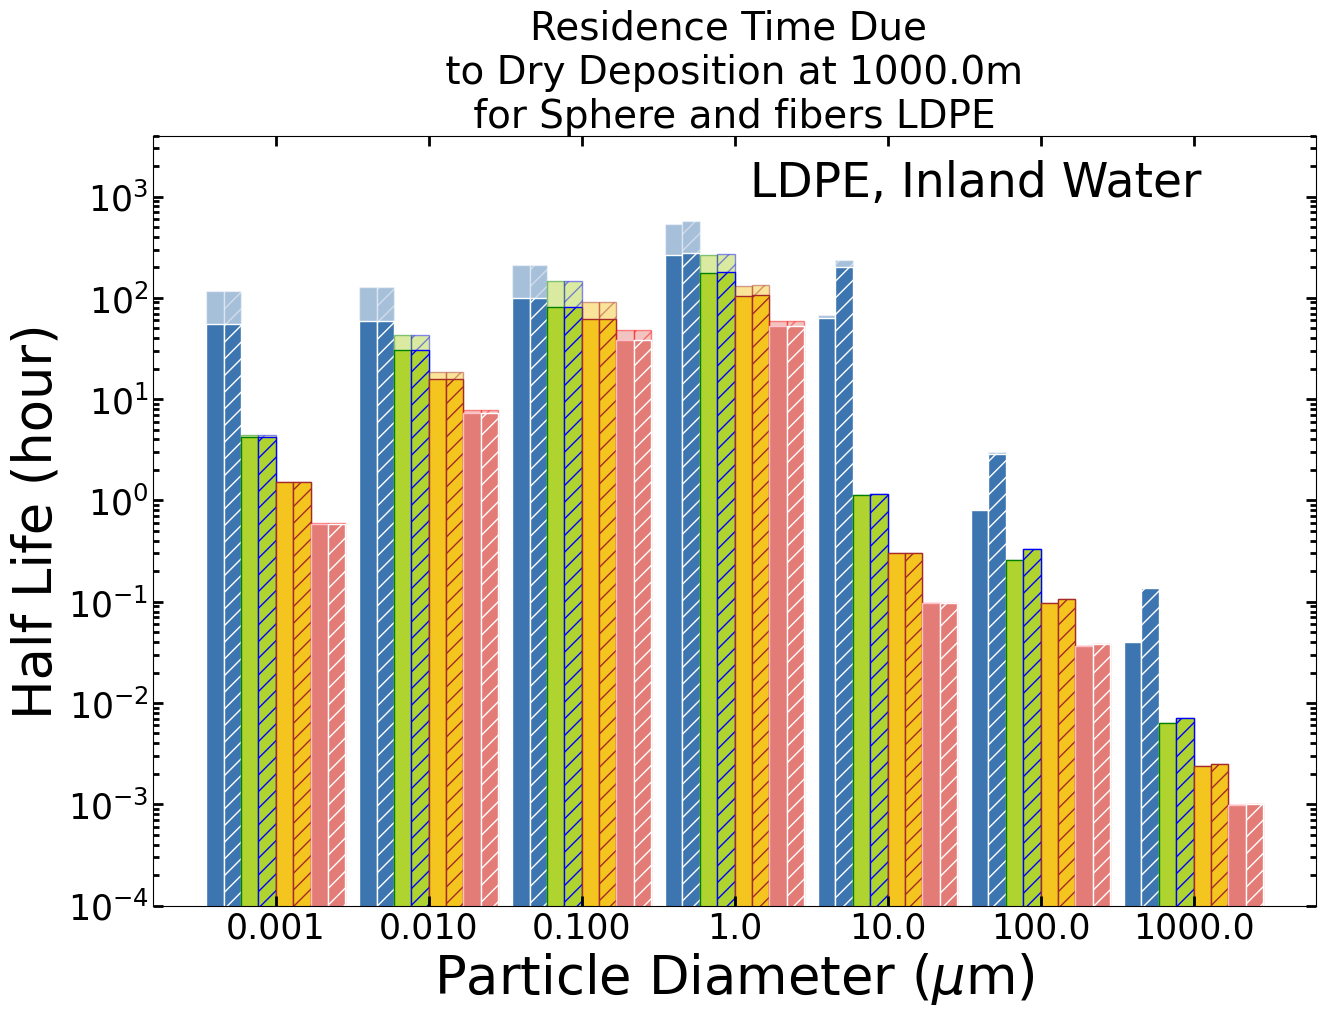

In [30]:
#inland:

import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']

tri_colors = ['#3c75af','#afd42f','#f4c41f', '#e37c77']


d = particleDiameters

fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]


sorted_HalfLifeLDPE_us_2_Zero = halfLife_Sphere_RI_Zero_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Zero = halfLife_Sphere_RI_Zero_inland_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = halfLife_Fiber_RI_Zero_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = halfLife_Fiber_RI_Zero_inland_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_Sphere_RI_drizzle_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_Sphere_RI_drizzle_inland_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = halfLife_Fiber_RI_drizzle_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = halfLife_Fiber_RI_drizzle_inland_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Moderate = halfLife_Sphere_RI_moderate_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_Sphere_RI_moderate_inland_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = halfLife_Fiber_RI_moderate_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = halfLife_Fiber_RI_moderate_inland_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifeLDPE_us_2_Heavy = halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy =halfLife_Sphere_RI_veryHeavy_inland_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = halfLife_Fiber_RI_veryHeavy_inland_Neutral_ufr15_LDPE[sorted_indices]


# Select just some particle size for a better visibility
indices = [0, 1, 2, 3, 5, 8, 9]

sorted_d = np.array(sorted_d)[indices]

sorted_HalfLifeLDPE_us_2_Zero = np.array(sorted_HalfLifeLDPE_us_2_Zero)[indices]
sorted_HalfLifeLDPE_us_15_Zero = np.array(sorted_HalfLifeLDPE_us_15_Zero)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Zero)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Zero = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Zero)[indices]


sorted_HalfLifeLDPE_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_us_15_Drizzle)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Drizzle)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Drizzle = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Drizzle)[indices]


sorted_HalfLifeLDPE_us_2_Moderate = np.array(sorted_HalfLifeLDPE_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_us_15_Moderate = np.array(sorted_HalfLifeLDPE_us_15_Moderate)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Moderate)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Moderate = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Moderate)[indices]


sorted_HalfLifeLDPE_us_2_Heavy = np.array(sorted_HalfLifeLDPE_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_us_15_Heavy =np.array(sorted_HalfLifeLDPE_us_15_Heavy)[indices]

sorted_HalfLifeLDPE_Fiber_us_2_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_2_Heavy)[indices]
sorted_HalfLifeLDPE_Fiber_us_15_Heavy = np.array(sorted_HalfLifeLDPE_Fiber_us_15_Heavy)[indices]



# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the new bar width
num_bars = 8  # Total number of bars per group
bar_width = 1 / (num_bars + 0.8)  # Adjusted bar width

# Calculate positions for each bar
# Calculate positions for each bar
positions = [
    x - 3.5 * bar_width,  # 1st bar
    x - 2.5 * bar_width,  # 2nd bar
    x - 1.5 * bar_width,  # 3rd bar
    x - 0.5 * bar_width,  # 4th bar
    x + 0.5 * bar_width,  # 5th bar
    x + 1.5 * bar_width,  # 6th bar
    x + 2.5 * bar_width,  # 7th bar
    x + 3.5 * bar_width,  # 8th bar
]


# Create the bar plot
plt.bar(positions[0], sorted_HalfLifeLDPE_us_2_Zero,  edgecolor='white', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_2_Zero, edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[0])

plt.bar(positions[0], sorted_HalfLifeLDPE_us_15_Zero,  edgecolor='white', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[0])
plt.bar(positions[1], sorted_HalfLifeLDPE_Fiber_us_15_Zero, edgecolor='white',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[0])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_2_Drizzle,  edgecolor='green', width=bar_width, label='LDPE Sphere deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_2_Drizzle, edgecolor='blue', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color = tri_colors[1])

plt.bar(positions[2], sorted_HalfLifeLDPE_us_15_Drizzle,  edgecolor='green', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$',  color=tri_colors[1])
plt.bar(positions[3], sorted_HalfLifeLDPE_Fiber_us_15_Drizzle, edgecolor='blue',hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[1])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_2_Moderate, edgecolor='brown',width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_2_Moderate, edgecolor='brown', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[2])

plt.bar(positions[4], sorted_HalfLifeLDPE_us_15_Moderate, edgecolor='brown', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])
plt.bar(positions[5], sorted_HalfLifeLDPE_Fiber_us_15_Moderate, edgecolor='brown', hatch='//',  width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[2])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_2_Heavy, edgecolor='red', width=bar_width, label='LDPE deposition u$_S$=2 m.s$^{-1}$',alpha=0.45, color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_2_Heavy, edgecolor='red', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=2 m.s$^{-1}$', alpha=0.45,color=tri_colors[3])

plt.bar(positions[6], sorted_HalfLifeLDPE_us_15_Heavy,  edgecolor='pink', width=bar_width, label='LDPE deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])
plt.bar(positions[7], sorted_HalfLifeLDPE_Fiber_us_15_Heavy,  edgecolor='white', hatch='//', width=bar_width, label='LDPE Fiber deposition u$_S$=15 m.s$^{-1}$', color=tri_colors[3])



plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-4,4.0e3])


# Define the custom formatter function
def custom_formatter(val):
    if val < 1.0:
        return f'{val:.3f}'
    else:
        return f'{val:.1f}'

# Apply the custom formatter to x-axis tick labels
plt.xticks(x, [custom_formatter(val * 1e6) for val in sorted_d])





# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Sphere and fibers LDPE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'LDPE, Inland Water', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_LDPE_Sphere_Fiber_HalfeLife_inland_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


In [31]:
# No rain:


# Rain Intensity
#  0.50 mm.h-1: drizzle
#  2.50 mm.h-1: moderate
# 10.00 mm.h-1: very heavy

Rain_Int_mmh = np.array([0.5, 2.5, 10.0]) #mm h−1

particleDiameters=np.array([0.1e-6, 1.0e-6, 10.0e-6, 20.0e-6, 50.0e-6, 70.0e-6, 100.0e-6, 500.0e-6, 1000.0e-6])


#Conversion of rain intensity from mm.h-1 to m.s-1
Rain_Int = rainIntensity_mm_by_h_To_m_by_s (Rain_Int_mmh)

#Calculate the size of the rain droplet
Dp = rainDropSize (Rain_Int)
print("Dp: ")
print(Dp)



RH = 0.8 

Cini = 15.0
# Create C0 array with same size as particleDiameter and initialize all values to Cini
C0 = np.full_like(particleDiameters, Cini)

P_Air =  898.7 * 100.0 #[Pa] 1000 m heigth, 898.7 hPa
height = 1000.0

#P_Air =  954.6 * 100.0 #[Pa]  500 m heigth, 954.6 hPa
#height = 500

#P_Air = 1001.3 * 100.0 #[Pa]  100 m heigth, 1001.3 hPa
#height = 100

#P_Air = 1012.0 * 100.0 #[Pa]    10 m heigth, 1012.0 hPa
#height = 10

T_Air = 25.0 + 273.15 #[K]
RH = 0.8 
particleName = 'HDPE'
rhoParticle = rhoHDPE
kpParticle = kpHDPE
alpha = 2.0


t = np.arange(0.0, 500.0*3600.0, 3600.0*0.025) # [s] arrange for values of delta t, linspace for a number linspace ;) 
th = t/3600
Eeff = collectionEfficiency_SlinnPhiCharge(Dp, RH, 
                                         particleDiameters, rhoParticle, kpParticle,
                                         alpha,
                                         P_Air, T_Air)


print ('Eeff')
print (Eeff)


# Scavenging coefficient
Scavenging = (3.0 / 2.0) * Eeff * Rain_Int / Dp

Scavenging = np.transpose(Scavenging)
print("scavenging")
print(Scavenging)
print("VDry",vdDry_ufr2_LUC8_Neutral_LDPE)



def WetAndDrySettling (C, t, Scavenging, vdDry, heigth):
    
    # Rate of change of concentration of C due to bellow wet settling
    dCdt_wet = -Scavenging * C
    
    # Rate of change of concentration of C due to dry settling, modified by wet reaction
    dCdt_dry = -(vdDry /heigth) * (C - dCdt_wet)
    #dCdt_dry = -(vdDry /(heigth * shape)) * (C)

    
    # Total rate of change of concentration of C
    dCdt = dCdt_wet + dCdt_dry
    dCdt = -(Scavenging +vdDry /(heigth * shape)) * C
    
    return dCdt




# Drizzle calculation LDPE
Cd_d0_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_drizzle_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[8],heigth))


Cd_d0_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_drizzle_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[8],heigth))


# Drizzle calculation PVC
Cd_d0_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_drizzle_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[8],heigth))


Cd_d0_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_drizzle_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[8],heigth))

limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_desert_Neutral_ufr2_LDPE <= limit)])


halfLife_RI_drizzle_desert_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_drizzle_desert_Neutral_ufr2_LDPE', halfLife_RI_drizzle_desert_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_desert_Neutral_ufr15_LDPE <= limit)])


halfLife_RI_drizzle_desert_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_drizzle_desert_Neutral_ufr15_LDPE', halfLife_RI_drizzle_desert_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_desert_Neutral_ufr2_PVC <= limit)])


halfLife_RI_drizzle_desert_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_drizzle_desert_Neutral_ufr2_PVC', halfLife_RI_drizzle_desert_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_desert_Neutral_ufr15_PVC <= limit)])


halfLife_RI_drizzle_desert_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_drizzle_desert_Neutral_ufr15_PVC', halfLife_RI_drizzle_desert_Neutral_ufr15_PVC)
#----------------------------------------------
# Moderate calculation LDPE
Cd_d0_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_Moderate_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[8],heigth))


Cd_d0_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_Moderate_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[8],heigth))


# Moderate calculation PVC
Cd_d0_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_Moderate_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[8],heigth))


Cd_d0_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_Moderate_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[8],heigth))




limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_desert_Neutral_ufr2_LDPE <= limit)])


halfLife_RI_Moderate_desert_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_Moderate_desert_Neutral_ufr2_LDPE', halfLife_RI_Moderate_desert_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_desert_Neutral_ufr15_LDPE <= limit)])


halfLife_RI_Moderate_desert_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_Moderate_desert_Neutral_ufr15_LDPE', halfLife_RI_Moderate_desert_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_desert_Neutral_ufr2_PVC <= limit)])


halfLife_RI_Moderate_desert_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_Moderate_desert_Neutral_ufr2_PVC', halfLife_RI_Moderate_desert_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_desert_Neutral_ufr15_PVC <= limit)])


halfLife_RI_Moderate_desert_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_Moderate_desert_Neutral_ufr15_PVC', halfLife_RI_Moderate_desert_Neutral_ufr15_PVC)

#----------------------------------------------
# Heavy calculation LDPE
Cd_d0_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_Heavy_desert_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr2_LUC8_Neutral_LDPE[8],heigth))


Cd_d0_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[0],heigth))
Cd_d1_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[1],heigth))
Cd_d2_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[2],heigth))
Cd_d3_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[3],heigth))
Cd_d4_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[4],heigth))
Cd_d5_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[5],heigth))
Cd_d6_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[6],heigth))
Cd_d7_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[7],heigth))
Cd_d8_RI_Heavy_desert_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr15_LUC8_Neutral_LDPE[8],heigth))


# Heavy calculation PVC
Cd_d0_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_Heavy_desert_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr2_LUC8_Neutral_PVC[8],heigth))


Cd_d0_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[0],heigth))
Cd_d1_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[1],heigth))
Cd_d2_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[2],heigth))
Cd_d3_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[3],heigth))
Cd_d4_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[4],heigth))
Cd_d5_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[5],heigth))
Cd_d6_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[6],heigth))
Cd_d7_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[7],heigth))
Cd_d8_RI_Heavy_desert_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr15_LUC8_Neutral_PVC[8],heigth))


limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_desert_Neutral_ufr2_LDPE <= limit)])

halfLife_RI_Heavy_desert_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_Heavy_desert_Neutral_ufr2_LDPE', halfLife_RI_Heavy_desert_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_desert_Neutral_ufr15_LDPE <= limit)])

halfLife_RI_Heavy_desert_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_Heavy_desert_Neutral_ufr15_LDPE', halfLife_RI_Heavy_desert_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_desert_Neutral_ufr2_PVC <= limit)])


halfLife_RI_Heavy_desert_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_Heavy_desert_Neutral_ufr2_PVC', halfLife_RI_Heavy_desert_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_desert_Neutral_ufr15_PVC <= limit)])

halfLife_RI_Heavy_desert_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_Heavy_desert_Neutral_ufr15_PVC', halfLife_RI_Heavy_desert_Neutral_ufr15_PVC)

val = vdDry_ufr15_LUC8_Neutral_PVC/1000.0 + Scavenging[2,:]
halfLife_desert_Neutral_ufr15_PVCCalculate = 0.693 * (1.0/val) / 3600.0
print('halfLife_desert_Neutral_ufr15_PVCCalculate', halfLife_desert_Neutral_ufr15_PVCCalculate)

Dp: 
[0.00086938 0.0011211  0.00139563]
91.3660280788266 0.0008693786985823227
147.5582738435722 0.0011211049126418119
215.33482961488474 0.0013956346209081701
Eeff
[[1.66368299e-03 1.26961204e-03 1.03285951e-03]
 [1.53331543e-03 1.18639491e-03 9.78073414e-04]
 [6.90817296e-01 6.81427515e-01 6.64032259e-01]
 [9.62888332e-01 9.47048589e-01 9.32469184e-01]
 [1.28647371e+00 1.21368426e+00 1.16281949e+00]
 [1.56401962e+00 1.42620325e+00 1.33044705e+00]
 [2.13262008e+00 1.85810378e+00 1.66728503e+00]
 [2.79747861e+01 2.14101744e+01 1.68223183e+01]
 [1.07182341e+02 8.20701880e+01 6.38066359e+01]]
scavenging
[[3.98676231e-07 3.67435635e-07 1.65543819e-04 2.30741490e-04
  3.08283786e-04 3.74793425e-04 5.11049846e-04 6.70373043e-03
  2.56846118e-02]
 [1.17965101e-06 1.10233041e-06 6.33143536e-04 8.79943469e-04
  1.12768611e-03 1.32514662e-03 1.72644393e-03 1.98931115e-02
  7.62549322e-02]
 [3.08360170e-06 2.92003783e-06 1.98246807e-03 2.78388642e-03
  3.47159718e-03 3.97204919e-03 4.97767886e-0

ValueError: operands could not be broadcast together with shapes (10,) (9,) 

[1.e-07 1.e-06 1.e-05 2.e-05 5.e-05 7.e-05 1.e-04 5.e-04 1.e-03] [1.e-01 1.e+00 1.e+01 2.e+01 5.e+01 7.e+01 1.e+02 5.e+02 1.e+03]


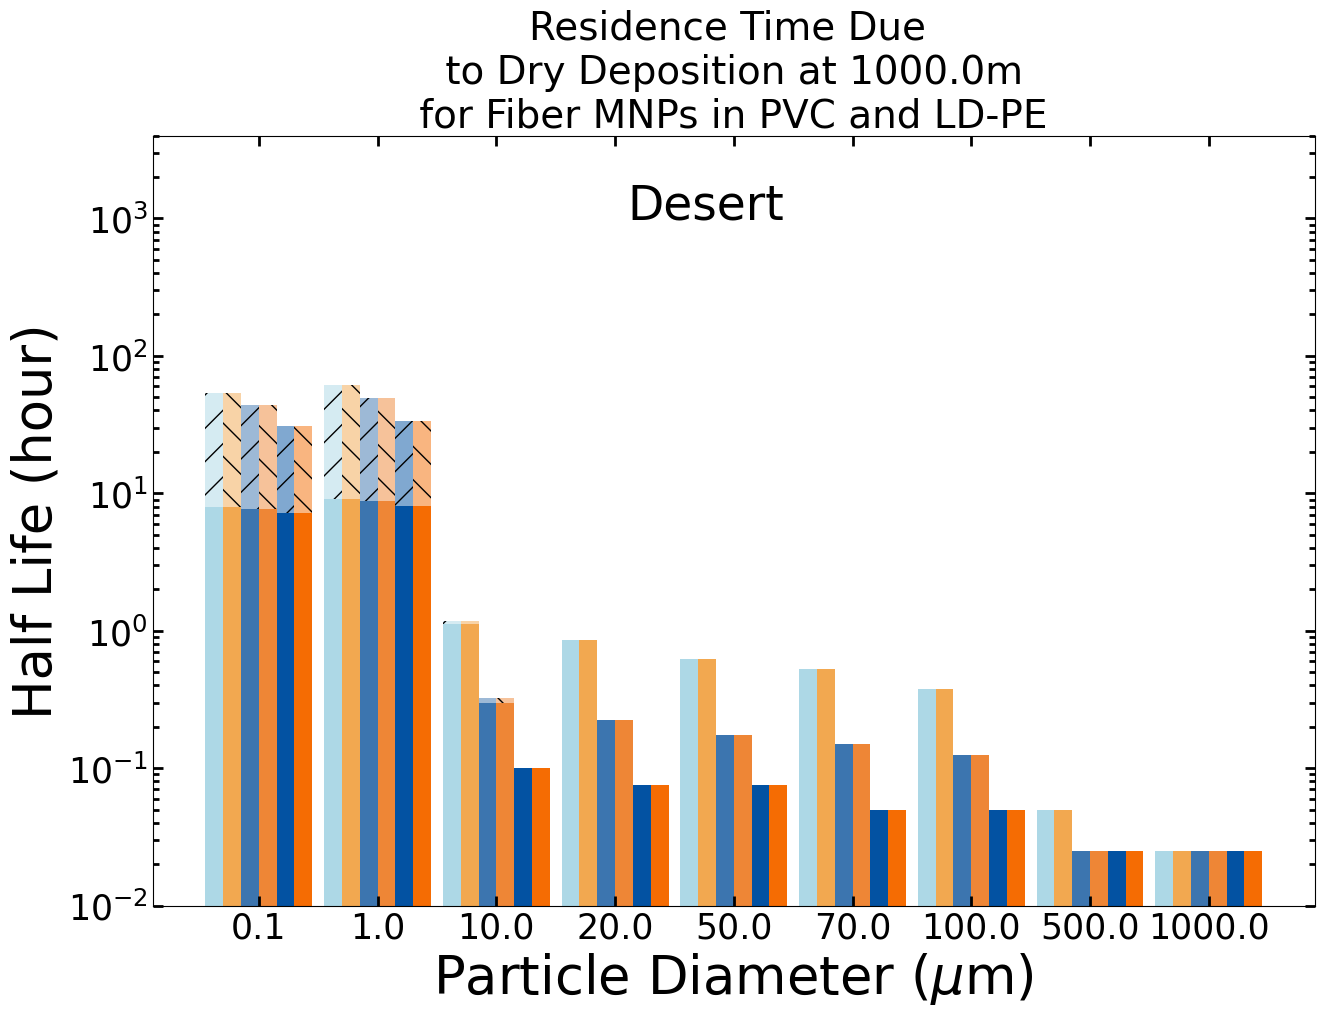

In [32]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']




d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]


sorted_HalfLifePVC_us_2_Drizzle = halfLife_RI_drizzle_desert_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Drizzle = halfLife_RI_drizzle_desert_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_RI_drizzle_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_RI_drizzle_desert_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifePVC_us_2_Moderate = halfLife_RI_Moderate_desert_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Moderate = halfLife_RI_Moderate_desert_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Moderate = halfLife_RI_Moderate_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_RI_Moderate_desert_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_Heavy = halfLife_RI_Heavy_desert_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Heavy = halfLife_RI_Heavy_desert_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Heavy = halfLife_RI_Heavy_desert_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy = halfLife_RI_Heavy_desert_Neutral_ufr15_LDPE[sorted_indices]

# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.15

# Create the bar plot

plt.bar(x- 0.375, sorted_HalfLifePVC_us_2_Drizzle, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x- 0.225, sorted_HalfLifeLDPE_us_2_Drizzle, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x- 0.375, sorted_HalfLifePVC_us_15_Drizzle, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x- 0.225, sorted_HalfLifeLDPE_us_15_Drizzle, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])

plt.bar(x- 0.075, sorted_HalfLifePVC_us_2_Moderate, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_2_Moderate, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[1])

plt.bar(x- 0.075, sorted_HalfLifePVC_us_15_Moderate, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_15_Moderate, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[1])

plt.bar(x+ 0.225, sorted_HalfLifePVC_us_2_Heavy, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_2_Heavy, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x+ 0.225, sorted_HalfLifePVC_us_15_Heavy, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_15_Heavy, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])



plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])


# Round x-axis tick labels to one decimal place
plt.xticks(x, [round(val, 1) for val in (sorted_d * 1e6)])

# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Fiber MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'Desert', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_Fiber_HalfeLife_desert_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')


In [33]:
# No rain:


# Rain Intensity
#  0.50 mm.h-1: drizzle
#  2.50 mm.h-1: moderate
# 10.00 mm.h-1: very heavy

Rain_Int_mmh = np.array([0.5, 2.5, 10.0]) #mm h−1

particleDiameters=np.array([0.1e-6, 1.0e-6, 10.0e-6, 20.0e-6, 50.0e-6, 70.0e-6, 100.0e-6, 500.0e-6, 1000.0e-6])


#Conversion of rain intensity from mm.h-1 to m.s-1
Rain_Int = rainIntensity_mm_by_h_To_m_by_s (Rain_Int_mmh)

#Calculate the size of the rain droplet
Dp = rainDropSize (Rain_Int)
print("Dp: ")
print(Dp)



RH = 0.8 

Cini = 15.0
# Create C0 array with same size as particleDiameter and initialize all values to Cini
C0 = np.full_like(particleDiameters, Cini)

P_Air =  898.7 * 100.0 #[Pa] 1000 m heigth, 898.7 hPa
height = 1000.0

#P_Air =  954.6 * 100.0 #[Pa]  500 m heigth, 954.6 hPa
#height = 500

#P_Air = 1001.3 * 100.0 #[Pa]  100 m heigth, 1001.3 hPa
#height = 100

#P_Air = 1012.0 * 100.0 #[Pa]    10 m heigth, 1012.0 hPa
#height = 10

T_Air = 25.0 + 273.15 #[K]
RH = 0.8 
particleName = 'HDPE'
rhoParticle = rhoHDPE
kpParticle = kpHDPE
alpha = 2.0


t = np.arange(0.0, 500.0*3600.0, 3600.0*0.025) # [s] arrange for values of delta t, linspace for a number linspace ;) 
th = t/3600
Eeff = collectionEfficiency_SlinnPhiCharge(Dp, RH, 
                                         particleDiameters, rhoParticle, kpParticle,
                                         alpha,
                                         P_Air, T_Air)


print ('Eeff')
print (Eeff)


# Scavenging coefficient
Scavenging = (3.0 / 2.0) * Eeff * Rain_Int / Dp

Scavenging = np.transpose(Scavenging)
print("scavenging")
print(Scavenging)
print("VDry",vdDry_ufr2_LUC13_Neutral_LDPE)



def WetAndDrySettling (C, t, Scavenging, vdDry, heigth):
    
    # Rate of change of concentration of C due to bellow wet settling
    dCdt_wet = -Scavenging * C
    
    # Rate of change of concentration of C due to dry settling, modified by wet reaction
    dCdt_dry = -(vdDry /heigth) * (C - dCdt_wet)
    #dCdt_dry = -(vdDry /(heigth * shape)) * (C)

    
    # Total rate of change of concentration of C
    dCdt = dCdt_wet + dCdt_dry
    dCdt = -(Scavenging +vdDry /(heigth * shape)) * C
    
    return dCdt




# Drizzle calculation LDPE
Cd_d0_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[8],heigth))


Cd_d0_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[8],heigth))


# Drizzle calculation PVC
Cd_d0_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_drizzle_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[8],heigth))


Cd_d0_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[0,0],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[0,1],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[0,2],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[0,3],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[0,4],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[0,5],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[0,6],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[0,7],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_drizzle_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[0,8],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[8],heigth))

limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_InlandWater_Neutral_ufr2_LDPE <= limit)])


halfLife_RI_drizzle_InlandWater_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_drizzle_InlandWater_Neutral_ufr2_LDPE', halfLife_RI_drizzle_InlandWater_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_InlandWater_Neutral_ufr15_LDPE <= limit)])


halfLife_RI_drizzle_InlandWater_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_drizzle_InlandWater_Neutral_ufr15_LDPE', halfLife_RI_drizzle_InlandWater_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_InlandWater_Neutral_ufr2_PVC <= limit)])


halfLife_RI_drizzle_InlandWater_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_drizzle_InlandWater_Neutral_ufr2_PVC', halfLife_RI_drizzle_InlandWater_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_drizzle_InlandWater_Neutral_ufr15_PVC <= limit)])


halfLife_RI_drizzle_InlandWater_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_drizzle_InlandWater_Neutral_ufr15_PVC', halfLife_RI_drizzle_InlandWater_Neutral_ufr15_PVC)
#----------------------------------------------
# Moderate calculation LDPE
Cd_d0_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[8],heigth))


Cd_d0_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[8],heigth))


# Moderate calculation PVC
Cd_d0_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_Moderate_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[8],heigth))


Cd_d0_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[1,0],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[1,1],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[1,2],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[1,3],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[1,4],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[1,5],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[1,6],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[1,7],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_Moderate_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[1,8],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[8],heigth))




limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_InlandWater_Neutral_ufr2_LDPE <= limit)])


halfLife_RI_Moderate_InlandWater_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_Moderate_InlandWater_Neutral_ufr2_LDPE', halfLife_RI_Moderate_InlandWater_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_InlandWater_Neutral_ufr15_LDPE <= limit)])


halfLife_RI_Moderate_InlandWater_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_Moderate_InlandWater_Neutral_ufr15_LDPE', halfLife_RI_Moderate_InlandWater_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_InlandWater_Neutral_ufr2_PVC <= limit)])


halfLife_RI_Moderate_InlandWater_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_Moderate_InlandWater_Neutral_ufr2_PVC', halfLife_RI_Moderate_InlandWater_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Moderate_InlandWater_Neutral_ufr15_PVC <= limit)])


halfLife_RI_Moderate_InlandWater_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_Moderate_InlandWater_Neutral_ufr15_PVC', halfLife_RI_Moderate_InlandWater_Neutral_ufr15_PVC)

#----------------------------------------------
# Heavy calculation LDPE
Cd_d0_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr2_LUC13_Neutral_LDPE[8],heigth))


Cd_d0_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[0],heigth))
Cd_d1_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[1],heigth))
Cd_d2_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[2],heigth))
Cd_d3_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[3],heigth))
Cd_d4_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[4],heigth))
Cd_d5_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[5],heigth))
Cd_d6_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[6],heigth))
Cd_d7_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[7],heigth))
Cd_d8_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr15_LUC13_Neutral_LDPE[8],heigth))


# Heavy calculation PVC
Cd_d0_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_Heavy_InlandWater_Neutral_ufr2_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr2_LUC13_Neutral_PVC[8],heigth))


Cd_d0_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[0],t, args=(Scavenging[2,0],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[0],heigth))
Cd_d1_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[1],t, args=(Scavenging[2,1],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[1],heigth))
Cd_d2_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[2],t, args=(Scavenging[2,2],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[2],heigth))
Cd_d3_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[3],t, args=(Scavenging[2,3],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[3],heigth))
Cd_d4_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[4],t, args=(Scavenging[2,4],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[4],heigth))
Cd_d5_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[5],t, args=(Scavenging[2,5],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[5],heigth))
Cd_d6_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[6],t, args=(Scavenging[2,6],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[6],heigth))
Cd_d7_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[7],t, args=(Scavenging[2,7],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[7],heigth))
Cd_d8_RI_Heavy_InlandWater_Neutral_ufr15_PVC = odeint(WetAndDrySettling,C0[8],t, args=(Scavenging[2,8],vdDry_Fiber100_ufr15_LUC13_Neutral_PVC[8],heigth))


limit = 0.5*Cini

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_InlandWater_Neutral_ufr2_LDPE <= limit)])

halfLife_RI_Heavy_InlandWater_Neutral_ufr2_LDPE = halfLife
print('halfLife_RI_Heavy_InlandWater_Neutral_ufr2_LDPE', halfLife_RI_Heavy_InlandWater_Neutral_ufr2_LDPE)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_InlandWater_Neutral_ufr15_LDPE <= limit)])

halfLife_RI_Heavy_InlandWater_Neutral_ufr15_LDPE = halfLife

print('halfLife_RI_Heavy_InlandWater_Neutral_ufr15_LDPE', halfLife_RI_Heavy_InlandWater_Neutral_ufr15_LDPE)


halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_InlandWater_Neutral_ufr2_PVC <= limit)])


halfLife_RI_Heavy_InlandWater_Neutral_ufr2_PVC = halfLife
print('halfLife_RI_Heavy_InlandWater_Neutral_ufr2_PVC', halfLife_RI_Heavy_InlandWater_Neutral_ufr2_PVC)

halfLife = np.array([])
halfLife = np.append(halfLife, th[np.argmax(Cd_d0_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d1_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d2_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d3_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d4_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d5_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d6_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d7_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])
halfLife = np.append(halfLife, th[np.argmax(Cd_d8_RI_Heavy_InlandWater_Neutral_ufr15_PVC <= limit)])

halfLife_RI_Heavy_InlandWater_Neutral_ufr15_PVC = halfLife

print('halfLife_RI_Heavy_InlandWater_Neutral_ufr15_PVC', halfLife_RI_Heavy_InlandWater_Neutral_ufr15_PVC)

val = vdDry_ufr15_LUC13_Neutral_PVC/1000.0 + Scavenging[2,:]
halfLife_InlandWater_Neutral_ufr15_PVCCalculate = 0.693 * (1.0/val) / 3600.0
print('halfLife_InlandWater_Neutral_ufr15_PVCCalculate', halfLife_InlandWater_Neutral_ufr15_PVCCalculate)

Dp: 
[0.00086938 0.0011211  0.00139563]
91.3660280788266 0.0008693786985823227
147.5582738435722 0.0011211049126418119
215.33482961488474 0.0013956346209081701
Eeff
[[1.66368299e-03 1.26961204e-03 1.03285951e-03]
 [1.53331543e-03 1.18639491e-03 9.78073414e-04]
 [6.90817296e-01 6.81427515e-01 6.64032259e-01]
 [9.62888332e-01 9.47048589e-01 9.32469184e-01]
 [1.28647371e+00 1.21368426e+00 1.16281949e+00]
 [1.56401962e+00 1.42620325e+00 1.33044705e+00]
 [2.13262008e+00 1.85810378e+00 1.66728503e+00]
 [2.79747861e+01 2.14101744e+01 1.68223183e+01]
 [1.07182341e+02 8.20701880e+01 6.38066359e+01]]
scavenging
[[3.98676231e-07 3.67435635e-07 1.65543819e-04 2.30741490e-04
  3.08283786e-04 3.74793425e-04 5.11049846e-04 6.70373043e-03
  2.56846118e-02]
 [1.17965101e-06 1.10233041e-06 6.33143536e-04 8.79943469e-04
  1.12768611e-03 1.32514662e-03 1.72644393e-03 1.98931115e-02
  7.62549322e-02]
 [3.08360170e-06 2.92003783e-06 1.98246807e-03 2.78388642e-03
  3.47159718e-03 3.97204919e-03 4.97767886e-0

ValueError: operands could not be broadcast together with shapes (10,) (9,) 

[1.e-07 1.e-06 1.e-05 2.e-05 5.e-05 7.e-05 1.e-04 5.e-04 1.e-03] [1.e-01 1.e+00 1.e+01 2.e+01 5.e+01 7.e+01 1.e+02 5.e+02 1.e+03]


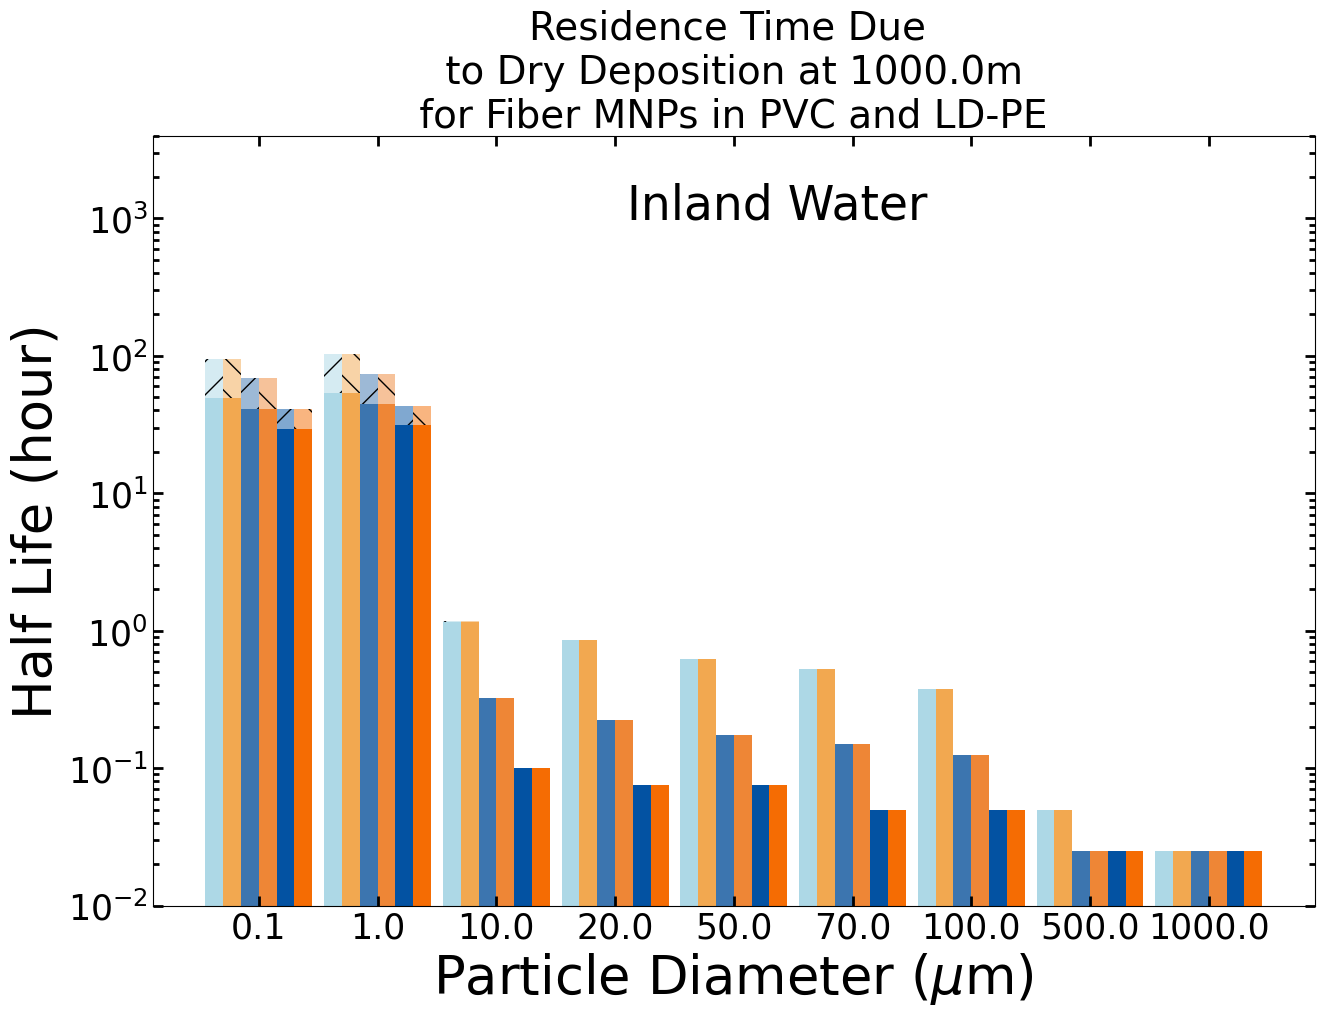

In [34]:
import numpy as np
import matplotlib.pyplot as plt


# Define shades of blue (light to dark)
blue_colors = ['#add8e6', '#3c75af', '#0352a2']

# Define shades of orange (light to dark)
orange_colors = ['#f2a850', '#ee8636', '#f56c03']




d = particleDiameters
fig = plt.figure(figsize=(15, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]


sorted_HalfLifePVC_us_2_Drizzle = halfLife_RI_drizzle_InlandWater_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Drizzle = halfLife_RI_drizzle_InlandWater_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Drizzle = halfLife_RI_drizzle_InlandWater_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Drizzle = halfLife_RI_drizzle_InlandWater_Neutral_ufr15_LDPE[sorted_indices]


sorted_HalfLifePVC_us_2_Moderate = halfLife_RI_Moderate_InlandWater_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Moderate = halfLife_RI_Moderate_InlandWater_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Moderate = halfLife_RI_Moderate_InlandWater_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Moderate = halfLife_RI_Moderate_InlandWater_Neutral_ufr15_LDPE[sorted_indices]

sorted_HalfLifePVC_us_2_Heavy = halfLife_RI_Heavy_InlandWater_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15_Heavy = halfLife_RI_Heavy_InlandWater_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2_Heavy = halfLife_RI_Heavy_InlandWater_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15_Heavy = halfLife_RI_Heavy_InlandWater_Neutral_ufr15_LDPE[sorted_indices]

# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.15

# Create the bar plot

plt.bar(x- 0.375, sorted_HalfLifePVC_us_2_Drizzle, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[0])
plt.bar(x- 0.225, sorted_HalfLifeLDPE_us_2_Drizzle, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[0])

plt.bar(x- 0.375, sorted_HalfLifePVC_us_15_Drizzle, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[0])
plt.bar(x- 0.225, sorted_HalfLifeLDPE_us_15_Drizzle, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[0])

plt.bar(x- 0.075, sorted_HalfLifePVC_us_2_Moderate, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_2_Moderate, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[1])

plt.bar(x- 0.075, sorted_HalfLifePVC_us_15_Moderate, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[1])
plt.bar(x+ 0.075, sorted_HalfLifeLDPE_us_15_Moderate, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[1])

plt.bar(x+ 0.225, sorted_HalfLifePVC_us_2_Heavy, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$',alpha=0.5, color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_2_Heavy, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', alpha=0.5,color = orange_colors[2])

plt.bar(x+ 0.225, sorted_HalfLifePVC_us_15_Heavy, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$', color=blue_colors[2])
plt.bar(x+ 0.375, sorted_HalfLifeLDPE_us_15_Heavy, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$', color=orange_colors[2])



plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([1e-2,4.0e3])

# Round x-axis tick labels to one decimal place
plt.xticks(x, [round(val, 1) for val in (sorted_d * 1e6)])


# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=38)
plt.ylabel('Half Life (hour)', fontsize=38)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Fiber MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=25 )
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

# Add legend
#plt.legend(fontsize=10)

plt.text(3.1e0, 1000.0e0, 'Inland Water', rotation='horizontal', fontsize=34)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_Fiber_HalfeLife_InlandWater_DrizzleModerateHeavyRain_'+ str(zfr)+'m.png', dpi=300, bbox_inches='tight')



In [35]:
#-------------------
fig = plt.figure(figsize=(10,10))

# Charge a colormap
cmapGreen = plt.get_cmap('Greens')
cmapYellow = plt.get_cmap('YlOrBr')
particleDiameters=np.array([1.0e-9, 1.0e-7, 1.0e-6, 10.0e-6, 50.0e-6, 100.0e-6])
plt.plot(t/3600.0, (Cd_d0_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=1.0 nm', color = 'tab:blue')
plt.plot(t/3600.0, (Cd_d1_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=0.1 $\mu$m', color = 'tab:purple')
plt.plot(t/3600.0, (Cd_d2_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=1.0 $\mu$m', color = 'tab:orange')
plt.plot(t/3600.0, (Cd_d3_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=10.0 $\mu$m', color = 'tab:green')
plt.plot(t/3600.0, (Cd_d4_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=50.0 $\mu$m', color = 'tab:brown')
plt.plot(t/3600.0, (Cd_d5_RI_drizzle_urban_Neutral_ufr2/Cini), linewidth=4, label=r'D$_{LDPE}$=100.0 $\mu$m', color = 'tab:red')

plt.title("Urban u$_{Surface}$=2 m.s$^{-1}$ \nMidsummer with lush vegetation", fontsize=28)

plt.legend(loc="upper right", fontsize=18 )


NameError: name 'Cd_d0_RI_drizzle_urban_Neutral_ufr2' is not defined

<Figure size 1000x1000 with 0 Axes>

In [36]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

d = particleDiameters
fig = plt.figure(figsize=(10, 10))
x_microm = 1.0e6*np.array(particleDiameters)

# Sort the indices based on the d array
sorted_indices = np.argsort(particleDiameters)

# Rearrange the d and y arrays based on the sorted indices
sorted_d = d[sorted_indices]

sorted_HalfLifePVC_us_2 = halfLife_RI_moderate_urban_Neutral_ufr2_PVC[sorted_indices]
sorted_HalfLifePVC_us_15 = halfLife_RI_moderate_urban_Neutral_ufr15_PVC[sorted_indices]

sorted_HalfLifeLDPE_us_2 = halfLife_RI_moderate_urban_Neutral_ufr2_LDPE[sorted_indices]
sorted_HalfLifeLDPE_us_15 = halfLife_RI_moderate_urban_Neutral_ufr15_LDPE[sorted_indices]


# Calculate the bar positions
x = np.arange(len(particleDiameters))

# Calculate the bar positions
x = np.arange(len(sorted_d))

print(d, x_microm)

# Set the bar width
bar_width = 0.4

# Create the bar plot


plt.bar(x- 0.2, sorted_HalfLifePVC_us_2, hatch='/',width=bar_width, label='PVC deposition u$_S$=2 m.s$^{-1}$', color='lightskyblue')
plt.bar(x+ 0.2, sorted_HalfLifeLDPE_us_2, hatch='\\', width=bar_width, label='LD-PE deposition u$_S$=2 m.s$^{-1}$', color = 'peachpuff')

plt.bar(x- 0.2, sorted_HalfLifePVC_us_15, width=bar_width, label='PVC deposition u$_S$=15 m.s$^{-1}$')#, color='darkblue')
plt.bar(x+ 0.2, sorted_HalfLifeLDPE_us_15, width=bar_width, label='LD-PE deposition u$_S$=15 m.s$^{-1}$')#, color='darkorange')


plt.yscale('log')
#plt.ylim([1e2,4.5e6])
plt.ylim([7e-2,4.0e3])


# Round x-axis tick labels to one decimal place
plt.xticks(x, [round(val, 1) for val in (sorted_d * 1e6)])

# Add labels and title
plt.xlabel(r'Particle Diameter ($\mu$m)', fontsize=28)
plt.ylabel('Half Life (s)', fontsize=28)
plt.title("Residence Time Due \n to Dry Deposition at "+ str(heigth)+ "m \n for Spheric MNPs in PVC and LD-PE ", fontsize=28)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tick_params(top=True, right=True, which='both', direction='in', width=2, labelsize=18 )
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)

# Add legend
plt.legend(fontsize=16)

plt.text(3.1e0, 5.0e0, 'URBAN \nModerate Rain', rotation='horizontal', fontsize=24)  # Position: (0.04, 0.5)

plt.savefig('DryWeBellowtDeposition_HalfeLife_UrbanModerateRain_'+ str(zfr)+'m.png', dpi=150, bbox_inches='tight')



NameError: name 'halfLife_RI_moderate_urban_Neutral_ufr2_PVC' is not defined

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>